# Opportunities@MeLi - Code Exercise - Data Scientist

## Description:
In the context of Mercadolibre's Marketplace an algorithm is needed to predict if an item listed in the marketplace is new or used.

Your tasks involve the data analysis, designing, processing and modeling of a machine learning solution to predict if an item is new or used and then evaluate the model over held-out test data.

To assist in that task a dataset is provided in `MLA_100k_checked_v3.jsonlines` and a function `build_dataset` to read that dataset in `new_or_used.py`.

For the evaluation, you will use the accuracy metric in order to get a result of 0.86 as minimum. Additionally, you will have to choose an appropriate secondary metric and also elaborate an argument on why that metric was chosen.

The deliverables are:
* The file, including all the code needed to define and evaluate a model.
* A document with an explanation on the criteria applied to choose the features, the proposed secondary metric and the performance achieved on that metrics. Optionally, you can deliver an EDA analysis with other format like .ipynb


# EDA (exploracion de datos)
En este notebook, se analizaran los datos contenidos en MLA_100k.jsonlines para desarrollar un modelo supervisado de calsificacion binaria que determinara si un producto es nuevo o usado.

principalmente para cada variable se debe observara si:

- Es viable para ser utilizada para el modelo o debe ser descartada. los criterios para determinar si debe ser descartada son:
    - ¿Es un identificador unico?
    - ¿Los valores de la columna son nulos?
    - ¿La informacion de columna es redundante con otra columna?
    - Criterio de experto
- Necesita alguna transformacion o procesamiento para ser util en el modeo 
- su distribucion e informacion descriptiva propia de la variable

## Libraries imports

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import geopy.distance

from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk


nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Paul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Declaracion de funciones

In [203]:
# You can safely assume that `build_dataset` is correctly implemented
def build_dataset():
    data = [json.loads(x) for x in open("../data/MLA_100k.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

def cantidad_distintos_nulo(df,lst_cols):
    text_cols = df[lst_cols].select_dtypes(include=['object', 'string']).columns
    df_cp = df.copy()
    df_cp.loc[:,text_cols] = df_cp[text_cols].replace("", np.nan)
                           
    df_isna = pd.DataFrame(df_cp[lst_cols].isna().sum(), columns=["cantidad_valores_nulos"])
    df_isna["pct_valores_nulos"] = df_isna["cantidad_valores_nulos"]/df.shape[0]
    df_isna = df_isna.sort_values(by="pct_valores_nulos", ascending=False)
    return df_isna
    
    
def descr_categorico(df,col,col_target=None, is_target=False, graficar=True):
    
    if is_target:
        gr_col = df.groupby([col])[["id"]].count()
        gr_col.columns = ["cantidad_registros"]
        gr_col = gr_col.reset_index()
        gr_col.columns = [col,"cantidad_registros"]
        gr_col["porcentaje"] = (100*gr_col["cantidad_registros"]/gr_col["cantidad_registros"].sum()).round(2)

        display(gr_col.sort_values(by="porcentaje",ascending=False))
        if graficar:
            n_cols = 1
            n_rows = 1
            
            fig,ax = plt.subplots(n_cols,n_rows,figsize=(n_rows*5, n_cols*3))
            sns.barplot(gr_col, x=col, y="cantidad_registros", hue=col, ax=ax)
            fig.suptitle(f"Grafica de valores para la columna {col}", fontsize=10, y=1.02)
    else:
        gr_condition = df.groupby([col,col_target])[["id"]].count()
        gr_condition.columns = ["cantidad_registros"]
        gr_condition = gr_condition.reset_index()
        gr_condition["porcentaje"] = (100*gr_condition["cantidad_registros"]/gr_condition.groupby(col)["cantidad_registros"].transform("sum")).round(2)
        gr_col = gr_condition.groupby([col])[["cantidad_registros"]].sum().reset_index()
        gr_col["porcentaje"] = (100*gr_col["cantidad_registros"]/gr_col["cantidad_registros"].sum()).round(2)

        display(gr_col.sort_values(by="porcentaje",ascending=False))
        display(gr_condition)
        if graficar:
            n_cols = 1
            n_rows = 2

            fig,ax = plt.subplots(n_cols,n_rows,figsize=(n_rows*10, n_cols*6))
            axs=ax.flatten()            

            sns.barplot(gr_col, x=col, y="porcentaje", hue=col, ax=axs[0])
            sns.barplot(gr_condition, x=col, y="porcentaje", hue=col_target, ax=axs[1])
            fig.suptitle(f"Grafica de valores para la columna {col}", fontsize=18, y=1.02)
            ax[0].set_title("distribucion de valores", fontsize=16)
            ax[1].set_title(f"distribucion de valores en referencia a variable objetivo {col_target}", fontsize=16)


def desc_continuous(df,col,col_target):
    df_nulos = pd.DataFrame([df[col].isna().sum()], columns = ["cantidad_nulos"])
    df_nulos["porcentaje_del_total"] = df_nulos/df.shape[0]
    desc_df_col = df[[col]].describe().T
    desc_df_target = df.groupby(col_target)[[col]].describe()

    display(df_nulos)
    display(desc_df_col)
    display(desc_df_target)

    n_rows = 2
    n_cols = 2

    fig,ax = plt.subplots(n_rows,n_cols,figsize=(n_cols*10, n_rows*6))
    axs = ax.flatten()

    sns.kdeplot(data=df, x=col, ax=axs[0])
    sns.kdeplot(data=np.log(df[col]), ax=axs[1])
    sns.kdeplot(data=df, x=col, hue=col_target, ax=axs[2])

    df_dummy = df[[col,col_target]]
    df_dummy.loc[:,col] = np.log(df_dummy[col])

    sns.kdeplot(data=df_dummy,x=col, hue=col_target, ax=axs[3])
    axs[0].set_title("distribucion variable {}".format(col))
    axs[1].set_title("distribucion variable {} - log transformacion".format(col))
    axs[2].set_title("distribucion variable {} con variable objetivo".format(col,col_target))
    axs[3].set_title("distribucion variable {} con variable objetivo {} - log transformacion".format(col,col_target))
    
    
def explore_json_column(df,col,limit=0, normalize=True):
    df_json = df.loc[df[col].str.len() > limit,[col]].\
                                explode(col)

    if normalize:
        df_json = df_json.reset_index()
        df_json = pd.json_normalize(df_json[col])
    return df_json


def valida_contenido_json(col_data, limit=0):
    val = (col_data.str.len() > limit).sum()
    return [val,val/len(col_data)]

def crear_wordcloud(df,column):
    # WordCloud
    fltr = ~df[column].replace("",np.nan).isna()
    text = " ".join(df.loc[fltr,column].str.lower().unique())

    # Generate a word cloud
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='viridis',
        max_words=20,
        stopwords=spanish_stopwords
    ).generate(text)

    # Display the word cloud
    plt.figure(figsize=(7, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud de {column}: top 20 palabras", fontsize=16)
    plt.show()

def quantile_plot(df,col):
    fltr = df["condition"]  == "new"
    percentiles = np.linspace(0, 100, 101)  # Percentiles from 0 to 100
    values_new = np.percentile(df.loc[fltr,col], percentiles)
    values_used = np.percentile(df.loc[~fltr,col], percentiles)

    log_values_new = np.percentile(np.log(df.loc[fltr,col]), percentiles)
    log_values_used = np.percentile(np.log(df.loc[~fltr,col]), percentiles)

    # Create a DataFrame for plotting
    df_percentiles = pd.DataFrame({'Percentile': percentiles,
                                   'new': values_new,
                                   'used':values_used,
                                   'log_new':log_values_new,
                                   'log_used':log_values_used
                                   })

    # Plot with Seaborn
    n_rows = 2
    n_cols = 1

    fig,ax = plt.subplots(n_rows,n_cols,figsize=(n_cols*5, n_rows*3))
    axs = ax.flatten()

    sns.lineplot(data=df_percentiles, x='Percentile', y='new', label="new", ax=axs[0])
    sns.lineplot(data=df_percentiles, x='Percentile', y='used', label="used", ax=axs[0])
    axs[0].set_title("sin transformar")
    axs[0].set_xlabel("percentil")
    axs[0].set_ylabel("valor")
    axs[0].grid()

    sns.lineplot(data=df_percentiles, x='Percentile', y='log_new', label="new", ax=axs[1])
    sns.lineplot(data=df_percentiles, x='Percentile', y='log_used', label="used", ax=axs[1])
    axs[1].set_title("transformacion log")
    axs[1].set_xlabel("percentil")
    axs[1].set_ylabel("valor")
    axs[1].grid()
    
    fig.suptitle(f'Grafico de percentiles variable: {col}')
    plt.tight_layout()
    plt.show()

## Preparacion de datos

In [204]:
# lectura de informacion cruda y separacion en datos de train y test
X_train, y_train, X_test, y_test = build_dataset()

# procesamiento para la lectura de archivos del tipo json
df = pd.json_normalize(X_train, sep='_')
print("Train:")
print(f"numero de filas: {df.shape[0]}.\nnumero de columnas: {df.shape[1]}")

Train:
numero de filas: 90000.
numero de columnas: 92


### Eliminar variables
En esta seccion se mostraran las variables que fueron eliminadas y los criterios por los cuales fueron descartadas

#### identificadores unicos
las siguientes columnas no seran parte del modelo por ser identificadores unicos que no dan valor al modelo

* id 
* thumbnail 
* secure_thumbnail
* permalink

In [205]:
col_unique = ["thumbnail","secure_thumbnail","permalink"]

df_info = pd.DataFrame(df[col_unique].nunique(), columns=["cant_valores_unicos"])
df_info["pct_valores_unicos"] = df_info["cant_valores_unicos"]/df.shape[0]
df_info

cant_valores_unicos  pct_valores_unicos
thumbnail                       88227              0.9803
secure_thumbnail                88227              0.9803
permalink                       90000              1.0000

#### Columnas con unico valor
Las columnas a continuacion tienen un unico valor en toda la base, por lo que no dan valor al modelo

* site_id
* location_country_id
* location_country_name
* international_delivery_mode

In [206]:
col_un_valor = ["site_id","location_country_id","location_country_name","international_delivery_mode"]
df_info = pd.DataFrame(df[col_un_valor].nunique(), columns=["cant_valores_unicos"])
df_info

cant_valores_unicos
site_id                                        1
location_country_id                            1
location_country_name                          1
international_delivery_mode                    1

In [207]:
# Drop de columnas
df_EDA = df.drop(columns=col_unique + col_un_valor)
print("df con transformacion:")
print(f"numero de filas: {df_EDA.shape[0]}.\nnumero de columnas: {df_EDA.shape[1]}")

df con transformacion:
numero de filas: 90000.
numero de columnas: 85


#### Valores faltantes
En esta seccion se analizaran los datos que tienen valores faltantes, algunas columnas tienen string vacios dentro de sus valores, los cuales cuentan como vacio

- seller_contact
- location_zip_code
- differential_pricing
- location_open_hours
- subtitle
- listing_source
- seller_contact_webpage
- catalog_product_id
- shipping_dimensions
- seller_contact_phone2
- seller_contact_area_code2
- seller_contact_other_info
- coverage_areas 
- shipping_methods
- shipping_tags

In [208]:
df_nulos = cantidad_distintos_nulo(df_EDA,df_EDA.columns)
df_nulos[df_nulos["pct_valores_nulos"]>0.9].head(12)

C:\Users\Paul\AppData\Local\Temp\ipykernel_6360\3441287285.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cp.loc[:,text_cols] = df_cp[text_cols].replace("", np.nan)


cantidad_valores_nulos  pct_valores_nulos
location_open_hours                         90000           1.000000
subtitle                                    90000           1.000000
seller_contact                              90000           1.000000
seller_contact_webpage                      90000           1.000000
listing_source                              90000           1.000000
location_zip_code                           90000           1.000000
differential_pricing                        90000           1.000000
catalog_product_id                          89993           0.999922
shipping_dimensions                         89978           0.999756
seller_contact_area_code2                   89971           0.999678
seller_contact_phone2                       89971           0.999678
seller_contact_other_info                   89939           0.999322

In [209]:
cols_val_faltantes = ["seller_contact", "location_zip_code", "differential_pricing",
       "location_open_hours", "subtitle", "listing_source",
       "seller_contact_webpage", "catalog_product_id", "shipping_dimensions",
       "seller_contact_phone2", "seller_contact_area_code2",
       "seller_contact_other_info"]

df_val_faltantes = pd.DataFrame(df_EDA[cols_val_faltantes].replace("",np.nan).nunique(), columns=["num_valores_unicos"])
df_val_faltantes.sort_values(by = "num_valores_unicos")

C:\Users\Paul\AppData\Local\Temp\ipykernel_6360\474945139.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_val_faltantes = pd.DataFrame(df_EDA[cols_val_faltantes].replace("",np.nan).nunique(), columns=["num_valores_unicos"])


num_valores_unicos
seller_contact                              0
location_zip_code                           0
differential_pricing                        0
location_open_hours                         0
subtitle                                    0
listing_source                              0
seller_contact_webpage                      0
seller_contact_area_code2                   3
catalog_product_id                          7
seller_contact_phone2                      11
shipping_dimensions                        13
seller_contact_other_info                  20

En esta sección, se analiza el contenido de las columnas que contienen listas o arrays. Aunque estas aparecen como no nulas, en algunos casos las listas están vacías, por lo que deben ser eliminadas.

In [210]:
cols_val_faltantes_json = ["coverage_areas","shipping_methods","shipping_tags","deal_ids"]
df_val_fantantes_json = df_EDA[cols_val_faltantes_json].apply(lambda col: valida_contenido_json(col), result_type='expand').T
df_val_fantantes_json.columns=["cantidad_distintos_nulo","pct_distintos_nulo"]
df_val_fantantes_json

cantidad_distintos_nulo  pct_distintos_nulo
coverage_areas                        0.0            0.000000
shipping_methods                      0.0            0.000000
shipping_tags                        59.0            0.000656
deal_ids                            217.0            0.002411

In [211]:
df_EDA = df_EDA.drop(columns=cols_val_faltantes+cols_val_faltantes_json)
print("df con transformacion:")
print(f"numero de filas: {df_EDA.shape[0]}.\nnumero de columnas: {df_EDA.shape[1]}")

df con transformacion:
numero de filas: 90000.
numero de columnas: 69


#### Redundancia de informacion
En esta seccion se eliminan ciertas variables que pueden estar ya contenidas en otra columna. 

##### Por nombre
Se elige entre los pares de variables (nombre variable)**_id** y (nombre variable)**_name**, como la variable name es mas interpretable se conservan estas variables

In [212]:
cols_redundantes_por_nombre = ["seller_address_country_id",
                            "seller_address_search_location_neighborhood_id",
                            "seller_address_search_location_state_id",
                            "seller_address_search_location_city_id",
                            "seller_address_city_id", 
                            "seller_address_state_id",
                            "location_neighborhood_id",
                            "location_city_id", 
                            "location_state_id"]

##### Por ubicacion geografica
A continuacion se evalua la redundancia de las variables geograficas, las siguientes columnas son eliminadas

- geolocation_latitude 
- geolocation_longitude
- seller_address_latitude
- seller_address_longitude
- seller_address_search_location_state_name
- seller_address_id
- seller_address_search_location_city_name

luego de evaluar las variables anteriores frente a otras columnas se determina que son iguales o lo suficientemente similares a otra columna como para ser descartadas. a continuacion el analisis en detalle.

In [213]:
cols_redundates_geograficas = ["geolocation_latitude",
                               "geolocation_longitude",
                               "seller_address_latitude",
                               "seller_address_longitude",
                               "seller_address_search_location_state_name",
                               "seller_address_id",
                               "seller_address_search_location_city_name"
                               ]

- **latitud y longitud:**
Se analizan las coordenadas para determinar si son las mismas, para ello se evalua a que distancia se encuentran las unas de las otras.

<div style="display: flex; justify-content: center; align-items: center;">
  <img src="../imagenes/distancia_geografica.png" style="height: 150px; margin-right: 10px;"/>
</div>

con la transformacion y analisis de las variables se determina que el **0.111%** de las coordenadas esta a una distancia mayor de 10km de su par, por lo que se considerará que las coordenadas son "iguales" y por lo tanto se puede eliminar un par de variables.

In [214]:
df_geoloc = df_EDA[['geolocation_latitude','geolocation_longitude',
        'seller_address_latitude','seller_address_longitude']].astype(str).apply(lambda col: col.replace("", np.nan)).astype(float)

# eliminar coordenadas vacias
df_geoloc = df_geoloc.dropna()
#crear coordenadas
df_geoloc['geolocation_coordinates'] = df_geoloc.apply(lambda row: (row['geolocation_latitude'], row['geolocation_longitude']), axis=1)
df_geoloc['seller_addres_coordinates'] = df_geoloc.apply(lambda row: (row['seller_address_latitude'], row['seller_address_longitude']), axis=1)
#calcular distancias
df_geoloc["distance"] = df_geoloc.apply(lambda row : geopy.distance.geodesic(row['geolocation_coordinates'], row['seller_addres_coordinates']).km,
                                        axis=1)
df_geoloc.sort_values(by="distance", ascending = False)
# informacion final
fltr = df_geoloc["distance"] <= 10
print("pct de coordenadas iguales o a una distancia menor a 10km: {pct:.3f}".format(pct=100*sum(fltr)/len(fltr)))
print("pct de coordenadas iguales o a una distancia MAYOR a 10km: {pct:.3f}".format(pct=100*sum(~fltr)/len(fltr)))

pct de coordenadas iguales o a una distancia menor a 10km: 99.889
pct de coordenadas iguales o a una distancia MAYOR a 10km: 0.111


Tambien se determina que las variables de latitud y longitud se les puede hacer un analisis geoespacial, sin embargo para un modelo base incial no se tendran en cuenta estas variables

- **state name:**
Al comparar las columnas <span style="color: green;">**seller_address_state_name**</span> y <span style="color: red;">**seller_address_search_location_state_name**</span> se evidencia que la primera agrupa a la segunda, por lo tanto se decide prescindir de la segunda.

In [215]:
df_EDA.groupby(['seller_address_state_name','seller_address_search_location_state_name'])[["id"]].count().sort_values(by='id', ascending=False)

id
seller_address_state_name seller_address_search_location_state_name       
Capital Federal           Capital Federal                            52142
Buenos Aires              Bs.As. G.B.A. Sur                           8249
                          Bs.As. G.B.A. Norte                         7959
                          Bs.As. G.B.A. Oeste                         7498
                                                                      3507
Santa Fe                  Santa Fe                                    2392
Buenos Aires              Buenos Aires Interior                       2370
Córdoba                   Córdoba                                     1720
Buenos Aires              Bs.As. Costa Atlántica                      1450
                          Capital Federal                              448
Mendoza                   Mendoza                                      400
Chubut                    Chubut                                       334
Entre Ríos                Entre Ríos                                   247
Tucumán                   Tucumán                                      212
San Juan                  San Juan                                     132
Salta                     Salta                                        129
Misiones                  Misiones                                     122
Río Negro                 Río Negro                                    119
Corrientes                Corrientes                                   109
Neuquén                   Neuquén                                       85
La Pampa                  La Pampa                                      69
Chaco                     Chaco                                         66
San Luis                  San Luis                                      56
Jujuy                     Jujuy                                         33
Formosa                   Formosa                                       26
Santiago del Estero       Santiago del Estero                           26
Santa Cruz                Santa Cruz                                    22
Catamarca                 Catamarca                                     20
La Rioja                  La Rioja                                      16
Tierra del Fuego          Tierra del Fuego                              10
Córdoba                                                                  7
Santa Fe                                                                 6
Chaco                                                                    3
Tucumán                                                                  2
Formosa                                                                  2
Salta                                                                    2
Neuquén                                                                  2
Entre Ríos                                                               2
La Pampa                                                                 1
Corrientes                                                               1
Chubut                                                                   1
Capital Federal                                                          1
Buenos Aires              Santa Fe                                       1
                                                                         1

- **seller_address_search_location_city_name:** Se considera que la granularidad de esta variable **325** ciudades aumentaria significativamente la dimensionalidad del problema, y que ademas al contar con variables como **estado** que agrupan varias ciudades no es necesario conservar la variable de ciudad por lo tanto se eliminará esta variable

In [216]:
df_EDA.groupby(['seller_address_state_name','seller_address_search_location_city_name'])[["id"]].count().sort_values(by='id', ascending=False).head(10)

id
seller_address_state_name seller_address_search_location_city_name       
Capital Federal           Capital Federal                           52108
Buenos Aires                                                         3801
                          La Matanza                                 2546
                          Vicente López                              2298
                          San Isidro                                 2005
Santa Fe                  Rosario                                    1973
Buenos Aires              Lanús                                      1634
                          General San Martín                         1473
                          Morón                                      1460
                          Lomas de Zamora                            1356

- **addres_id:**
La siguiente variable es <span style="color: red;">**seller_addres_id**</span> esta variable es redundante con <span style="color: green;">**seller_id**</span>, como se evidencia en la siguiente celda solo un par de *sellers* tienen mas de una direccion por lo que se puede eliminar la variable

In [217]:
gr_0 = df_EDA.groupby(['seller_id','seller_address_id'])[["id"]].count().reset_index()
gr = gr_0.groupby(["seller_id"])[["seller_address_id"]].count().sort_values(by="seller_address_id", ascending=False).head(10)
gr

seller_address_id
seller_id                   
35851775                   2
58391698                   2
15816492                   2
138094599                  2
58597029                   2
158994601                  2
95024038                   2
126942409                  1
126947873                  1
126951820                  1

In [218]:
cols_redundantes = cols_redundantes_por_nombre + cols_redundates_geograficas
df_EDA = df_EDA.drop(columns=cols_redundantes)
print("df con transformacion:")
print(f"numero de filas: {df_EDA.shape[0]}.\nnumero de columnas: {df_EDA.shape[1]}")

df con transformacion:
numero de filas: 90000.
numero de columnas: 53


#### Criterio experto
En esta seccion se muestran los criterios para eliminar ciertas variables a partir del analisis de los valores de estas.

- last_updated
- start_time
- stop_time
- seller_address_comment
- seller_address_address_line
- seller_address_city_name
- seller_address_zip_code
- sub_status
- shipping_free_methods
- status
- currency_id
- seller_address_country_name

##### A priori
En esta seccion se eliminan las variables que per se no se consideran que aporten valor, sin un analisis profundo, las variables elegidas son dependientes del tiempo.

- last_updated
- start_time
- stop_time

la siguiente variable, contiene valores que no son interpretables

- descriptions

In [219]:
df_desc = explore_json_column(df_EDA,"descriptions")
display(df_desc.head())
print("cantidad valores unicos: {n}".format(n=df_desc.nunique()))

id
0  MLA578052519-912855983
1  MLA581565358-930764806
2  MLA578780872-916478256
3  MLA581877385-932309698
4  MLA576112692-902981678

cantidad valores unicos: id    87583
dtype: int64


In [220]:
cols_apriori = ["last_updated","start_time",
                "stop_time","date_created","descriptions"]
df_EDA = df_EDA.drop(columns=cols_apriori)
print("df con transformacion:")
print(f"numero de filas: {df_EDA.shape[0]}.\nnumero de columnas: {df_EDA.shape[1]}")

df con transformacion:
numero de filas: 90000.
numero de columnas: 48


##### Variables de Texto (NLP)
A las siguientes variables se les realiza un analisis de bag of words para determinar el contenido de las columnas. las variables a continuacion dan detalle de la direccion del cliente como avenida, departamento etc. y por lo tanto no se considera que sean candidatas para un modelo.

- seller_address_comment
- seller_address_address_line
- title*

- **address_comment y address_line:** 
Estas dos columnas tienen informacion de la direccion del vendedor del producto, luego de analizar la composicion de los textos por medio de bag of words se determina que estas variables no son candidatas para el modelo

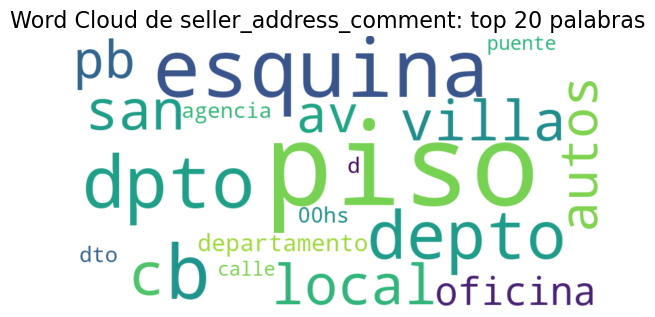

In [221]:
crear_wordcloud(df_EDA,"seller_address_comment")

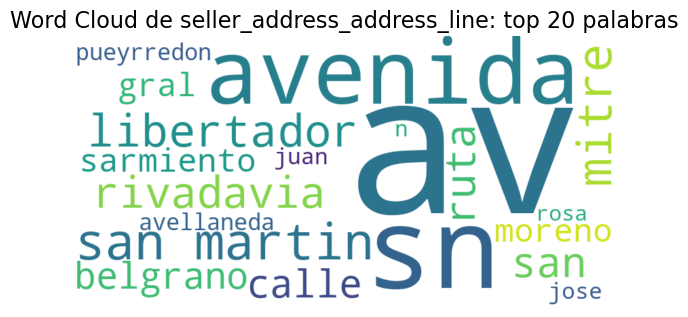

In [222]:
crear_wordcloud(df_EDA,'seller_address_address_line')

- **title:**
Esta variable es particular, si bien se observa que tiene un gran valor ya que contiene palabras clave no se incluira incialmente en el analisis ya que para obtener un mejor resultado de esta variable se debe aplicar un proceso de NLP y para una version incial del modelo no se tendrá en cuenta.

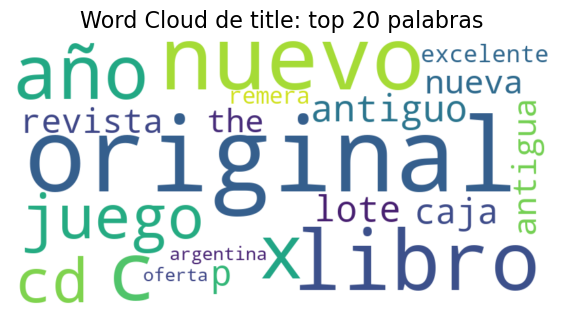

In [223]:
crear_wordcloud(df_EDA,"title")

##### Alta granularidad

no se consideran estas variables por que aumentarian la dimensionalidad del dataset, ademas al ser variables geograficas estas son redundantes con otras variables ya que estas pueden estar contenidas en otras columnas como por ejemplo: **seller_address_search_location_city_name**

- seller_address_city_name
- seller_address_zip_code
- seller_address_search_location_neighborhood_name

In [224]:
pd.DataFrame(df_EDA[['seller_address_city_name',
        'seller_address_zip_code',
        'seller_address_search_location_neighborhood_name']].nunique(), columns = ["numero_valores_unicos"])

numero_valores_unicos
seller_address_city_name                                           3480
seller_address_zip_code                                             299
seller_address_search_location_neighborhood_name                    536

##### Variables sin relacion al producto ofertado 

Las siguientes variables no tienen relacion con el producto ofertado, si no con el anuncio por lo que deciden eliminarse, adicionalmente la variable **sub_status** tiene una gran cantidad de valores nulos

- sub_status
- status

In [225]:
cols = ["sub_status","status"]
df_desc = df_EDA[cols].apply(lambda col: valida_contenido_json(col), result_type='expand').T
df_desc.columns = ["cantidad_no_nulos","pct_no_nulos"]
display(df_desc)

cantidad_no_nulos  pct_no_nulos
sub_status              891.0        0.0099
status                90000.0        1.0000

In [226]:
pd.DataFrame(explore_json_column(df_EDA,"sub_status",normalize=False).value_counts().reset_index())

sub_status  count
0  suspended    871
1    expired     13
2    deleted      7

In [227]:
descr_categorico(df_EDA,'status',is_target=True, graficar=False)

status  cantidad_registros  porcentaje
0          active               86116       95.68
3          paused                3863        4.29
1          closed                  20        0.02
2  not_yet_active                   1        0.00

##### Variables hegemonicas

estas variables tienen una mayoria evidente frente a otros valores de la columna, siendo casi iguales a las columnas de valores unicos, por tal motivo se decide descartar estas variables.

- currency_id
- seller_address_country_name

0


currency_id  cantidad_registros  porcentaje
0         ARS               89496       99.44
1         USD                 504        0.56

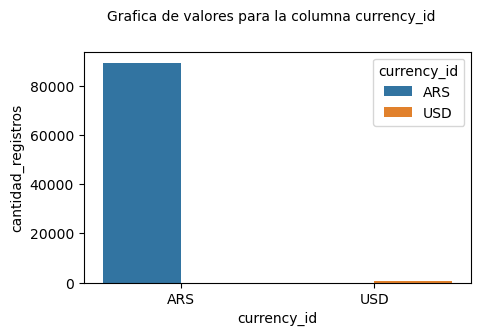

In [228]:
col = "currency_id"
print(df_EDA[col].isna().sum())
descr_categorico(df_EDA,col,is_target=True)

seller_address_country_name  cantidad_registros  porcentaje
1                   Argentina               89999       100.0
0                                               1         0.0

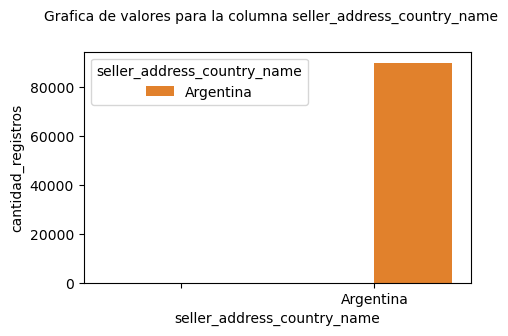

In [229]:
descr_categorico(df_EDA,'seller_address_country_name',is_target=True)

In [230]:
cols_criterio_exp = ["seller_address_comment",
                "seller_address_address_line",
                "title",
                "seller_address_city_name",
                "seller_address_zip_code",
                "seller_address_search_location_neighborhood_name",
                "sub_status",
                "status",
                "currency_id",
                "seller_address_country_name"]

df_EDA = df_EDA.drop(columns=cols_criterio_exp)
print("df con transformacion:")
print(f"numero de filas: {df_EDA.shape[0]}.\nnumero de columnas: {df_EDA.shape[1]}")

df con transformacion:
numero de filas: 90000.
numero de columnas: 38


### Transformar variables

En esta seccion se evaluaran de forma descriptiva las variables y las transformaciones que pueden ser aplicadas a estas para que tengan un mayor poder predictivo en el modelo.

#### Binarizacion

Las siguientes columnas son transformadas a valores binarios que indica la presencia o no del atributo de la columna, los valores en dichas columnas se pueden interpretar de la siguiente manera.
<center>

| valores binarios | interpretacion     |
|------------------|--------------------|
| 1                | presente           |
| 0                | no esta presente   |

</center>

##### Booleano a numerico
Las siguientes columnas estan almacenadas como booleanos y seran transformados a valores numericos para que la base este estandarizada con el criterio anterior

In [231]:
lst_binary_boolean_to_numeric = ["accepts_mercadopago", 
                                "automatic_relist", 
                                "shipping_local_pick_up",
                                "shipping_free_shipping"
                                ]
df_EDA[lst_binary_boolean_to_numeric] = df_EDA[lst_binary_boolean_to_numeric].astype(int)

##### Simplificacion - directa

Las siguientes columnas tienen distintos valores, para el modelo se determina que estas variables se transformaran a binario, para obtener una mejor interpretacion de las variables.

Estas variables pueden transformarse a binario simplemente determinando si el campo existe o no

- **warranty**: posee un texto que describe la garantia, se determina que el texto sera "descartado" pero se conservará una variable que indique si el articulo tenia un texto de garantia o no.

- **video_id**: esta columna tiene un identificador codificado del video el cual no brinda valor, sin embargo se cambia por un valor binario que indica si el producto tiene o no un video 

- **official_store_id**: en este caso el identificador de la columna no es entendible, sin embargo saber si el producto esta asociado a una tienda oficial puede ser util [referencia meli](https://developers.mercadolibre.com.ar/en_us/official-store)

- **parent_item_id**: esta relacionado con una republicacion, si tiene un *parent* quiere decir que hubo una republicacion. ([referencia](https://stackoverflow.com/questions/40478704/mercadolibre-api))

In [232]:
lst_binary_exists = ["warranty",
                    "parent_item_id", 
                    "official_store_id",
                    "video_id"
                    ]

fltr = (~df_EDA[lst_binary_exists].isna()).sum(axis=1) == 4
df_EDA.loc[fltr,lst_binary_exists]

warranty parent_item_id  \
537                                    Garantía Oficial.   MLA567312114   
12002       2 Años de Garantía Oficial Philips Argentina   MLA574144107   
41823      7 Años de garantía escrita por AISA IONIC S.A   MLA567252400   
42752  Garantía por 3 meses por roturas por fallas de...   MLA569497696   
50867                                   Garantía Oficial   MLA567311012   
54010  Garantía por 3 meses. Devoluciones solo por ro...   MLA573808578   
67638  Garantía por 3 meses. Devoluciones solo por ro...   MLA569556438   
89572  Garantía por 3 meses. Devoluciones solo por ro...   MLA565356957   

       official_store_id     video_id  
537                170.0  YU2f8ZoDqo0  
12002              221.0  cjHCzC69tyw  
41823              322.0  WkGGZndnDXo  
42752              256.0  I_YZIt3Ax_M  
50867              170.0  YU2f8ZoDqo0  
54010              256.0  Z5uTGNn2cwY  
67638              256.0  DZ0x58a_L4s  
89572              256.0  WKo_6fssxnc

In [233]:
df_EDA[lst_binary_exists] = (~df_EDA[lst_binary_exists].isna()).astype(int)

- **shipping_free_methods:**([referencia meli](https://developers.mercadolibre.com.ar/en_us/free-shipping-mshops)) esta variable indica si el producto tiene asociado un tipo de envio gratuito, esta almacenado como un json por lo que la transformacion a binario difiere de los datos anteriores, al converitr esta variable y analizarla vs *shipping_free_shipping* se evidencia una <span style="color: orange;">alta correlacion por lo que la variable debera ser descartada </span>

In [234]:
df_EDA["shipping_free_methods"] = (df_EDA["shipping_free_methods"].str.len() > 0).astype(int)

df_EDA[["shipping_free_shipping","shipping_free_methods"]].corr()

shipping_free_shipping  shipping_free_methods
shipping_free_shipping                 1.00000                0.99847
shipping_free_methods                  0.99847                1.00000

##### Simplificacion - indirecta

Para las siguientes columnas la conversion a binario implica la transformacion de la variable en una nueva, lo que significa que <span style="color: orange;">la variable original será eliminada y reemplazada por la nueva.</span>

- **buying_mode:** al observar las categorias se determina que esta variable, puede cambiarnse por una nueva que indica si el producto tiene asociada la propiedad de buy_now

buying_mode  cantidad_registros  porcentaje
1  buy_it_now               87311       97.01
2  classified                1982        2.20
0     auction                 707        0.79

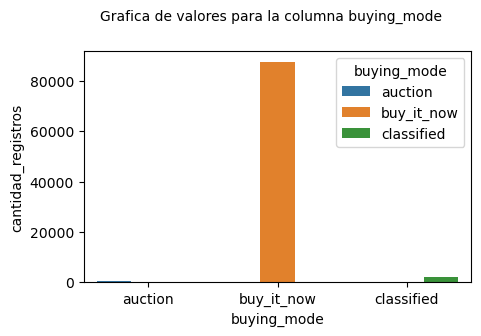

In [235]:
descr_categorico(df_EDA,'buying_mode',is_target=True)

- **seller_address_state_name:** para esta variable se evidencia una gran cantidad de productos se venden en la capital, por lo que se creara una variable que indique si el producto es vendido en la capital

In [236]:
descr_categorico(df_EDA,'seller_address_state_name',is_target=True, graficar=False)

seller_address_state_name  cantidad_registros  porcentaje
2            Capital Federal               52143       57.94
1               Buenos Aires               31482       34.98
21                  Santa Fe                2398        2.66
7                    Córdoba                1727        1.92
13                   Mendoza                 400        0.44
5                     Chubut                 335        0.37
8                 Entre Ríos                 249        0.28
24                   Tucumán                 214        0.24
18                  San Juan                 132        0.15
17                     Salta                 131        0.15
14                  Misiones                 122        0.14
16                 Río Negro                 119        0.13
6                 Corrientes                 110        0.12
15                   Neuquén                  87        0.10
4                      Chaco                  69        0.08
11                  La Pampa                  70        0.08
19                  San Luis                  56        0.06
10                     Jujuy                  33        0.04
9                    Formosa                  28        0.03
22       Santiago del Estero                  26        0.03
12                  La Rioja                  16        0.02
20                Santa Cruz                  22        0.02
3                  Catamarca                  20        0.02
23          Tierra del Fuego                  10        0.01
0                                              1        0.00

**shipping_mode**
([referencia meli](https://developers.mercadolibre.com.ec/mercado-envios))

Descripcion de las categorias:
- Mercado Envíos 1 (ME1): es una modalidad de envío que permite a los vendedores vender a través de Mercado Libre, utilizando su propia logística o servicios de terceros.
- Mercado Envíos 2 (ME2): es la modalidad de envío de Mercado Libre, donde se gestiona toda la logística utilizando diversos medios como correos, agencias, entre otros. Esta modalidad se divide a su vez en los siguiente tipos de logística:
    - Mercado Envíos Drop_off
    - Mercado Envíos Colectas (cross_docking) y Places (xd_drop_off)
    - Mercado Envíos Flex (self_service)
    - Mercado Envíos Turbo (turbo)
    - Mercado Envíos Full (fulfillment)
- Custom: es una modalidad de envío donde el vendedor carga una tabla con los precios de envío por cada región y se encarga de la logística.
- Not Specified: es una modalidad de envío donde el vendedor no especifica ningún precio de envío para sus publicaciones y debe ponerse en contacto con el comprador para coordinar el envío.

Transformacion:

Para esta variable luego de ver la documentacion y la distribucion de la variable, se identifican los distintos tipos de envio, que pueden categorizarse en dos grupos. 

1. no especificado, a convenir entre las partes
2. especificado, no necesita contacto entre las partes y agrupa las otras categorias

por tal motivo se crea la variable binaria:

<center>

| valores binarios | interpretacion                  |
|------------------|---------------------------------|
| 1                | metodo de envio no especificado |
| 0                | metodo de envio especificado    |

</center>





shipping_mode  cantidad_registros  porcentaje
2            me2               46059       51.18
3  not_specified               40725       45.25
0         custom                3130        3.48
1            me1                  86        0.10

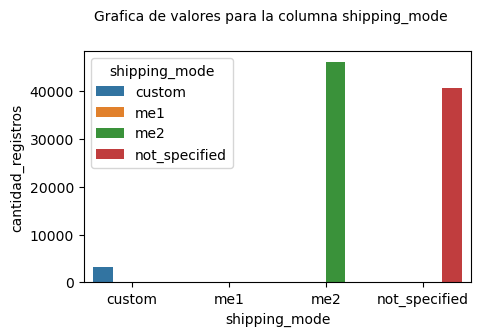

In [237]:
descr_categorico(df_EDA,"shipping_mode",is_target=True)

**Transformacion**

In [238]:
df_EDA["flg_buy_it_now"] = df_EDA["buying_mode"].isin(["buy_it_now"]).astype(int)
df_EDA["flg_is_capital_city"] = df_EDA["seller_address_state_name"].str.lower().isin(["capital federal"]).astype(int)
df_EDA["flg_ship_not_specified"] = df_EDA["shipping_mode"].isin(["not_specified"]).astype(int)

df_EDA = df_EDA.drop(columns=["buying_mode","seller_address_state_name","shipping_mode"])

##### Variable inmobiliaria

las siguientes variables se relacionan entre si ya que al analizar la cantidad de valores faltantes es evidente que es el mismo valor para todas estas columnas, por lo que se infiere que todas estas variables pueden indicar la presencia o no de algo.

Al analizar el valor de la variable *seller_contact_contact* con un wordCloud se evidencia que el tema comun es bienes raices. 

Por lo tanto las columnas enunciadas a continuacion **seran reemplazadas** por un ***flag* que indica que es del tipo inmobiliario** cuando hay un valor en la variable *seller_contact_contact*

- seller_contact_email
- seller_contact_contact
- seller_contact_area_code
- seller_contact_phone
- location_neighborhood_name
- location_longitude
- location_address_line
- location_latitude
- location_city_name
- location_state_name

In [239]:
# analisis de valores nulos
cols_location = ["seller_contact_email", "seller_contact_contact",
       "seller_contact_area_code", "seller_contact_phone",
       "location_neighborhood_name", "location_longitude",
       "location_address_line", "location_latitude", "location_city_name",
       "location_state_name"]

pd.DataFrame(df_EDA[cols_location].isna().sum(), columns=["cantidad_valores_faltantes"])

cantidad_valores_faltantes
seller_contact_email                             88018
seller_contact_contact                           88018
seller_contact_area_code                         88018
seller_contact_phone                             88018
location_neighborhood_name                       88018
location_longitude                               88018
location_address_line                            88018
location_latitude                                88018
location_city_name                               88018
location_state_name                              88018

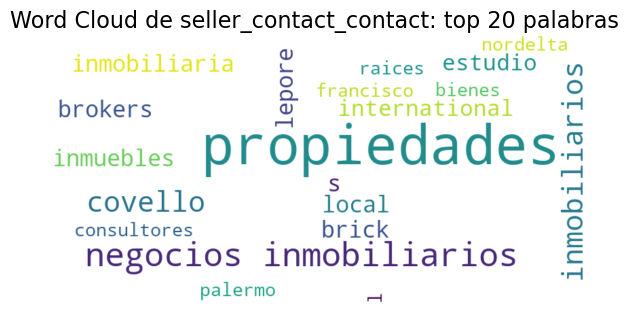

In [240]:
crear_wordcloud(df_EDA,'seller_contact_contact')

**Transformacion**

In [241]:
df_EDA["flg_inmobiliario"] = (~df_EDA['seller_contact_contact'].replace("",np.nan).isna()).astype(int)
df_EDA = df_EDA.drop(columns=cols_location)
print("df con transformacion:")
print(f"numero de filas: {df_EDA.shape[0]}.\nnumero de columnas: {df_EDA.shape[1]}")

df con transformacion:
numero de filas: 90000.
numero de columnas: 29


#### Nuevas variables

En esta seccion se exponen las nuevas variables creadas a partir de las existentes, con el objetivo de enriquecer el analisis, a partir de nueva informacion.

##### conteo de elementos
Algunas columnas contienen listas o arrays, con mas informacion dentro de estos, para las siguientes variables que tienen ese tipo de almacenamiento se realiza el conteo de elementos que esta en cada lista o array de la columna analizada, <span style="color: orange;">para reemplazar la variable original por este calculo</span>

In [242]:
def transform_num_elements_json(df,col,new_name):
    df[new_name] = df[col].str.len().fillna(0)
    if col != "non_mercado_pago_payment_methods":
        df.drop(columns = [col], inplace=True)
    return df

- **variations:**([referencia meli](https://developers.mercadolibre.com.ar/en_us/variations)) Esta columna tiene informacion de distintas opciones que hay para el producto ofertado, estas opciones pueden ser diferentes colores (imagen), tallas, capacidades, entre otras propiedades. Esto bajo la creencia que un producto nuevo puede que tenga mas opciones que uno usado ya que en el caso de un usado se esta vendiendo ese unico item

<div style="display: flex; justify-content: center; align-items: center;">
  <img src="../imagenes/tipos_variaciones_1.png" style="height: 150px; margin-right: 10px;"/>
  <img src="../imagenes/tipos_variaciones_2.png" style="height: 150px;"/>
</div>

In [243]:
# cantidad de elementos no nulos
df_desc = df_EDA[["variations"]].apply(lambda col: valida_contenido_json(col), result_type='expand').T
df_desc.columns = ["cantidad_no_nulos","porcentaje_no_nulos"]
display(df_desc)

# ejemplo de un producto con 2 variaciones
explore_json_column(df_EDA,"variations",2).head(2)

cantidad_no_nulos  porcentaje_no_nulos
variations             7374.0             0.081933

attribute_combinations seller_custom_field  \
0  [{'value_id': '92013', 'name': 'Color Primario...                None   
1  [{'value_id': '92013', 'name': 'Color Primario...                None   

                                         picture_ids  sold_quantity  \
0  [21897-MLA20219050871_122014, 21826-MLA2021905...              1   
1  [21897-MLA20219050871_122014, 21826-MLA2021905...              0   

   available_quantity          id  price  
0                   2  9391988875  590.0  
1                   2  9391988878  590.0

- **attributes:** ([referencia meli](https://developers.mercadolibre.com.ar/en_us/attributes)) esta variable contiene propiedades del producto, siguiendo la misma logica que con la columna variations, un producto nuevo puede que tenga mas artibutos que uno usado ya que en el caso de un usado se esta vendiendo ese unico item

In [244]:
# cantidad de elementos no nulos
df_desc = df_EDA[["attributes"]].apply(lambda col: valida_contenido_json(col), result_type='expand').T
df_desc.columns = ["cantidad_no_nulos","porcentaje_no_nulos"]
display(df_desc)

explore_json_column(df_EDA,"attributes",4).head(4)

cantidad_no_nulos  porcentaje_no_nulos
attributes            11150.0             0.123889

value_id attribute_group_id                 name  \
0                                ADICIONALES  Horario de contacto   
1  MLA1744-COLOREXT-PLATA        ADICIONALES                Color   
2  MLA1744-DIREC-ASISTIDA        ADICIONALES            Dirección   
3                                ADICIONALES          Único dueño   

      value_name attribute_group_name                id  
0  09 HS A 19 HS          Adicionales   MLA1743-HORPREF  
1          Plata          Adicionales  MLA1744-COLOREXT  
2       Asistida          Adicionales     MLA1744-DIREC  
3                         Adicionales     MLA1744-OWNER

- **tags:** ([referencia meli](https://developers.mercadolibre.cl/es_ar/publica-productos#Tags-de-un-item)) estos tags dan propiedades de la publicacion, al igual que en los elementos pasados se teoriza que la cantidad de tags pueda ser un indicador del tipo de producto nuevo o usado

In [245]:
# cantidad de elementos no nulos
df_desc = df_EDA[["tags"]].apply(lambda col: valida_contenido_json(col), result_type='expand').T
df_desc.columns = ["cantidad_no_nulos","porcentaje_no_nulos"]
display(df_desc)

pd.DataFrame(explore_json_column(df_EDA,"tags",normalize=False).value_counts().reset_index())

cantidad_no_nulos  porcentaje_no_nulos
tags            67588.0             0.750978

tags  count
0  dragged_bids_and_visits  66516
1   good_quality_thumbnail   1537
2           dragged_visits    723
3              free_relist    259
4   poor_quality_thumbnail     13

- **pictures:** si bien esta columna contiene mucha informacion de las fotos adjuntas al producto, que podria ser enriquecedora como el tamaño y la calidad, en este caso se tendra la variable con la cantidad de fotos adjunta al producto.

<div style="display: flex; justify-content: center; align-items: center;">
  <img src="../imagenes/var_pictures.png" style="height: 200px; margin-right: 10px;"/>
</div>

In [246]:
# cantidad de elementos no nulos
df_desc = df_EDA[["pictures"]].apply(lambda col: valida_contenido_json(col), result_type='expand').T
df_desc.columns = ["cantidad_no_nulos","porcentaje_no_nulos"]
display(df_desc)

explore_json_column(df_EDA,"pictures",2).head(2)

cantidad_no_nulos  porcentaje_no_nulos
pictures            89297.0             0.992189

size                                         secure_url  max_size  \
0  499x334  https://a248.e.akamai.net/mla-s1-p.mlstatic.co...   951x637   
1  500x375  https://a248.e.akamai.net/mla-s2-p.mlstatic.co...  1024x768   

                                                 url quality  \
0  http://mla-s1-p.mlstatic.com/23223-MLA20245018...           
1  http://mla-s2-p.mlstatic.com/23273-MLA20245018...           

                            id  
0  23223-MLA20245018984_022015  
1  23273-MLA20245018989_022015

- **non_mercado_pago_payment_methods:** esta columna contiene informacion de los tipos de metodos de pago aceptados por el vendedor. se transforma en un conteo de la cantidad de metodos ya que se espera que la cantidad de elementos de pagos este relacionado con el tipo de producto.

In [247]:
# cantidad de elementos no nulos
df_desc = df_EDA[["non_mercado_pago_payment_methods"]].apply(lambda col: valida_contenido_json(col), result_type='expand').T
df_desc.columns = ["cantidad_no_nulos","porcentaje_no_nulos"]
display(df_desc)

explore_json_column(df_EDA,"non_mercado_pago_payment_methods",4).head(4)

cantidad_no_nulos  porcentaje_no_nulos
non_mercado_pago_payment_methods            62469.0               0.6941

description     id type
0          MasterCard  MLAMC    C
1  Mastercard Maestro  MLAMS    D
2       Visa Electron  MLAVE    D
3    Contra reembolso  MLACD    G

**Transformacion**

In [248]:
dict_transform_num_elements = {
    "variations": "num_variations",
    "attributes": "num_attributes",
    "tags":"num_tags",
    "pictures": "num_pictures",
    "non_mercado_pago_payment_methods":"num_payment_methods"
    }
    
for original_column, new_column in dict_transform_num_elements.items():
    df_EDA = transform_num_elements_json(df_EDA, original_column, new_column)

##### indicador de variacion
Esta transformacion crea una variable que compara dos valores e indica si la diferencia entre estos es positiva, negativa o son iguales, esto por medio de una codigicacion de numeros entre -1 y 1, como es muestra a continuacion

$$
\text{variacion} = \text{valor base} - \text{valor comparado}
$$

<center>

| Valor | Interpretación                                    |
|-------|---------------------------------------------------|
| 1     | Si la variacion es positiva                       |
| 0     | Cuando no existe el dato base o no hay variación  |
| -1    | Si la variacion es negativa                       |

</center>

- **variacion de precios**

se toma la diferencia entre el precio de la variable **price** vs las dos variables adicionales de precio que son **original_price** y **base_price**
puede ser que una diferencia indique un descuento o aumento del valor.

In [249]:
df_EDA["variation_base_price"] = (np.sign(df_EDA["price"]  - df_EDA["base_price"])).fillna(0)
df_EDA["variation_original_price"] = (np.sign(df_EDA["price"]  - df_EDA["original_price"])).fillna(0)

##### Scores
para las variables se crea un score que dependera de las caracteristicas de cada una. el objetivo es transformar las variables en valores numericos que enriquezcan las variables, en general estos score requieren un valor incial que luego se aplica a la columna tratada, el resultado de esta transformacion es una nueva columna que <span style="color: orange;">reemplazará a la original</span>

- **seller_id:** Se puede enriquecer la informacion y crear una metrica que es el % de productos que tiene el vendedor que son usados, esto se realiza con cada cliente, el rango de la variable es [0,1]

formula
$$
\text{score seller} = \frac{(\text{cantidad de marca condición == used})_\text{seller}}{(\text{total de productos})_\text{seller}}
$$

In [250]:
df_EDA["binary_used"] = (df_EDA["condition"] == "used").astype(int)
gr_seller_id = df_EDA.groupby(["seller_id"]).agg({"binary_used":"sum","id":"count"}).sort_values(by="binary_used",ascending=False)

gr_seller_id["score_seller_used"] = gr_seller_id["binary_used"]/gr_seller_id["id"]
display(gr_seller_id.head(5))
dict_transform_seller_id = gr_seller_id[["score_seller_used"]].to_dict()["score_seller_used"]

df_EDA["score_seller"] = df_EDA["seller_id"].map(dict_transform_seller_id).fillna(0)
df_EDA.drop(columns=["seller_id"], inplace=True)

binary_used   id  score_seller_used
seller_id                                     
7125093            406  408           0.995098
58869788           256  259           0.988417
76404673           209  244           0.856557
80028439           209  211           0.990521
79695643           168  183           0.918033

- **category_id:** No se tiene detalle de cada categoria, adicionalmente se cuenta con mas de 10k categorias, tratar estos datos de forma categorica induciria a un problema de dimensionalidad, por este motivo se decide crear dos scores.

formulas

- Este score muestra el % de productos del tipo usado por cada categoria de productos, el rango de la variable es [0,1]

$$
\text{score category id} = \frac{\text{cantidad de elementos en la categoria == used}} {\text{cantidad productos categoria}}
$$

In [251]:
df_EDA["binary_used"] = (df_EDA["condition"] == "used").astype(int)

gr_seller_id = df_EDA.groupby(["category_id"]).agg({"binary_used":"sum","id":"count"})
gr_seller_id["score_category_used"] = gr_seller_id["binary_used"]/gr_seller_id["id"]
dict_category = gr_seller_id[["score_category_used"]].to_dict()["score_category_used"]

df_EDA["score_category_id"] = df_EDA["category_id"].map(dict_category).fillna(0)


- Este score indica el nivel de popularidad de la categoria del producto, se intepreta como la razon entre la cantidad de productos de la $categoria_i$ vs la cantidad de productos en la categoria mas popular. El rango de la variable es entre [0,1]

$$
\text{score category id popularity}_i = \frac{\text{cantidad de elementos en la categoria}_i} {\text{cantidad productos categoria mas popular}}
$$

In [252]:
gr_category_id = df_EDA.groupby("category_id")[["id"]].count().sort_values("id",ascending=False)
gr_category_id = gr_category_id/gr_category_id.max()

dict_popularity = gr_category_id.to_dict()["id"]
df_EDA["score_popularity_category"] = df_EDA["category_id"].map(dict_popularity).fillna(0)

df_EDA.drop(columns=["category_id","binary_used"], inplace=True)


##### Re-categorizacion
Las siguientes transformaciones cambian los datos al transformar las categorias existentes en nuevas, para reducir dimensionalidad o añadir interpretabilidad a las variables modelo

- **listing_type_id** ([referencia meli1](https://developers.mercadolibre.com.ar/en_us/listing-types-item-upgrades-tutorial), [referencia meli2](https://developers.mercadolibre.com.ni/es_ar/atributos))
Categorizacion del cliente, tiene sentido ordinal, por lo que se transformara el texto a valores entre 0 - 6

In [253]:
dict_transform_listing_type = {'free':0,
                            'bronze':1,
                            'silver':2,
                            'gold':3, 
                            'gold_premium':4,
                            'gold_special':5, 
                            'gold_pro':6}

df_EDA["listing_type_id"] = df_EDA["listing_type_id"].map(dict_transform_listing_type).fillna(0)

- **non_mercado_pago_payment_methods:** Al analizar la columna se ve que un producto puede tener mas de un metodo de pago, ademas que algunos de estos metodos se pueden agrupar en nuevas categorias, 7 para ser exactos, la correspondencia de categorias se ve a continuacion.

<center>

| Método de Pago            | nueva categoria        |
|---------------------------|------------------------|
| Acordar con el comprador  | efectivo_o_acuerdo     |
| Efectivo                  | efectivo_o_acuerdo     |
| Transferencia bancaria    | transferencia_bancaria |
| Giro postal               | giro_postal            |
| Cheque certificado        | cheque                 |
| American Express          | tarjeta_credito        |
| Diners                    | tarjeta_credito        |
| MasterCard                | tarjeta_credito        |
| Mastercard Maestro        | tarjeta_credito        |
| Visa                      | tarjeta_credito        |
| Visa Electron             | tarjeta_credito        |
| Tarjeta de crédito        | tarjeta_credito        |
| MercadoPago               | MercadoPago            |
| Contra reembolso          | contra_reembolso       |

</center>

luego de recategorizar a cada producto se le crea una nueva columna por cada categoria donde se indica la cantidad de metodos de pago correspondientes a esa categoria que tiene el producto.

Ej: el producto acepta american, diners, visa y masterCard, MercadoPago, Efectivo
<center>

| tarjeta_credito | MercadoPago        | efectivo_o_acuerdo |
|-----------------|--------------------|--------------------|
|       4         |          1         |         1          |

</center>

In [254]:
dict_metodos_de_pago = {
    "Acordar con el comprador": "efectivo_o_acuerdo",
    "Efectivo": "efectivo_o_acuerdo",
    "Transferencia bancaria": "transferencia_bancaria",
    "Giro postal": "giro_postal",
    "Cheque certificado": "cheque",
    "American Express": "tarjeta_credito",
    "Diners": "tarjeta_credito",
    "MasterCard": "tarjeta_credito",
    "Mastercard Maestro": "tarjeta_credito",
    "Visa": "tarjeta_credito",
    "Visa Electron": "tarjeta_credito",
    "Tarjeta de crédito": "tarjeta_credito",
    "MercadoPago": "MercadoPago",
    "Contra reembolso": "contra_reembolso"
}

df_payment_methods = df.loc[:,["id","non_mercado_pago_payment_methods"]].\
                        explode("non_mercado_pago_payment_methods").\
                        reset_index()

df_payment_methods_explode = pd.json_normalize(df_payment_methods["non_mercado_pago_payment_methods"])
df_payment_methods_explode.rename(columns={"description":"description_shipping_free_methods",
                                                "id":"id_shipping_free_methods"},
                                        inplace=True)

df_payment_methods = pd.concat([df_payment_methods[["id"]], 
                                    df_payment_methods_explode], 
                                    axis=1)[["id","description_shipping_free_methods","id_shipping_free_methods"]]


df_payment_methods["metodo_de_pago"] = df_payment_methods["description_shipping_free_methods"].map(dict_metodos_de_pago)
df_payment_methods["ones"] = 1
gr_df_payment_methods = df_payment_methods.groupby(["id","metodo_de_pago"])[["ones"]].sum().reset_index()
gr_df_payment_methods = gr_df_payment_methods.pivot(index="id",columns="metodo_de_pago", values="ones").fillna(0)


df_EDA = pd.merge(df_EDA, gr_df_payment_methods, on="id", how="left").fillna(0)
df_EDA.loc[:,gr_df_payment_methods.columns.values] = df_EDA[gr_df_payment_methods.columns.values].fillna(0)
df_EDA = df_EDA.drop(columns=["non_mercado_pago_payment_methods"])

#### Correlacion

ya con las variables pre seleccionadas se hace un analisis de correlacion entre las variables numericas para determinar que variables son redundantes y pueden ser eliminadas o transformadas.

en éste caso se encuentra una alta correlacion entre:
- las variables **initial_quantity** y **available_quantity** por lo que <span style="color: red;">se eliminara la variable available_quantity</span> y se creara un flag para determinar si los valores son iguales o no 

- las variables **base_price** y **price** su alta correlacion indica que tienen valores similares, sin embargo se creara una variable para determinar si son iguales o solo estan altamente correlacionadas.

Text(0.5, 1.0, 'grafica de correlacion de variables numericas')

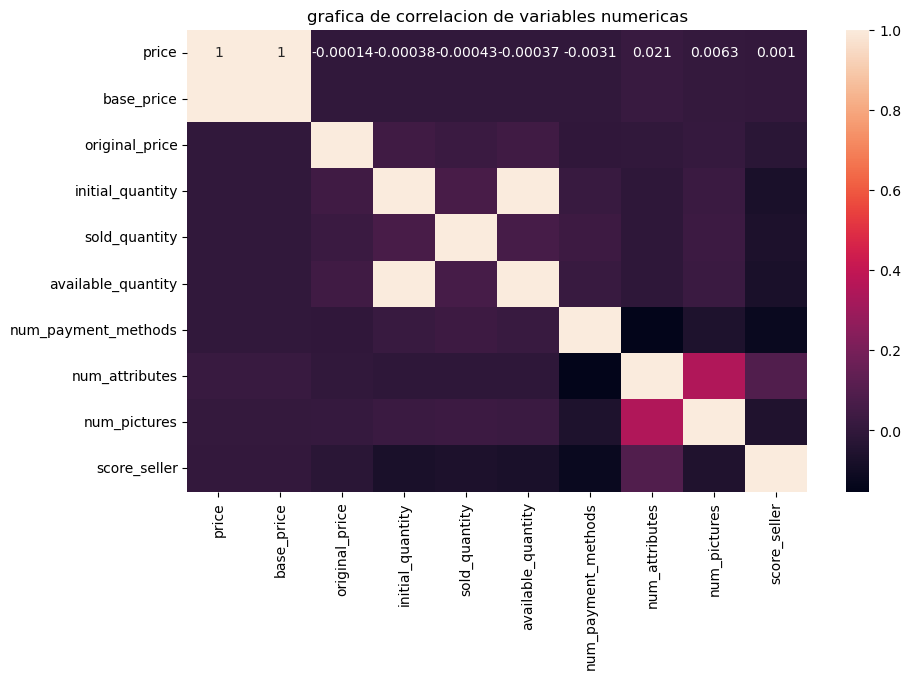

In [255]:
cols_numeric = ["price","base_price","original_price", "initial_quantity", "sold_quantity", "available_quantity",       
       "num_payment_methods", "num_attributes", "num_pictures", "score_seller"]

cols_binary = [x for x in df.columns.values if x not in cols_numeric]

df_corr = df_EDA[cols_numeric].corr()
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_corr, annot=True, ax=ax)
ax.set_title("grafica de correlacion de variables numericas")

In [256]:
df_desc = pd.DataFrame(((df_EDA["initial_quantity"].fillna(0) - df_EDA["available_quantity"].fillna(0))==0).astype(int), 
                       columns=["valores_iguales"])

df_desc = pd.DataFrame(df_desc.value_counts())
df_desc["porcentaje_del_total"] = df_desc/df_EDA.shape[0]
df_desc

count  porcentaje_del_total
valores_iguales                             
1                85983              0.955367
0                 4017              0.044633

**Transformacion**

In [257]:
df_EDA["flg_intial_equals_available_quantity"] = ((df_EDA["initial_quantity"].fillna(0) - df_EDA["available_quantity"].fillna(0))==0).astype(int)
df_EDA = df_EDA.drop(columns=["available_quantity"])

## EDA
Con las variables ya transformadas se procede a hacer el analisis descriptivo de todas las variables preseleccionadas y transformadas, adicionalmente se ve la comparacion vs la variable objetivo **condition**.

### Variable Objetivo
Esta variable indica si el producto es nuevo(new) y usado(used), se ve una distribucion balanceada entre las dos variables. para usarlas en el modelo de clasificador binario se transforma la varaible condition a numerico binario, en donde 

<center>

| valores binarios | interpretacion |
|------------------|----------------|
| 1                |      used      |
| 0                |      new       |

</center>

condition  cantidad_registros  porcentaje
0       new               48352       53.72
1      used               41648       46.28

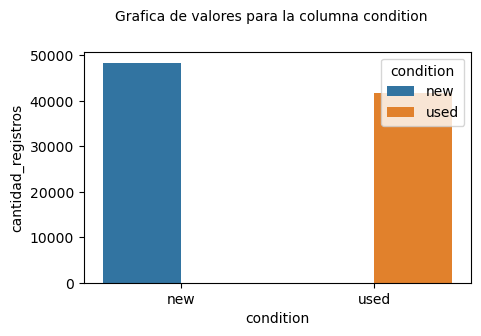

In [258]:
descr_categorico(df_EDA,"condition",is_target=True)

### Variables

#### Categoricas y binarias

In [259]:
def describe_var_categorica_basico(df_EDA,col):
    df_nulos = cantidad_distintos_nulo(df_EDA,[col])
    display(df_nulos)
    print("Distribucion variable")
    descr_categorico(df_EDA,col,"condition")

##### Warranty

Esta variable indica si el producto cuenta con un mensaje de garantia.

- No se considera que este desbalanceada 
- Es evidente una diferencia entre las proporciones para las categorias nuevo y usado

cantidad_valores_nulos  pct_valores_nulos
warranty                       0                0.0

Distribucion variable


warranty  cantidad_registros  porcentaje
0         0               54757       60.84
1         1               35243       39.16

warranty condition  cantidad_registros  porcentaje
0         0       new               26475       48.35
1         0      used               28282       51.65
2         1       new               21877       62.07
3         1      used               13366       37.93

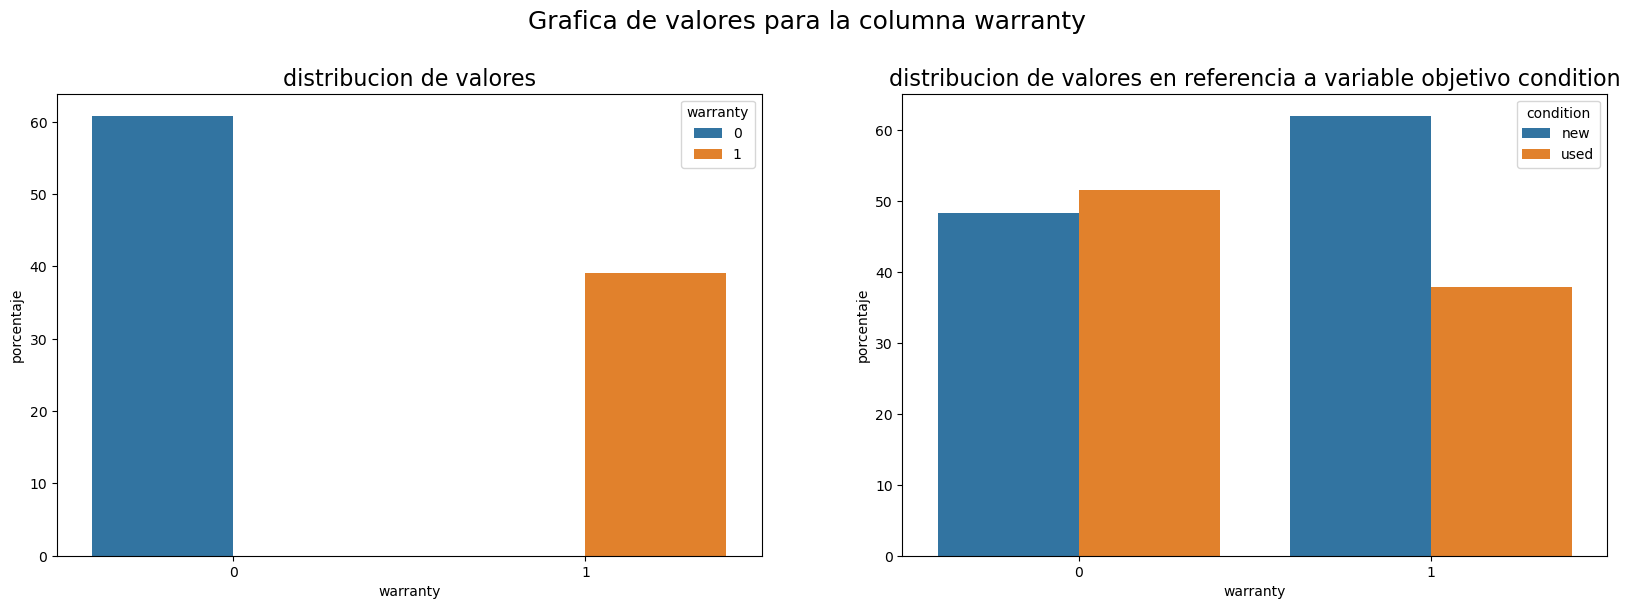

In [260]:
describe_var_categorica_basico(df_EDA,"warranty")

##### listing_type_id

Esta variable indica la categoria asociada al producto, se transformo a variable ordinal para que se pueda utilizar en el modelo de clasificacion, esta variable indica niveles de exposicion del producto entre mas alto es mejor

- Se evidencia una tendencia a tener niveles mas bajos
- La proporcion de productos usados en cada categoria, disminuye a medida que aumenta el nivel

cantidad_valores_nulos  pct_valores_nulos
listing_type_id                       0                0.0

Distribucion variable


listing_type_id  cantidad_registros  porcentaje
1                1               56904       63.23
0                0               19260       21.40
2                2                8195        9.11
5                5                2693        2.99
3                3                2170        2.41
4                4                 765        0.85
6                6                  13        0.01

listing_type_id condition  cantidad_registros  porcentaje
0                 0       new                1428        7.41
1                 0      used               17832       92.59
2                 1       new               35410       62.23
3                 1      used               21494       37.77
4                 2       new                6575       80.23
5                 2      used                1620       19.77
6                 3       new                1869       86.13
7                 3      used                 301       13.87
8                 4       new                 416       54.38
9                 4      used                 349       45.62
10                5       new                2641       98.07
11                5      used                  52        1.93
12                6       new                  13      100.00

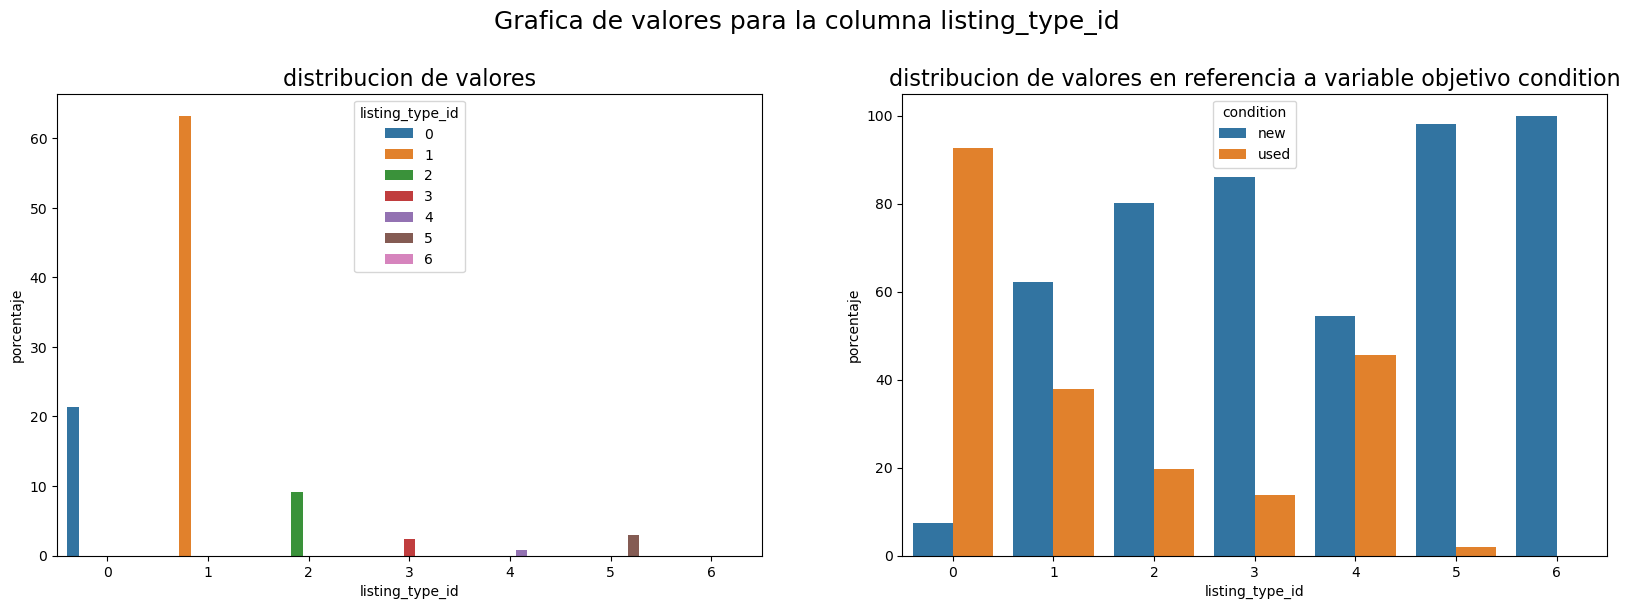

In [261]:
describe_var_categorica_basico(df_EDA,"listing_type_id")

##### parent_item_id

Esta variable indica si el producto tiene un producto padre asociado.

- Se evidencia una mayor presencia de productos con padre
- La proporcion de productos usados para cada categoria no difiere de forma significativa

cantidad_valores_nulos  pct_valores_nulos
parent_item_id                       0                0.0

Distribucion variable


parent_item_id  cantidad_registros  porcentaje
1               1               69310       77.01
0               0               20690       22.99

parent_item_id condition  cantidad_registros  porcentaje
0               0       new               11431       55.25
1               0      used                9259       44.75
2               1       new               36921       53.27
3               1      used               32389       46.73

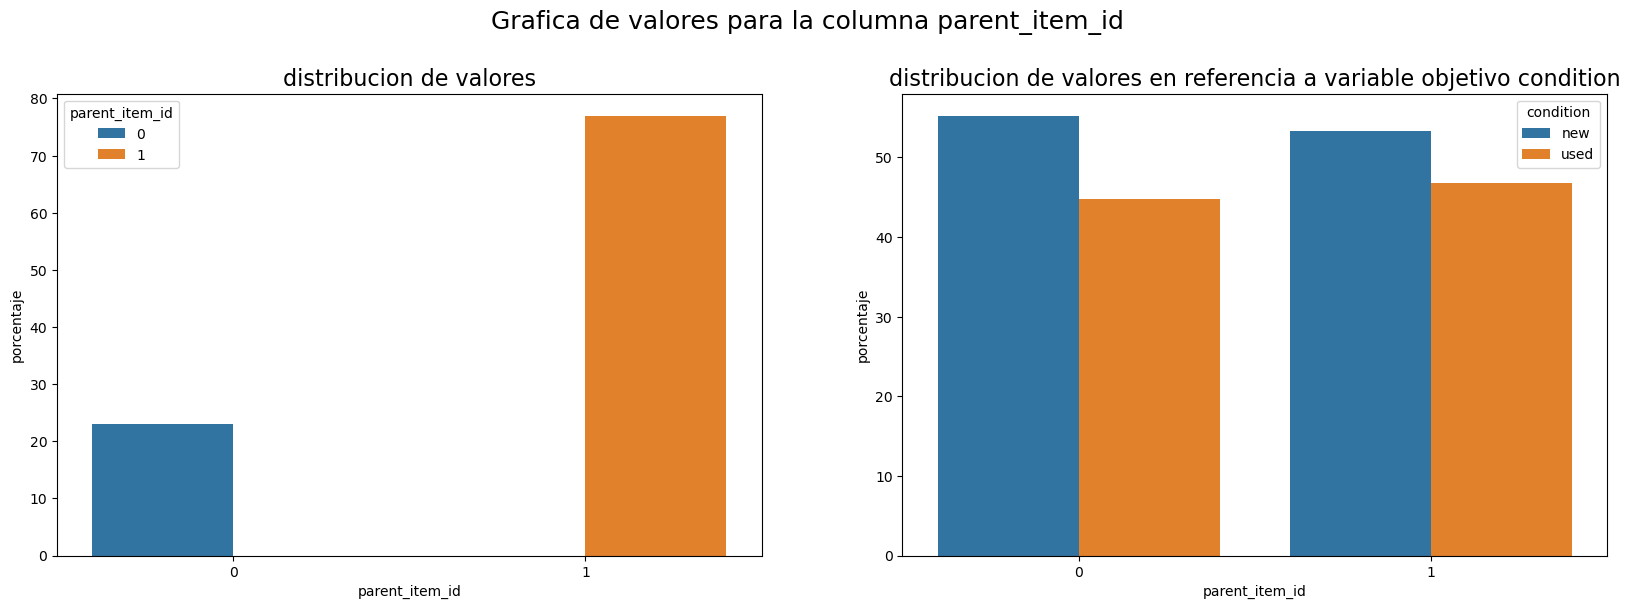

In [262]:
describe_var_categorica_basico(df_EDA,"parent_item_id")

##### official_store_id

Esta variable indica si el producto esta publicado o asociado a una tienda oficial de mercado libre.

- hay pocos registros marcados como tiendas oficiales
- La cantidad de productos nuevos vendidos es mas alto en las tiendas oficiales

cantidad_valores_nulos  pct_valores_nulos
official_store_id                       0                0.0

Distribucion variable


official_store_id  cantidad_registros  porcentaje
0                  0               89255       99.17
1                  1                 745        0.83

official_store_id condition  cantidad_registros  porcentaje
0                  0       new               47628       53.36
1                  0      used               41627       46.64
2                  1       new                 724       97.18
3                  1      used                  21        2.82

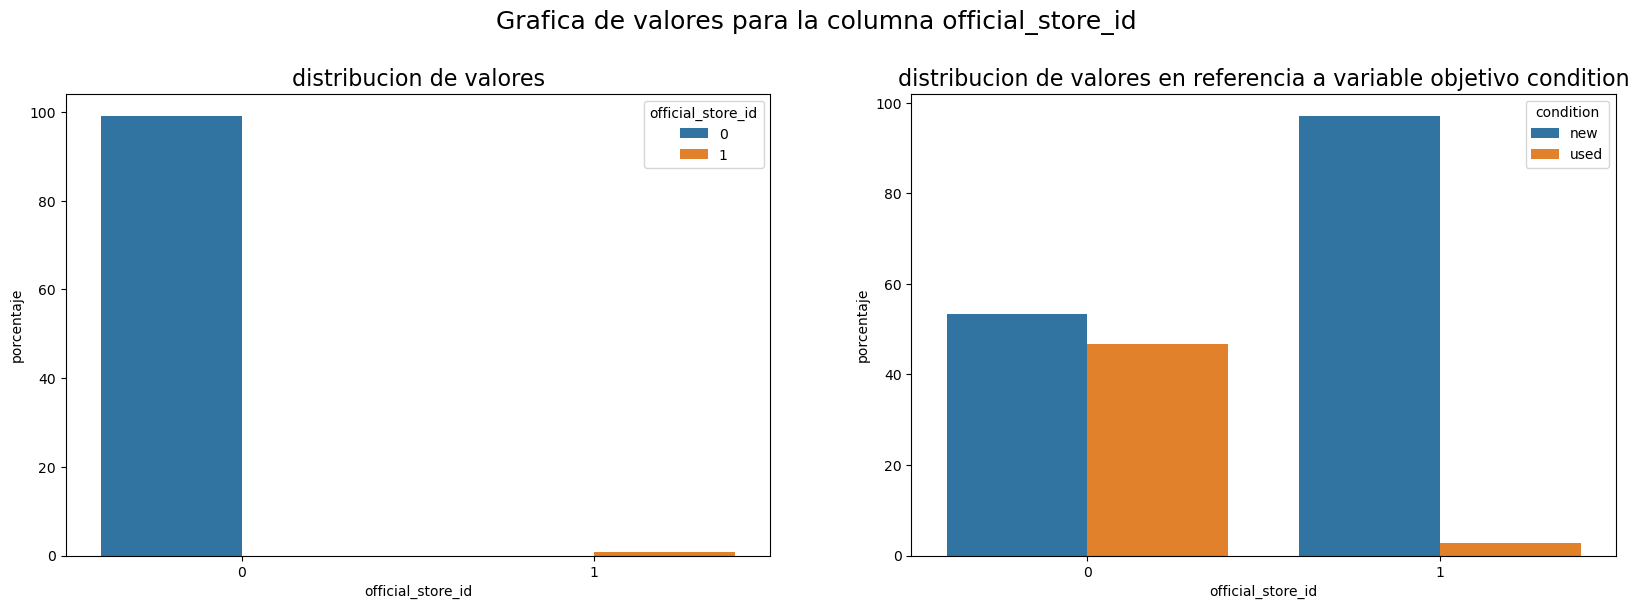

In [263]:
describe_var_categorica_basico(df_EDA,"official_store_id")

##### accepts_mercadopago

Esta variable indica si el vendedor del producto acepta mercadopago.

- hay pocos productos que no aceptan mercado pago
- La cantidad de productos usados vendidos es mas alto para aquellos que no aceptan mercado pago

cantidad_valores_nulos  pct_valores_nulos
accepts_mercadopago                       0                0.0

Distribucion variable


accepts_mercadopago  cantidad_registros  porcentaje
1                    1               88018        97.8
0                    0                1982         2.2

accepts_mercadopago condition  cantidad_registros  porcentaje
0                    0       new                 455       22.96
1                    0      used                1527       77.04
2                    1       new               47897       54.42
3                    1      used               40121       45.58

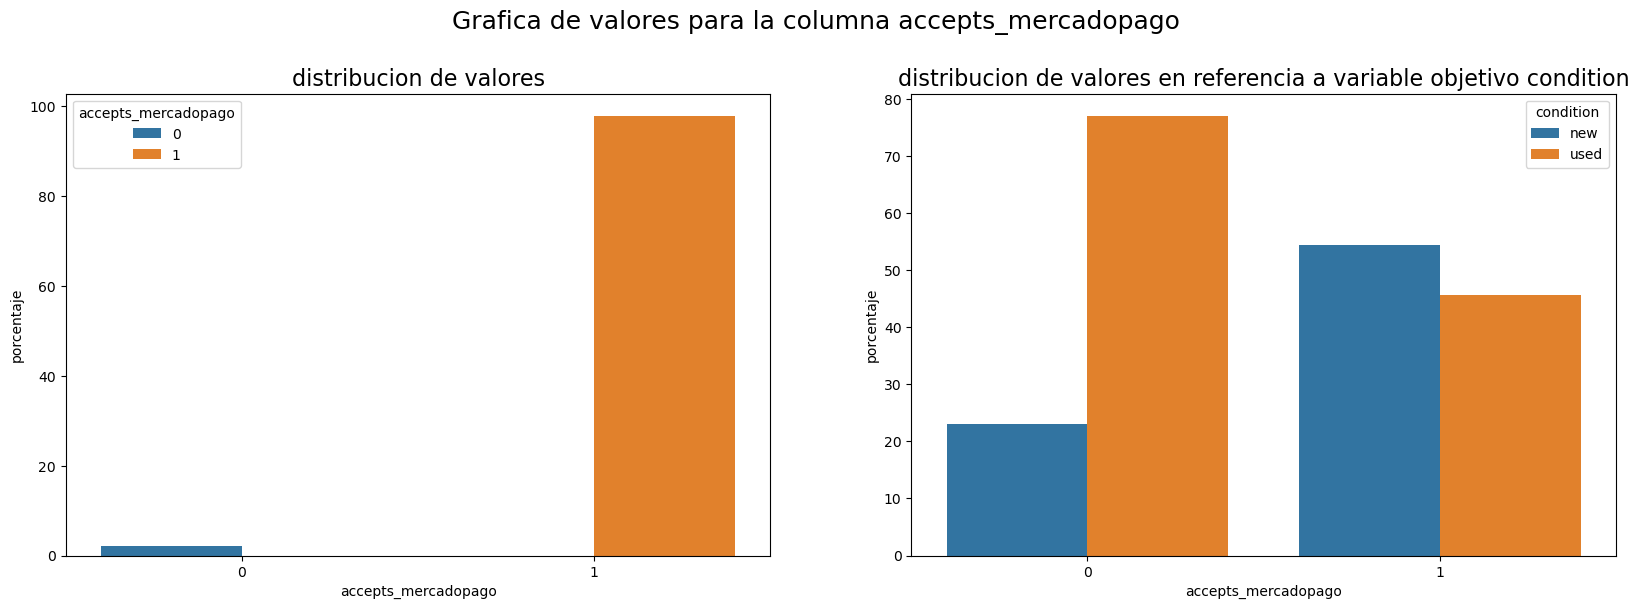

In [264]:
describe_var_categorica_basico(df_EDA,"accepts_mercadopago")

##### automatic_relist 
Esta variable indica si el producto fue creado a partir de la informacion de un producto cerrado.
[referencia meli](https://developers.mercadolibre.com.ar/en_us/relist-items#)

- hay pocos productos que tienen activo el relist automatico
- La cantidad de productos usados vendidos es mas alto para aquellos que tienen activo el relist automatico

cantidad_valores_nulos  pct_valores_nulos
automatic_relist                       0                0.0

Distribucion variable


automatic_relist  cantidad_registros  porcentaje
0                 0               85773        95.3
1                 1                4227         4.7

automatic_relist condition  cantidad_registros  porcentaje
0                 0       new               44313       51.66
1                 0      used               41460       48.34
2                 1       new                4039       95.55
3                 1      used                 188        4.45

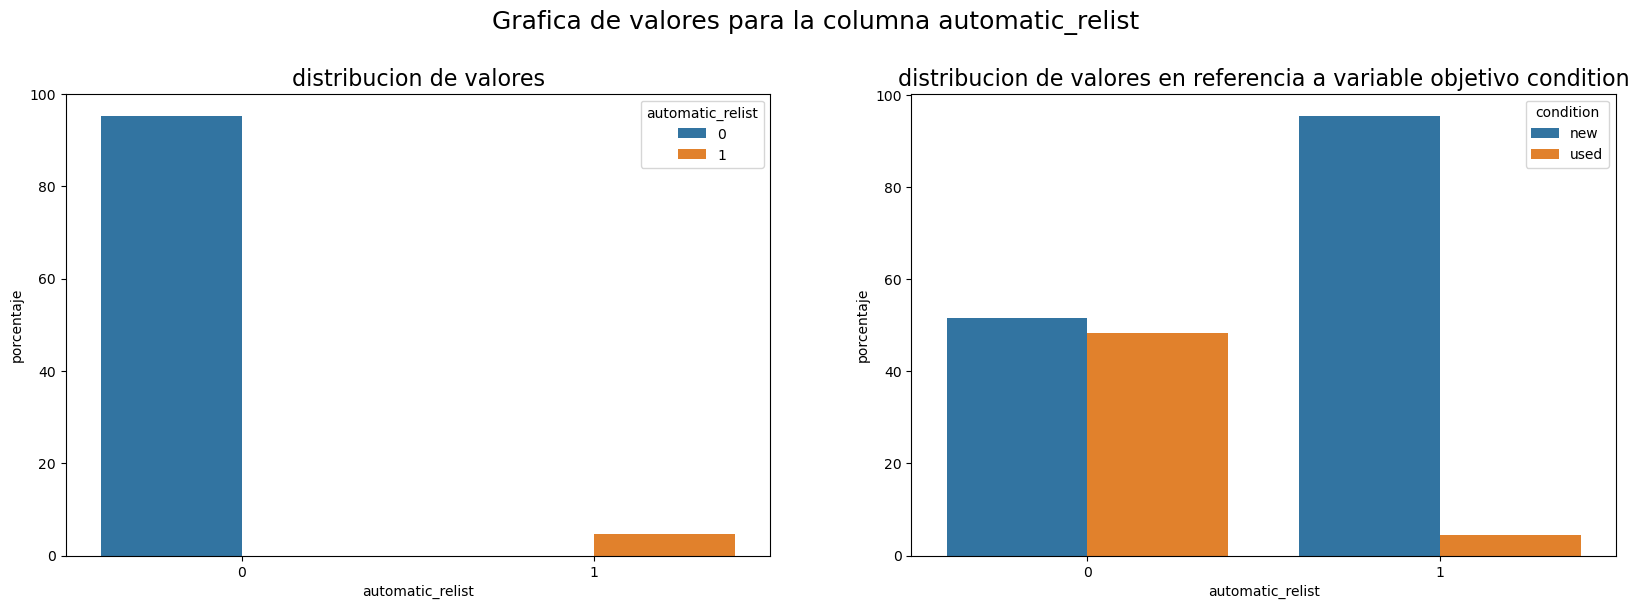

In [265]:
describe_var_categorica_basico(df_EDA,"automatic_relist")

##### video_id 
Esta variable indica si la publicacion del video tiene un video adjunto.

- hay pocos productos que tienen un video adjunto
- La cantidad de productos nuevos vendidos es mas alto para aquellos que tienen un video adjunto

cantidad_valores_nulos  pct_valores_nulos
video_id                       0                0.0

Distribucion variable


video_id  cantidad_registros  porcentaje
0         0               87324       97.03
1         1                2676        2.97

video_id condition  cantidad_registros  porcentaje
0         0       new               46287       53.01
1         0      used               41037       46.99
2         1       new                2065       77.17
3         1      used                 611       22.83

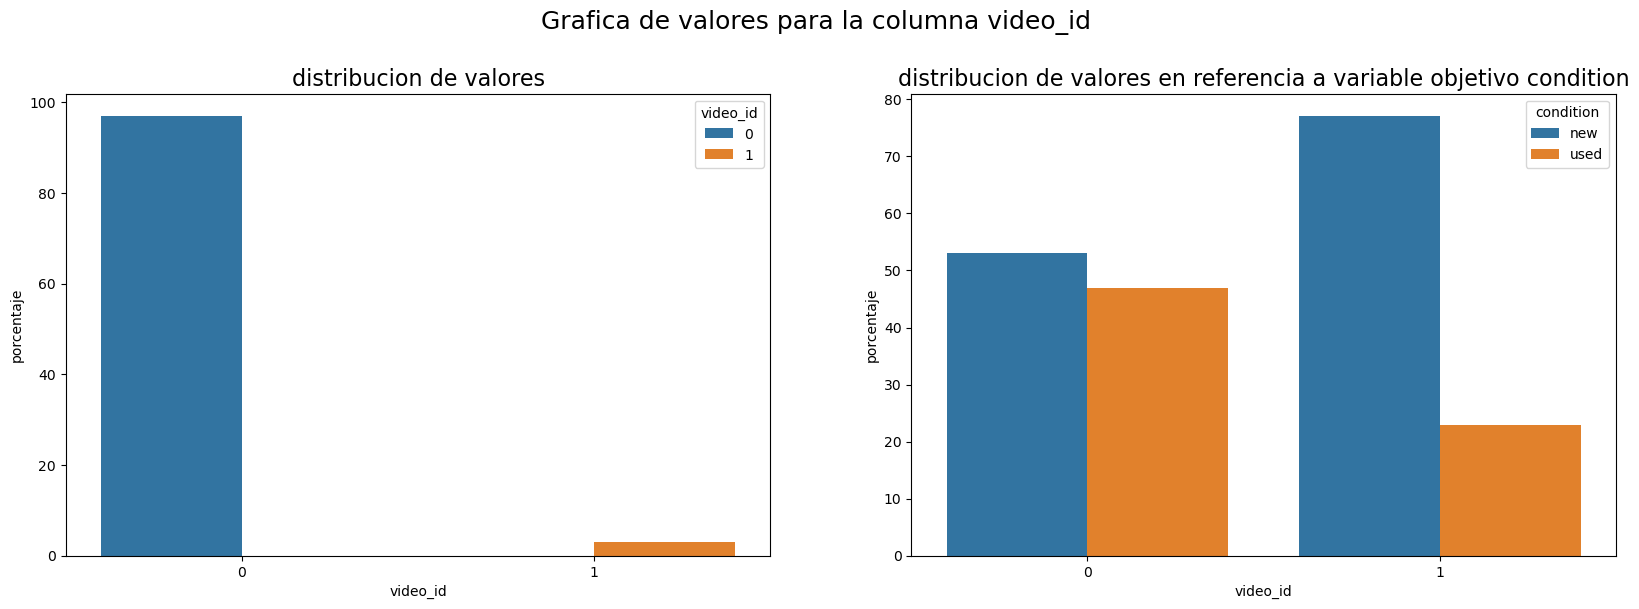

In [266]:
describe_var_categorica_basico(df_EDA,"video_id")

##### shipping_local_pick_up 
Esta variable indica si el producto ofertado tiene la opcion de retirarlo en una locacion.

- la mayoria de productos tienen activo la opcion de local pick up
- La cantidad de productos nuevos y usados es uniforme en ambas categorias.

cantidad_valores_nulos  pct_valores_nulos
shipping_local_pick_up                       0                0.0

Distribucion variable


shipping_local_pick_up  cantidad_registros  porcentaje
1                       1               71577       79.53
0                       0               18423       20.47

shipping_local_pick_up condition  cantidad_registros  porcentaje
0                       0       new                9138       49.60
1                       0      used                9285       50.40
2                       1       new               39214       54.79
3                       1      used               32363       45.21

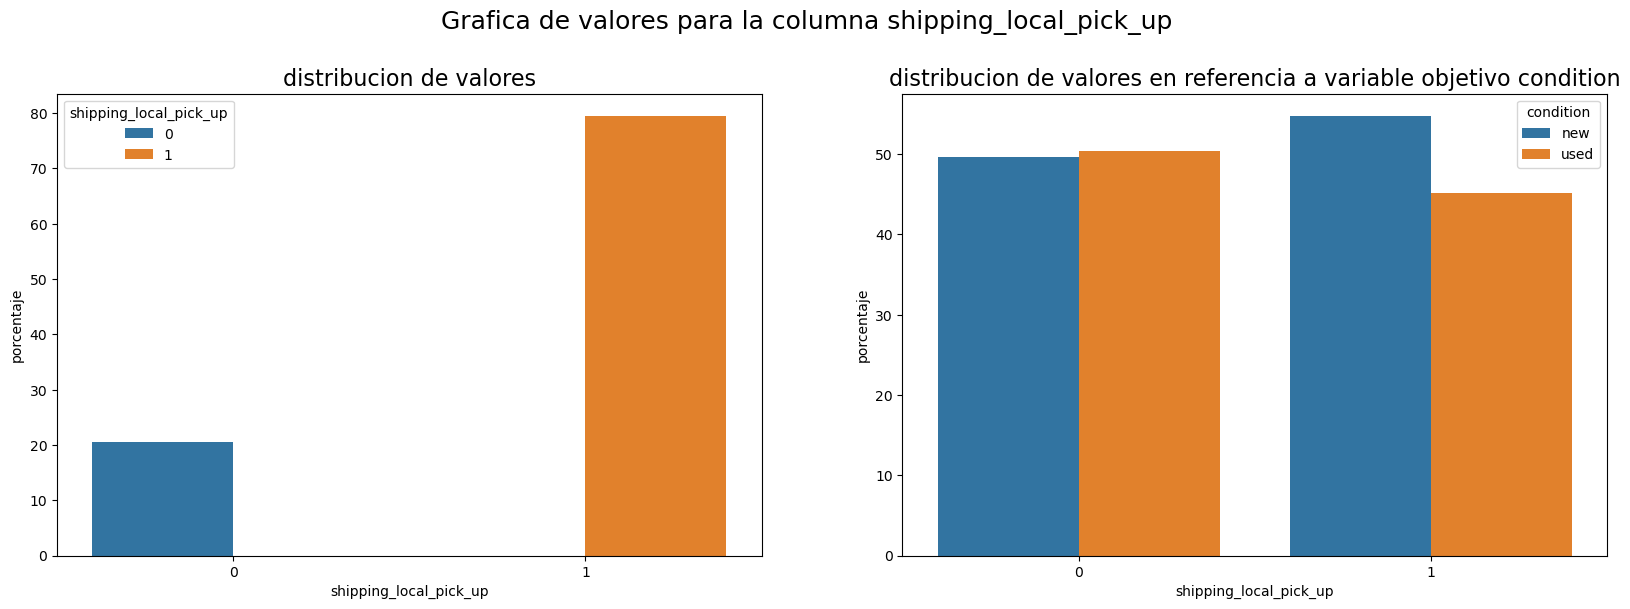

In [267]:
describe_var_categorica_basico(df_EDA,"shipping_local_pick_up")

##### shipping_free_shipping 
Esta variable indica si el producto ofertado tiene la opcion de envio gratuito.

- la mayoria de productos no tienen la opcion de local free shipping
- La cantidad de productos nuevos es mayor para aquellos productos con free shipping.

cantidad_valores_nulos  pct_valores_nulos
shipping_free_shipping                       0                0.0

Distribucion variable


shipping_free_shipping  cantidad_registros  porcentaje
0                       0               87303        97.0
1                       1                2697         3.0

shipping_free_shipping condition  cantidad_registros  porcentaje
0                       0       new               45851       52.52
1                       0      used               41452       47.48
2                       1       new                2501       92.73
3                       1      used                 196        7.27

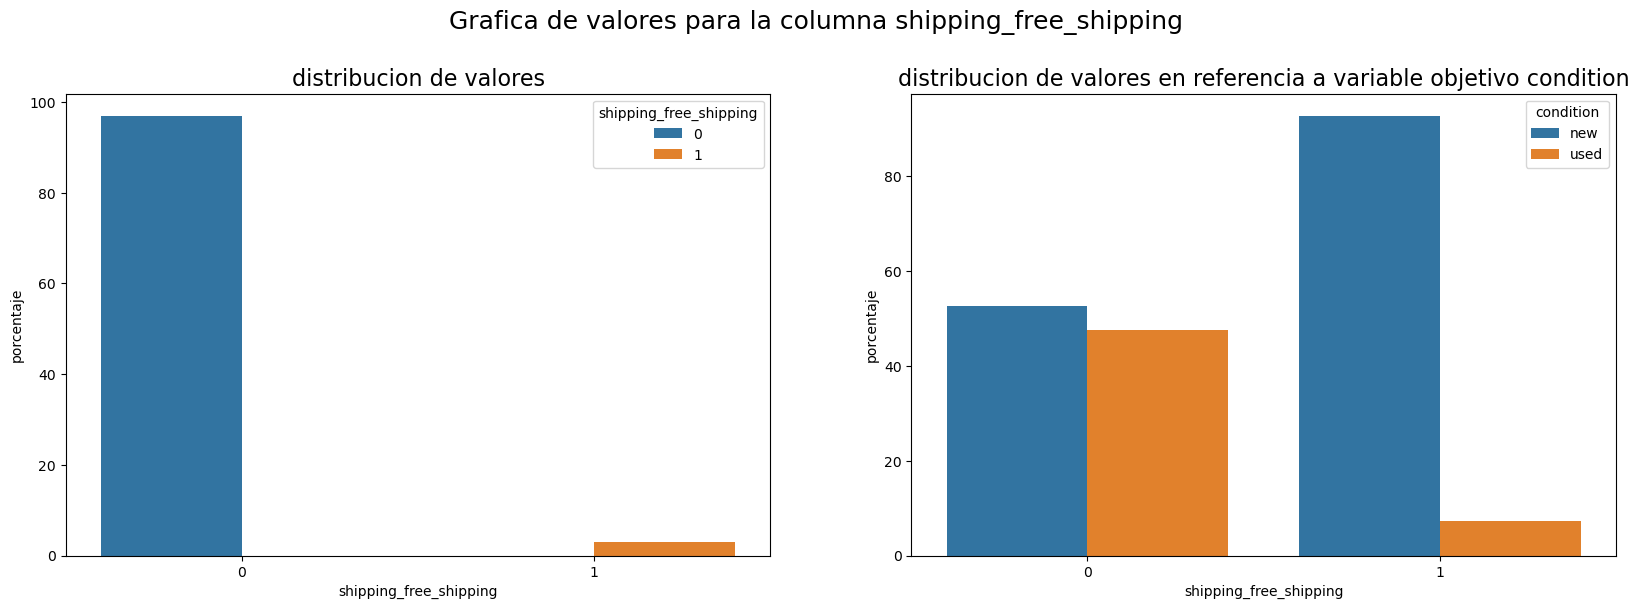

In [268]:
describe_var_categorica_basico(df_EDA,"shipping_free_shipping")

##### flg_buy_it_now 
Esta variable indica si el tiene activa la opcion de buy it now

- la mayoria de productos tienen la opcion de buy it now
- La cantidad de productos usados es mayor para aquellos productos sin la opcion.

cantidad_valores_nulos  pct_valores_nulos
flg_buy_it_now                       0                0.0

Distribucion variable


flg_buy_it_now  cantidad_registros  porcentaje
1               1               87311       97.01
0               0                2689        2.99

flg_buy_it_now condition  cantidad_registros  porcentaje
0               0       new                 683        25.4
1               0      used                2006        74.6
2               1       new               47669        54.6
3               1      used               39642        45.4

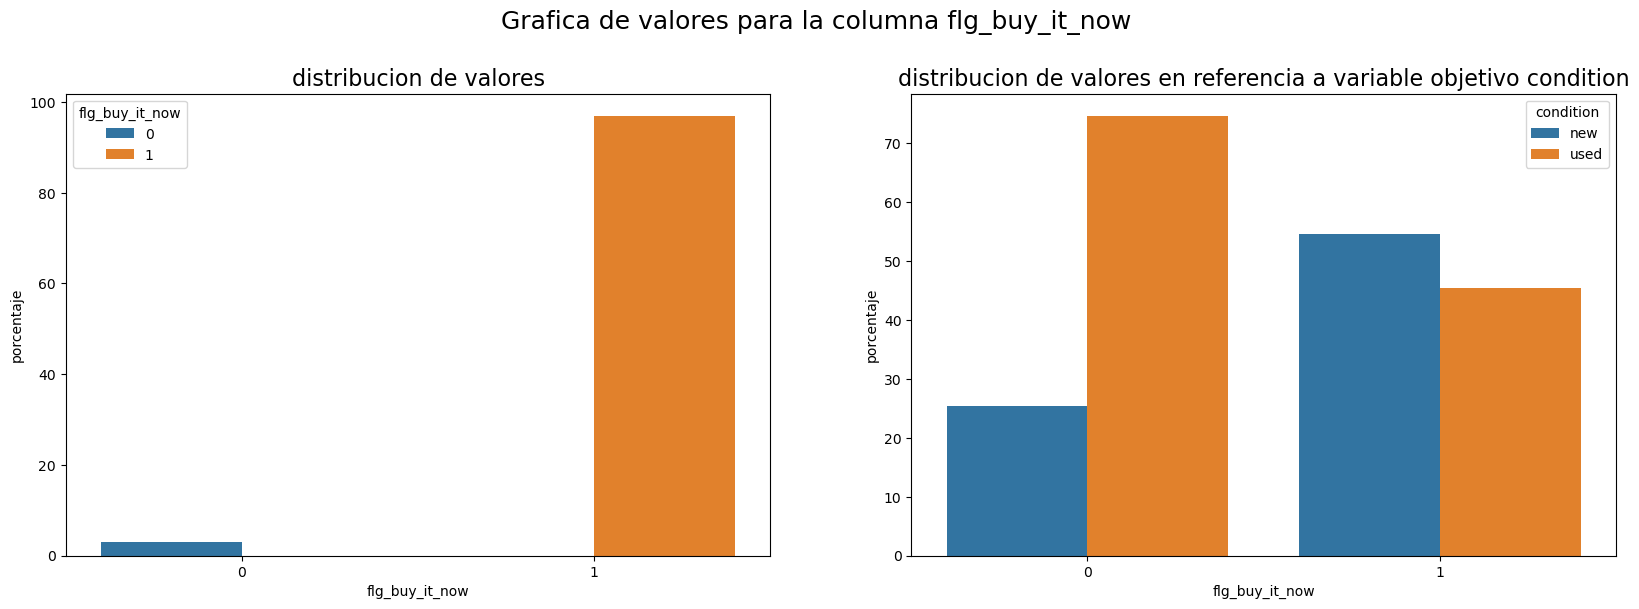

In [269]:
describe_var_categorica_basico(df_EDA,"flg_buy_it_now")

##### flg_is_capital_city 
Esta variable indica si la venta del producto esta asociada a la capital de argentina

- la mayoria de productos se venden en la capital de argentina
- La proporcion de productos usados y nuevos es similar en ambas categorias.

cantidad_valores_nulos  pct_valores_nulos
flg_is_capital_city                       0                0.0

Distribucion variable


flg_is_capital_city  cantidad_registros  porcentaje
1                    1               52143       57.94
0                    0               37857       42.06

flg_is_capital_city condition  cantidad_registros  porcentaje
0                    0       new               20292       53.60
1                    0      used               17565       46.40
2                    1       new               28060       53.81
3                    1      used               24083       46.19

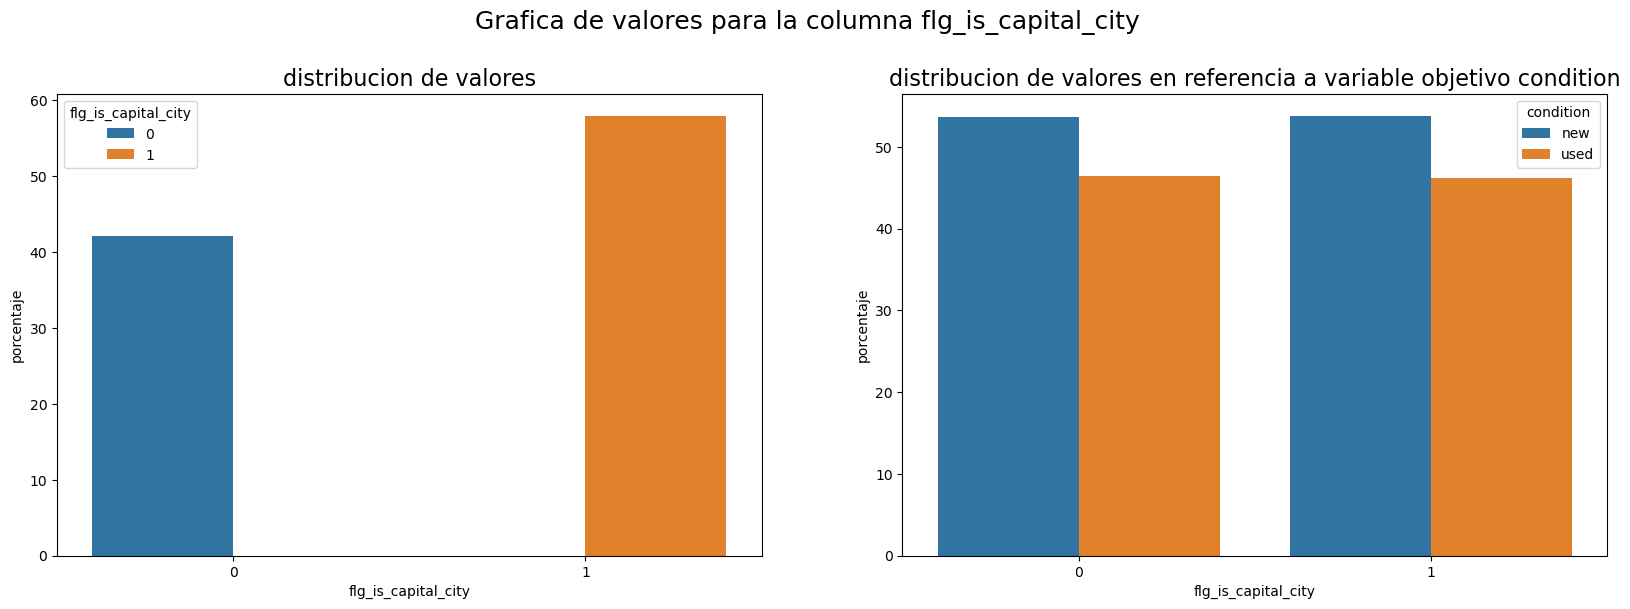

In [270]:
describe_var_categorica_basico(df_EDA,"flg_is_capital_city")

##### flg_ship_not_specified 
([referencia meli](https://developers.mercadolibre.com.ec/mercado-envios))
Esta variable indica si el tipo de envio no esta especificado 

- la mayoria de productos tienen especifucado el tipo de envio
- La proporcion de productos nuevos es en los productos que tienen especificado el tipo de envio son mayores

cantidad_valores_nulos  pct_valores_nulos
flg_ship_not_specified                       0                0.0

Distribucion variable


flg_ship_not_specified  cantidad_registros  porcentaje
0                       0               49275       54.75
1                       1               40725       45.25

flg_ship_not_specified condition  cantidad_registros  porcentaje
0                       0       new               28470       57.78
1                       0      used               20805       42.22
2                       1       new               19882       48.82
3                       1      used               20843       51.18

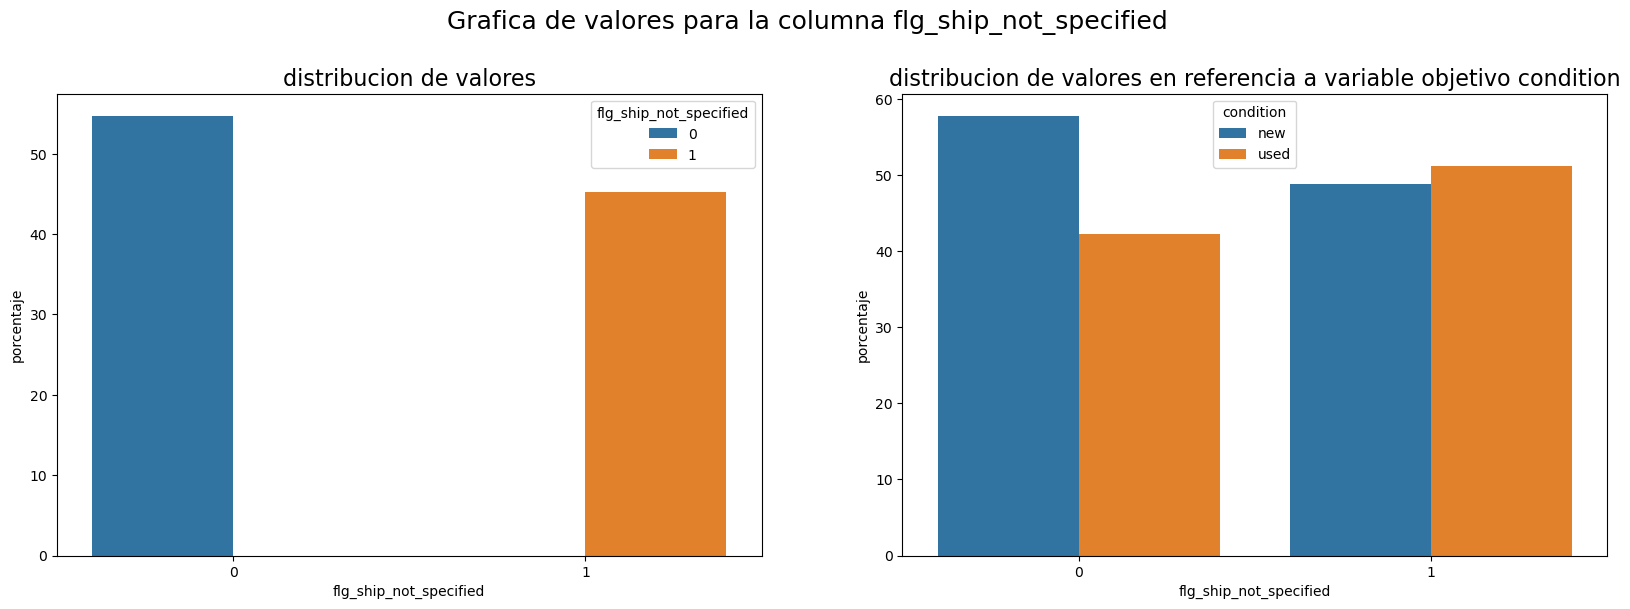

In [271]:
describe_var_categorica_basico(df_EDA,"flg_ship_not_specified")

##### flg_inmobiliario 
Esta variable indica si el producto es del tipo inmobiliario

- la mayoria de productos no es del tipo inmobiliario
- La proporcion de productos nuevos y usados es similar para los tipos de productos

cantidad_valores_nulos  pct_valores_nulos
flg_inmobiliario                       0                0.0

Distribucion variable


flg_inmobiliario  cantidad_registros  porcentaje
0                 0               89661       99.62
1                 1                 339        0.38

flg_inmobiliario condition  cantidad_registros  porcentaje
0                 0       new               48163       53.72
1                 0      used               41498       46.28
2                 1       new                 189       55.75
3                 1      used                 150       44.25

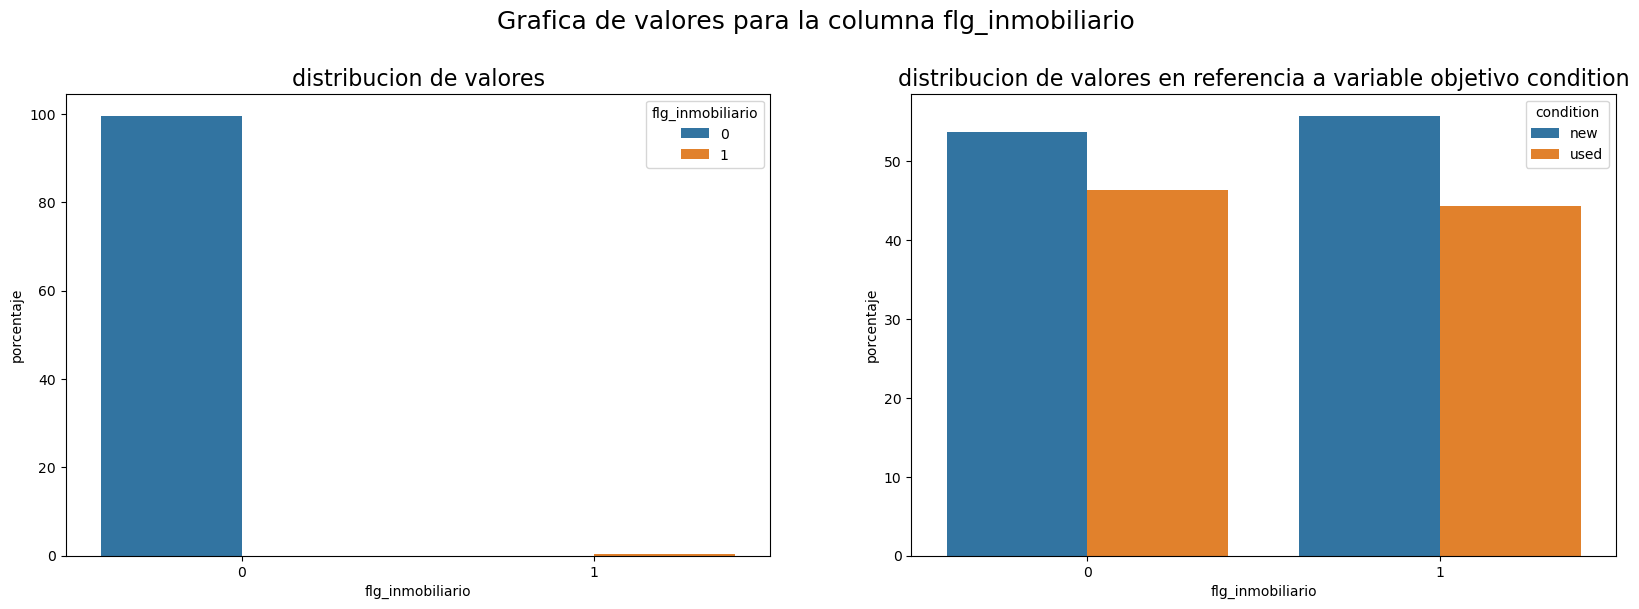

In [272]:
describe_var_categorica_basico(df_EDA,"flg_inmobiliario")

##### variation_base_price 
Esta variable indica si el precio listado es mayor, menor o igual al base_price

- es una variable hegemonica donde la mayoria de los casos es igual a 0, dando a si la idea de que es igual a la variable price
- price es mayor o igual en todos los casos
- La proporcion de productos nuevos y usados es similar en cada categoria

luego de ver su alta correlacion y el comportamiento de esta variable se determina que no suminsitra mayor valor, se decide <span style="color: red;">**eliminar del dataset final**</span>

cantidad_valores_nulos  pct_valores_nulos
variation_base_price                       0                0.0

Distribucion variable


variation_base_price  cantidad_registros  porcentaje
0                   0.0               89974       99.97
1                   1.0                  26        0.03

variation_base_price condition  cantidad_registros  porcentaje
0                   0.0       new               48337       53.72
1                   0.0      used               41637       46.28
2                   1.0       new                  15       57.69
3                   1.0      used                  11       42.31

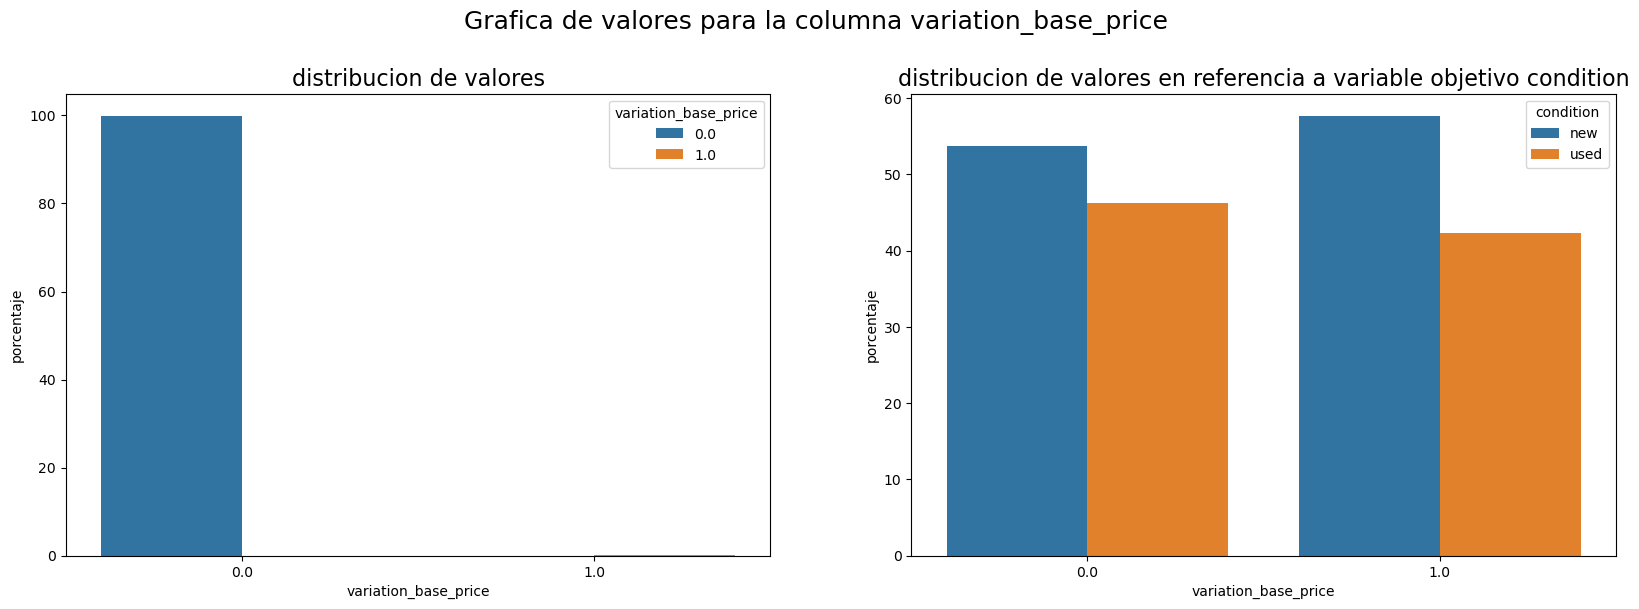

In [273]:
describe_var_categorica_basico(df_EDA,"variation_base_price")

##### variation_original_price 
Esta variable indica si el precio listado es mayor, menor o igual al origina_price

- price es menor o igual en todos los casos, sin embargo son pocos casos
- para este set de datos el 100% de los productos con diferencia son nuevos, sin embargo esta conclusion es apresurada dada la baja cantidad de registros con diferencias

cantidad_valores_nulos  pct_valores_nulos
variation_original_price                       0                0.0

Distribucion variable


variation_original_price  cantidad_registros  porcentaje
1                       0.0               89873       99.86
0                      -1.0                 127        0.14

variation_original_price condition  cantidad_registros  porcentaje
0                      -1.0       new                 127      100.00
1                       0.0       new               48225       53.66
2                       0.0      used               41648       46.34

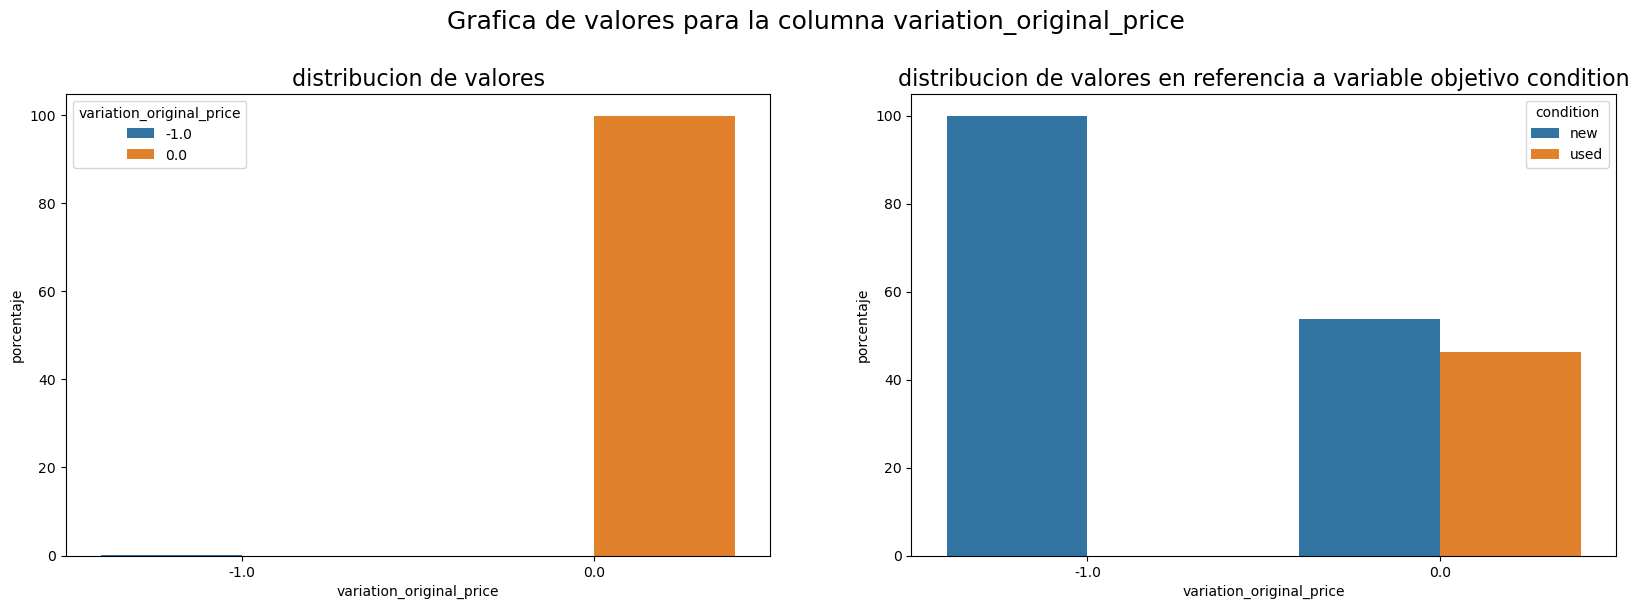

In [274]:
describe_var_categorica_basico(df_EDA,"variation_original_price")

##### MercadoPago 
Esta variable indica si el anunciante acepta mercadoPago como metodo de pago para el producto ofertado

- la gran mayoria de anunciantes no aceptan mercadoPago
- el 100% de anunciantes que aceptan mercadopago venden productos nuevos

cantidad_valores_nulos  pct_valores_nulos
MercadoPago                       0                0.0

Distribucion variable


MercadoPago  cantidad_registros  porcentaje
0          0.0               89354       99.28
1          1.0                 646        0.72

MercadoPago condition  cantidad_registros  porcentaje
0          0.0       new               47706       53.39
1          0.0      used               41648       46.61
2          1.0       new                 646      100.00

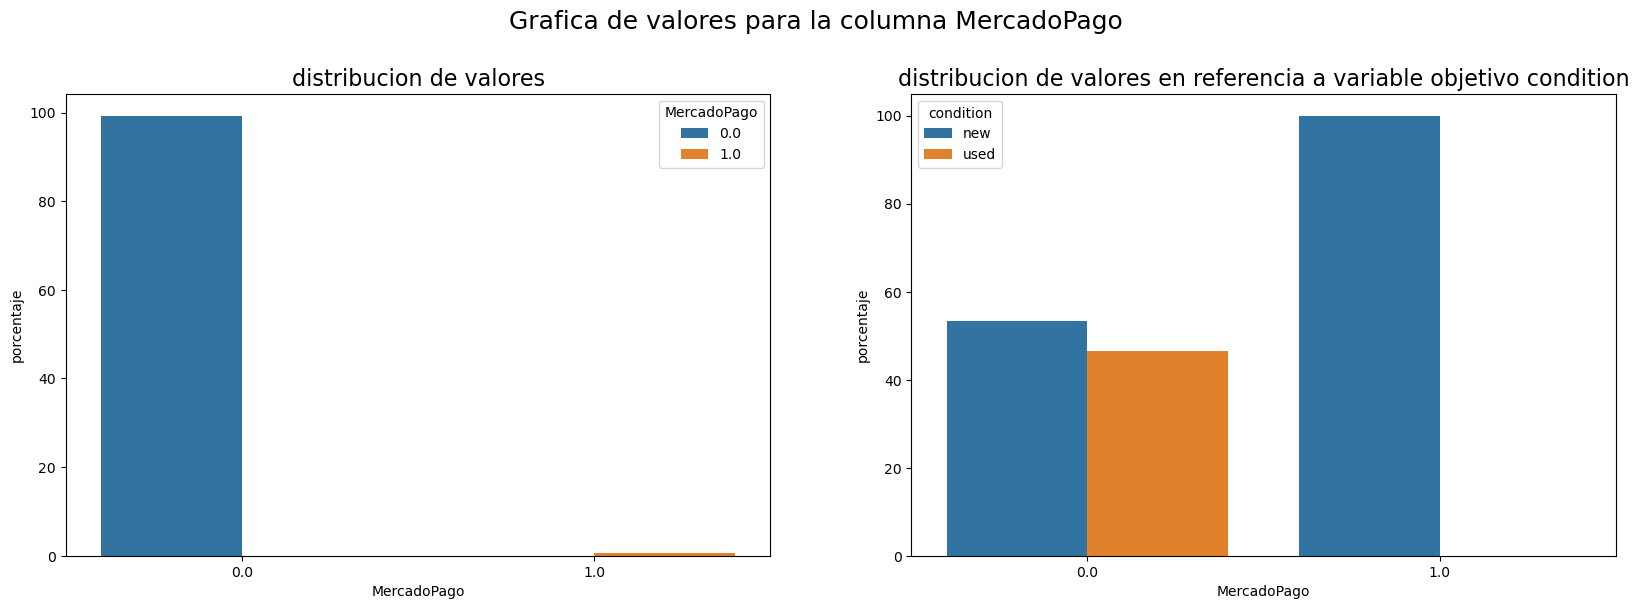

In [275]:
describe_var_categorica_basico(df_EDA,"MercadoPago")

##### cheque 
Esta variable indica si el anunciante acepta cheque como metodo de pago para el producto ofertado

- la gran mayoria de anunciantes no aceptan cheque
- la proporcion de usados es mayor para aquellos que aceptan cheque como medio de pago

cantidad_valores_nulos  pct_valores_nulos
cheque                       0                0.0

Distribucion variable


cheque  cantidad_registros  porcentaje
0     0.0               89588       99.54
1     1.0                 412        0.46

cheque condition  cantidad_registros  porcentaje
0     0.0       new               48271       53.88
1     0.0      used               41317       46.12
2     1.0       new                  81       19.66
3     1.0      used                 331       80.34

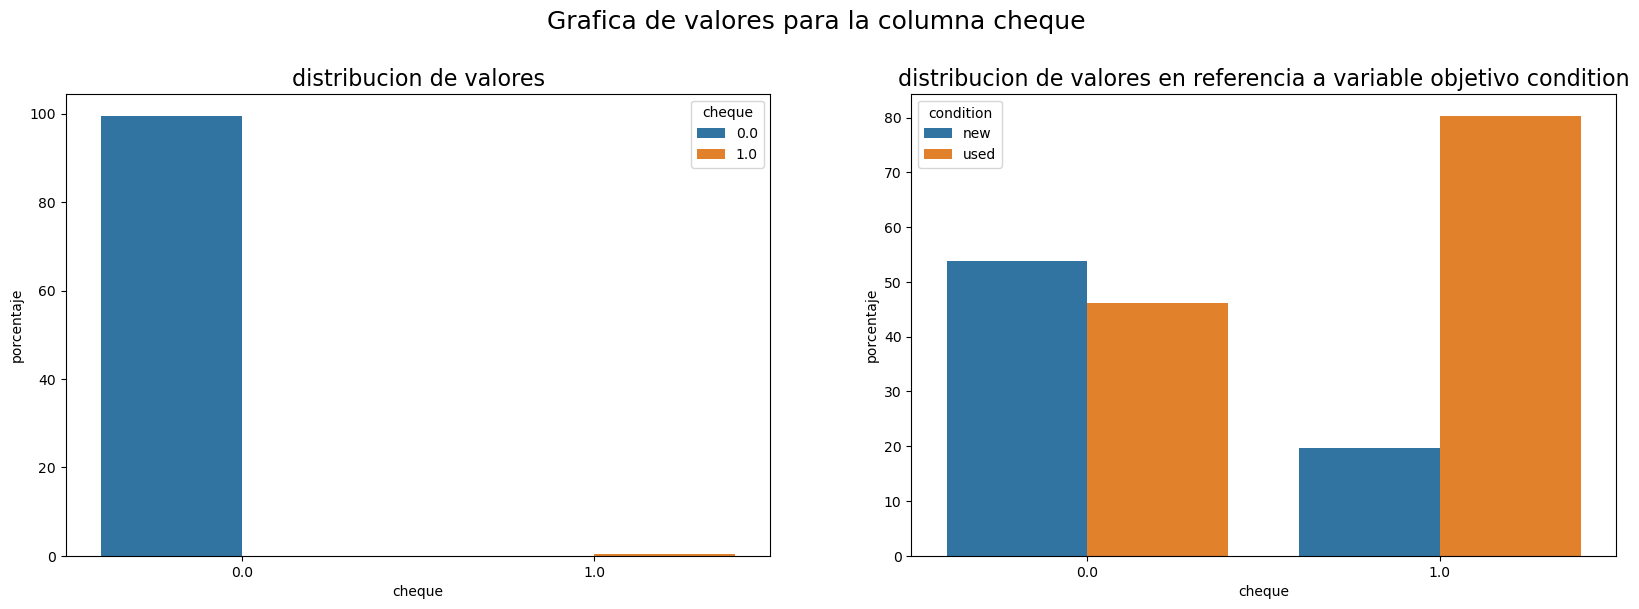

In [276]:
describe_var_categorica_basico(df_EDA,"cheque")

##### contra_reembolso 
Esta variable indica si el anunciante acepta contra_reembolso como metodo de pago para el producto ofertado

- la gran mayoria de anunciantes no aceptan contra_reembolso
- la proporcion de usados y nuevos es similar para ambas categorias

cantidad_valores_nulos  pct_valores_nulos
contra_reembolso                       0                0.0

Distribucion variable


contra_reembolso  cantidad_registros  porcentaje
0               0.0               89430       99.37
1               1.0                 570        0.63

contra_reembolso condition  cantidad_registros  porcentaje
0               0.0       new               48081       53.76
1               0.0      used               41349       46.24
2               1.0       new                 271       47.54
3               1.0      used                 299       52.46

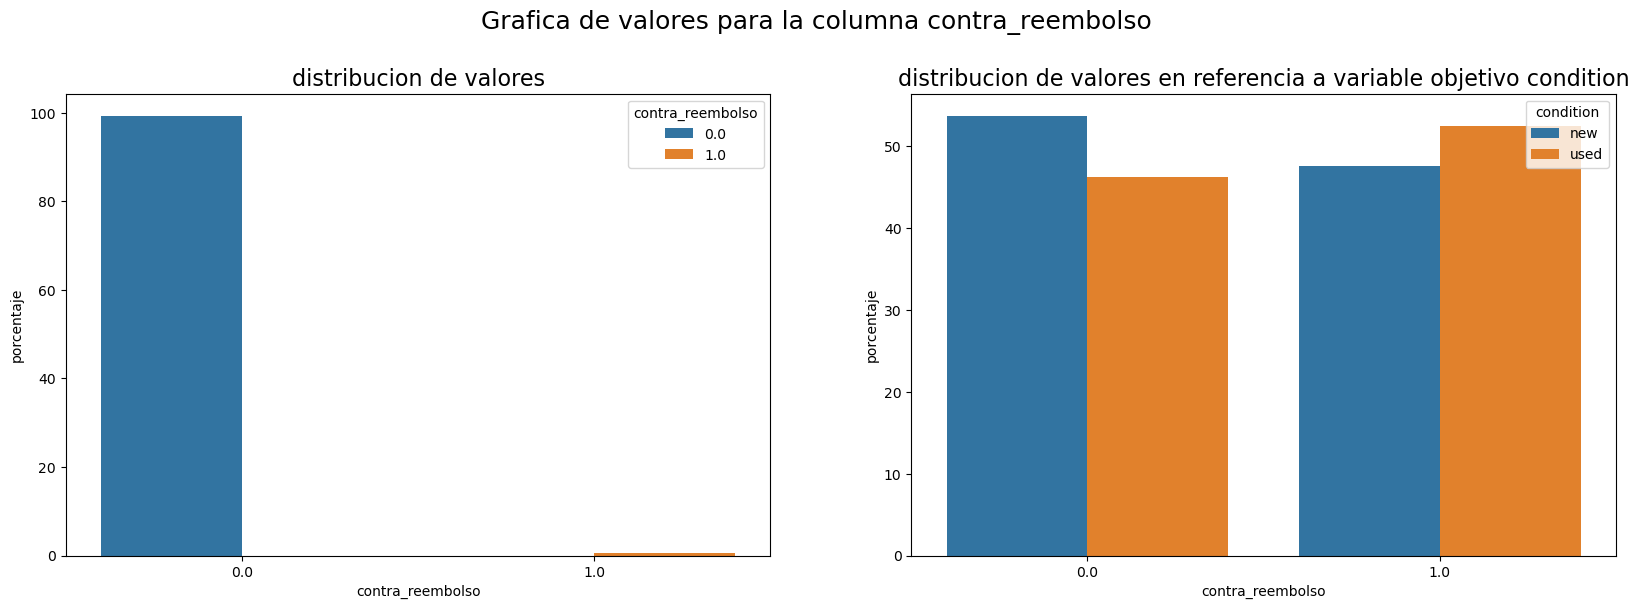

In [277]:
describe_var_categorica_basico(df_EDA,"contra_reembolso")

##### efectivo_o_acuerdo 
Esta variable indica si el anunciante acepta efectivo_o_acuerdo como metodo de pago para el producto ofertado, esta variable tiene un rango [0,2] ya que un producto puede aceptar tanto fectivo o a travez de un acuerdo convenir un metodo de pago

- la gran mayoria de anunciantes aceptan alguno de estos metodos de pago
- si solo acepta uno de los metodos de pago, la proporcion de productos nuevos vendidos es mayor
- si acepta ambos metodos de pago la proporcion de productos usados vendidos es mayor

cantidad_valores_nulos  pct_valores_nulos
efectivo_o_acuerdo                       0                0.0

Distribucion variable


efectivo_o_acuerdo  cantidad_registros  porcentaje
1                 1.0               55261       61.40
0                 0.0               28607       31.79
2                 2.0                6132        6.81

efectivo_o_acuerdo condition  cantidad_registros  porcentaje
0                 0.0       new               14296       49.97
1                 0.0      used               14311       50.03
2                 1.0       new               31347       56.73
3                 1.0      used               23914       43.27
4                 2.0       new                2709       44.18
5                 2.0      used                3423       55.82

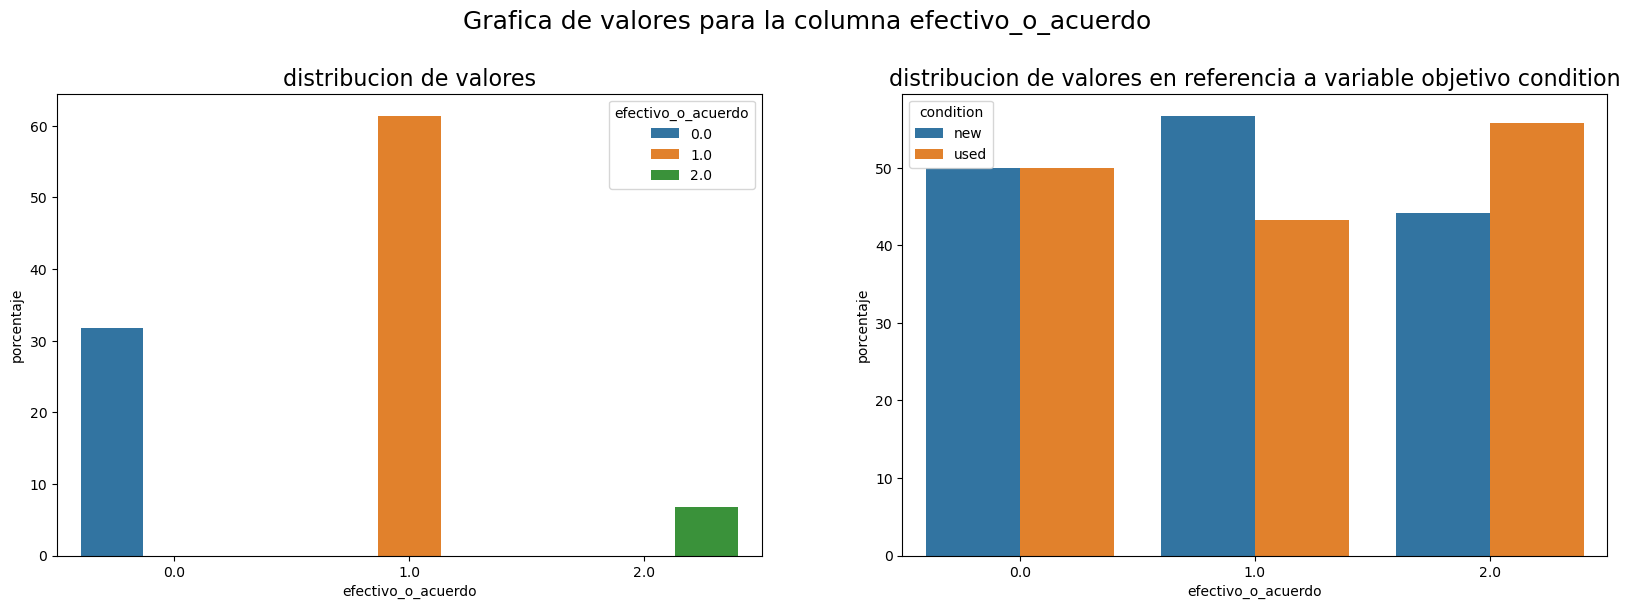

In [278]:
describe_var_categorica_basico(df_EDA,"efectivo_o_acuerdo")

##### giro_postal 
Esta variable indica si el anunciante acepta giro_postal como metodo de pago para el producto ofertado,

- la gran mayoria de anunciantes no aceptan giro_postal
- si el vendedor acepta giro_postal la proporcion de productos nuevos es mayor

cantidad_valores_nulos  pct_valores_nulos
giro_postal                       0                0.0

Distribucion variable


giro_postal  cantidad_registros  porcentaje
0          0.0               88511       98.35
1          1.0                1489        1.65

giro_postal condition  cantidad_registros  porcentaje
0          0.0       new               48037       54.27
1          0.0      used               40474       45.73
2          1.0       new                 315       21.16
3          1.0      used                1174       78.84

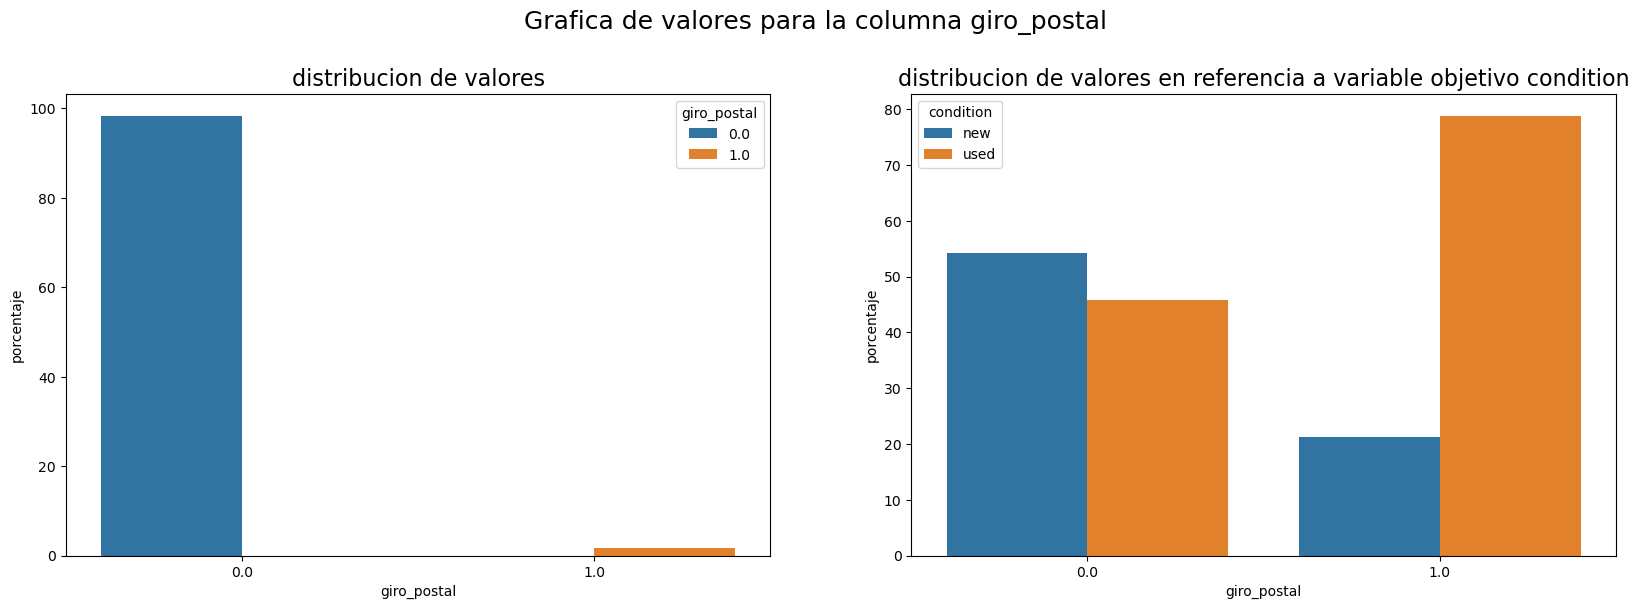

In [279]:
describe_var_categorica_basico(df_EDA,"giro_postal")

##### tarjeta_credito 
Esta variable indica si el anunciante acepta tarjeta_credito como metodo de pago para el producto ofertado, dada la transformacion de la variable original, esta variable puede tener un rango de [0,7] indicando la cantidad de franquicias de tarjetas de credito que acepta el vendedor

- Aprox. 75% de los productos ofertados no aceptan tarjeta de credito
- se puede ver que para el rango de [1,4], la proporcion de productos nuevos vendidos es mayor

cantidad_valores_nulos  pct_valores_nulos
tarjeta_credito                       0                0.0

Distribucion variable


tarjeta_credito  cantidad_registros  porcentaje
0              0.0               67240       74.71
1              1.0               22150       24.61
6              6.0                 362        0.40
5              5.0                 139        0.15
4              4.0                  59        0.07
3              3.0                  25        0.03
2              2.0                  22        0.02
7              7.0                   3        0.00

tarjeta_credito condition  cantidad_registros  porcentaje
0               0.0       new               32289       48.02
1               0.0      used               34951       51.98
2               1.0       new               15762       71.16
3               1.0      used                6388       28.84
4               2.0       new                  12       54.55
5               2.0      used                  10       45.45
6               3.0       new                  22       88.00
7               3.0      used                   3       12.00
8               4.0       new                  48       81.36
9               4.0      used                  11       18.64
10              5.0       new                  67       48.20
11              5.0      used                  72       51.80
12              6.0       new                 149       41.16
13              6.0      used                 213       58.84
14              7.0       new                   3      100.00

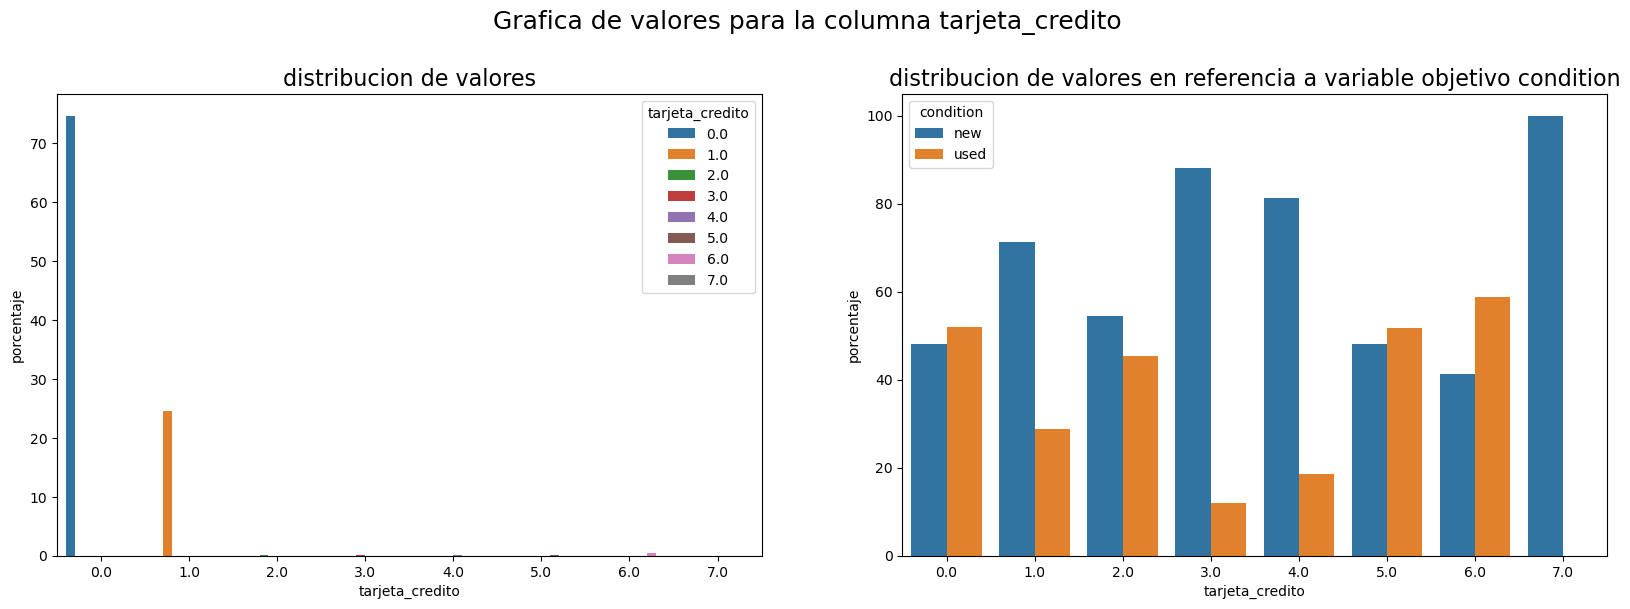

In [280]:
describe_var_categorica_basico(df_EDA,"tarjeta_credito")

##### transferencia_bancaria 
Esta variable indica si el anunciante acepta transferencia_bancaria como metodo de pago para el producto ofertado

- las categorias se dividen casi que 50-50
- cuando no se aceptan transferencias bancarias la proporcion de productos usados vendidos es mayor, asi mismo cuando se aceptan transferencias bancarias la proporcion de productos nuevos vendidos es mayor

cantidad_valores_nulos  pct_valores_nulos
transferencia_bancaria                       0                0.0

Distribucion variable


transferencia_bancaria  cantidad_registros  porcentaje
1                     1.0               46300       51.44
0                     0.0               43700       48.56

transferencia_bancaria condition  cantidad_registros  porcentaje
0                     0.0       new               19993       45.75
1                     0.0      used               23707       54.25
2                     1.0       new               28359       61.25
3                     1.0      used               17941       38.75

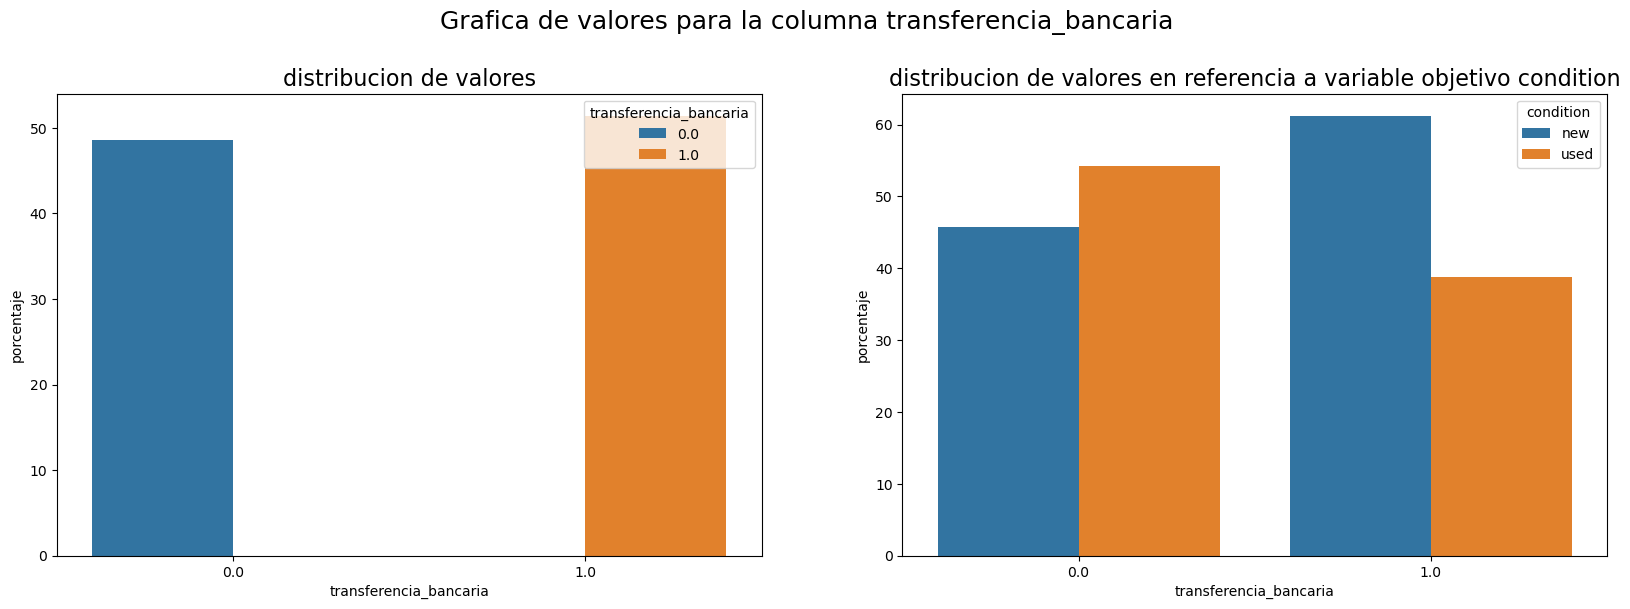

In [281]:
describe_var_categorica_basico(df_EDA,"transferencia_bancaria")

##### flg_intial_equals_available_quantity 
Esta variable indica si la cantidad de productos inciales es igual a la cantidad de productos disponibles 

- las mayoria de productos tienen la misma cantidad de productos disponibles e iniciales 
- cuando existe una diferencia entre estas dos variables, la distribucion de productos nuevos vendidos es mas alta

cantidad_valores_nulos  \
flg_intial_equals_available_quantity                       0   

                                      pct_valores_nulos  
flg_intial_equals_available_quantity                0.0

Distribucion variable


flg_intial_equals_available_quantity  cantidad_registros  porcentaje
1                                     1               85983       95.54
0                                     0                4017        4.46

flg_intial_equals_available_quantity condition  cantidad_registros  \
0                                     0       new                3894   
1                                     0      used                 123   
2                                     1       new               44458   
3                                     1      used               41525   

   porcentaje  
0       96.94  
1        3.06  
2       51.71  
3       48.29

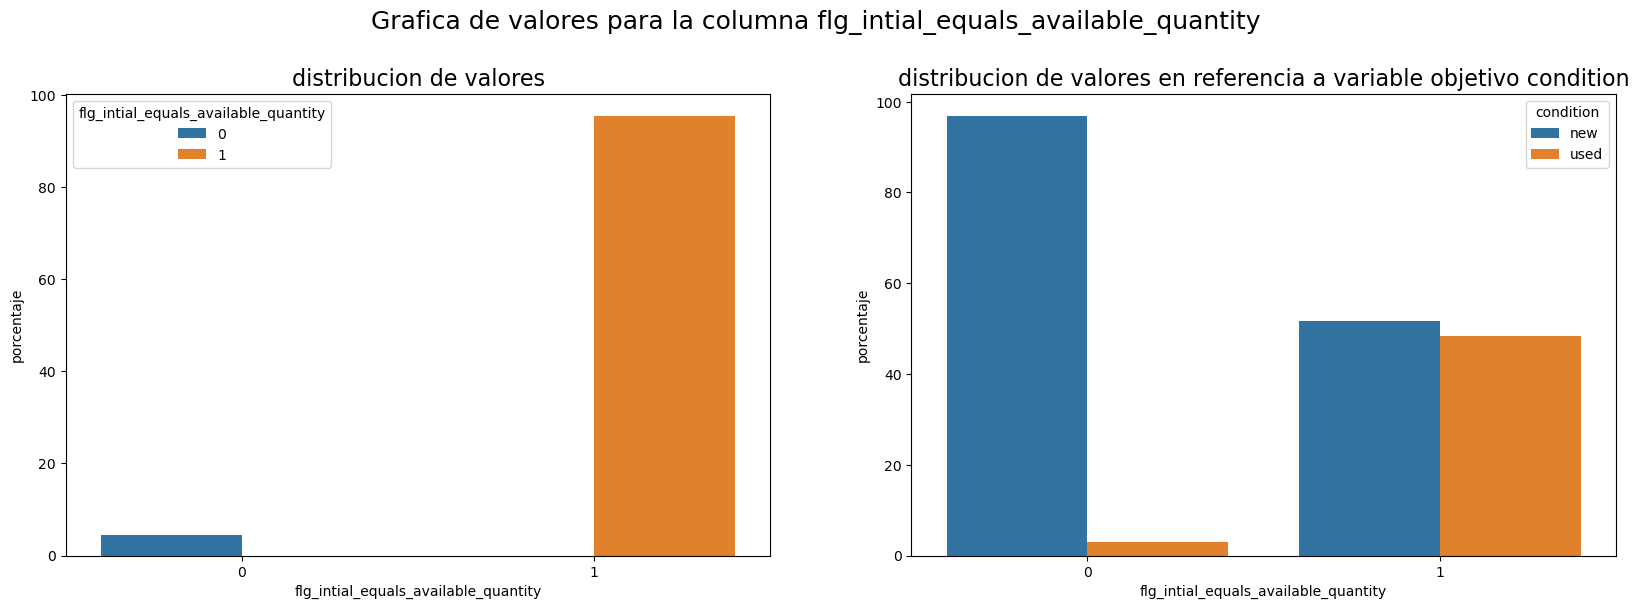

In [282]:
describe_var_categorica_basico(df_EDA,"flg_intial_equals_available_quantity")

In [283]:
cols_categoricas = ["warranty",
"listing_type_id",
"parent_item_id",
"official_store_id",
"accepts_mercadopago",
"automatic_relist",
"video_id",
"shipping_local_pick_up",
"shipping_free_shipping",
"shipping_free_methods",
"flg_buy_it_now",
"flg_is_capital_city",
"flg_ship_not_specified",
"flg_inmobiliario",
"variation_base_price",
"variation_original_price",
"MercadoPago",
"cheque",
"contra_reembolso",
"efectivo_o_acuerdo",
"giro_postal",
"tarjeta_credito",
"transferencia_bancaria",
"flg_intial_equals_available_quantity"]

In [284]:
[x for x in df_EDA.columns.values if x not in cols_categoricas]

['condition',
 'base_price',
 'price',
 'id',
 'original_price',
 'initial_quantity',
 'sold_quantity',
 'num_variations',
 'num_attributes',
 'num_tags',
 'num_pictures',
 'num_payment_methods',
 'score_seller',
 'score_category_id',
 'score_popularity_category']

#### Continuas
Para estas variables se muestra: 
- la cantidad de valores nulos
- variables descriptivas 
- distribucion de la variable para cada categoria de la variable objetivo, junto con variables descriptivas.

Graficamente se muestran 4 graficos:
- distribucion de la variable
- distribucion de la variable con transformacion logaritmica
- distribucion de la variable para cada categoria de la variable objetivo
- distribucion de la variable para cada categoria con transformacion logaritmica

##### price
Esta variable indica el precio del producto ofertado, en los graficos sin transformacion se observa que el rango de la variable es alto y existen outliers hacia valores altos.

Se nota una diferencia en las distribuciones para cada categoria luego de aplicar la transformacion log

cantidad_nulos  porcentaje_del_total
0               0                   0.0

count          mean           std   min   25%    50%    75%  \
price  90000.0  57813.518133  9.089555e+06  0.84  90.0  250.0  800.0   

                max  
price  2.222222e+09

price                                                            \
             count          mean           std   min    25%    50%       75%   
condition                                                                      
new        48352.0  49672.367141  1.010629e+07  0.84  140.0  350.0  995.5875   
used       41648.0  67265.134845  7.743572e+06  1.00   65.0  150.0  548.2500   

                         
                    max  
condition                
new        2.222222e+09  
used       1.111111e+09

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a lengt

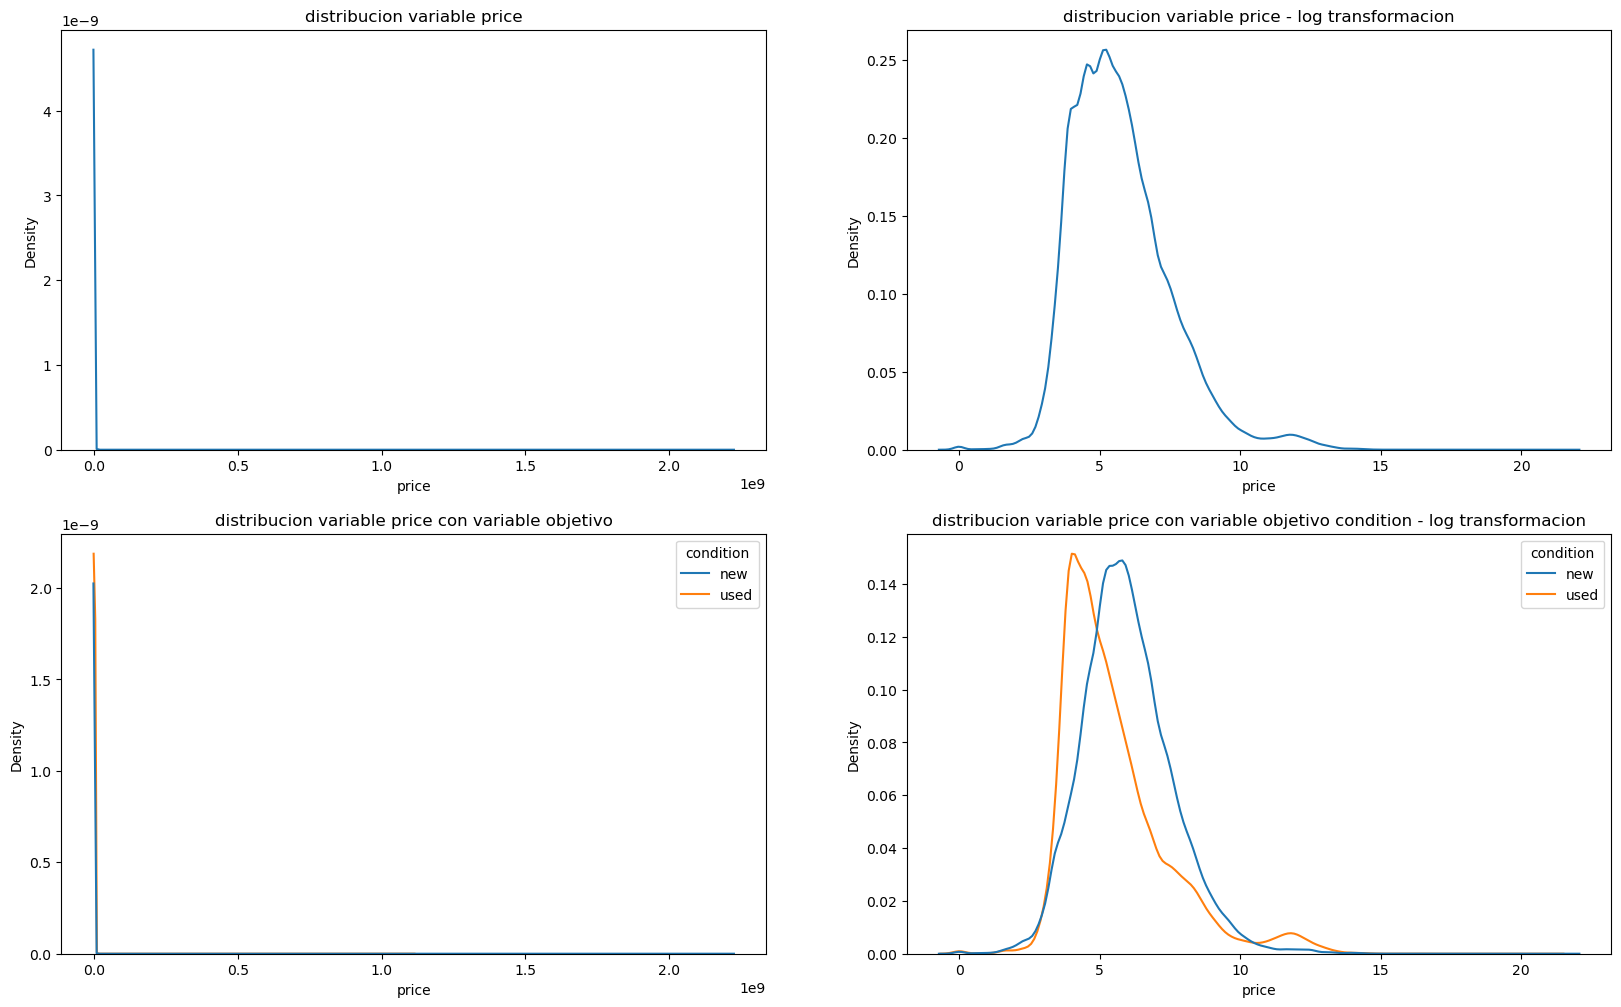

In [285]:
desc_continuous(df_EDA,"price","condition")

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

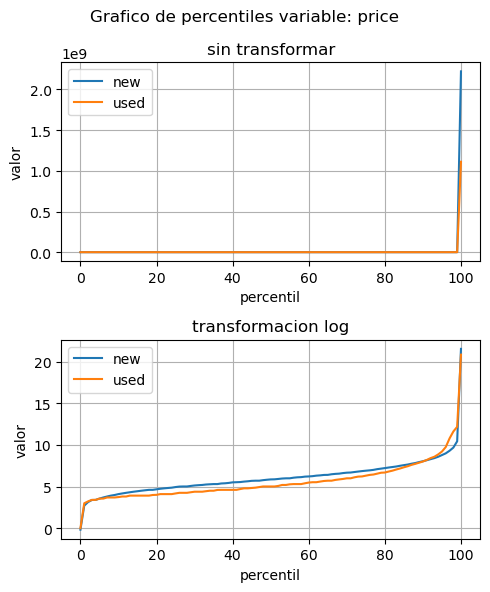

In [286]:
quantile_plot(df_EDA,"price")

##### original_price
Esta variable indica el precio original del producto ofertado en los valores descriptivos se ve que para la categoria usado todos los valores son = 0, a diferencia que la categoria nuevo que cuenta con algunos valores, sin embargo la mayoria tambien son iguales a 0.

luego de ver su distribucion y que la diferencia entre esta variable y la variable price no suminsitra mayor valor se decide <span style="color: red;">**eliminar del dataset final**</span>

cantidad_nulos  porcentaje_del_total
0               0                   0.0

count      mean        std  min  25%  50%  75%      max
original_price  90000.0  2.155866  93.224642  0.0  0.0  0.0  0.0  12248.0

original_price                                                   
                   count      mean         std  min  25%  50%  75%      max
condition                                                                  
new              48352.0  4.012821  127.158906  0.0  0.0  0.0  0.0  12248.0
used             41648.0  0.000000    0.000000  0.0  0.0  0.0  0.0      0.0

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.u

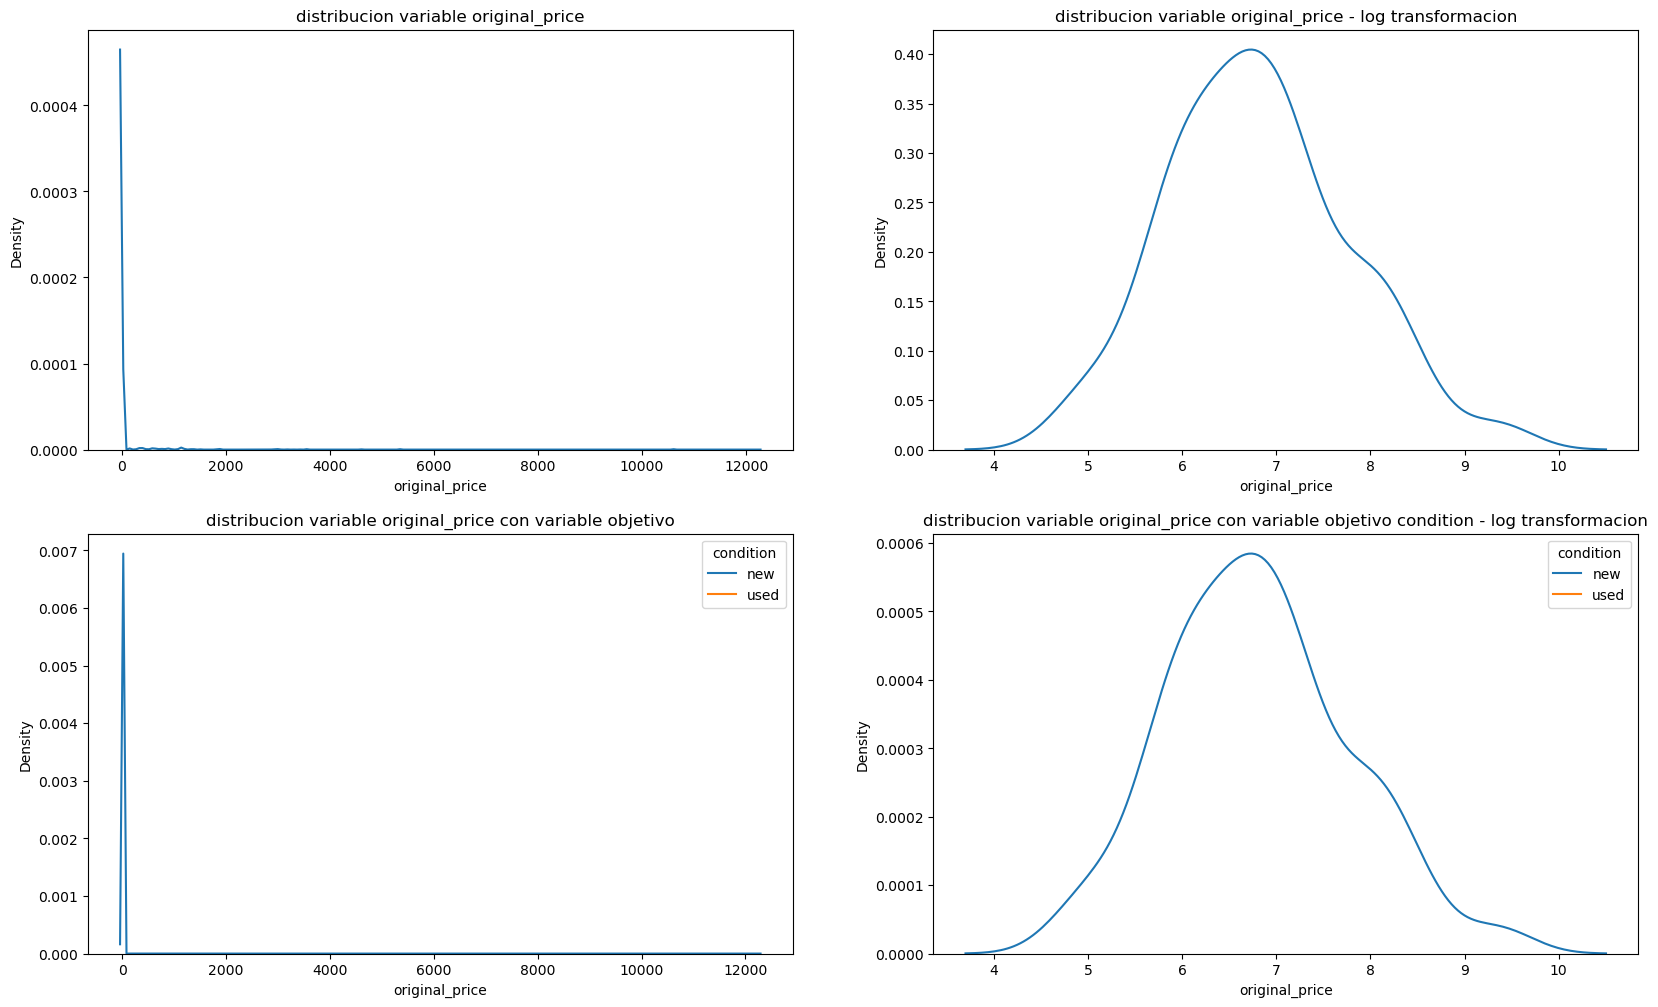

In [287]:
desc_continuous(df_EDA,"original_price","condition")

##### initial_quantity
Esta variable indica la cantidad incial de productos disponibles para la venta en el anuncio.

- existen outliers ya que las graficas tienen una cola larga a la derecha
- con la transformacion log, se evidencia que los productos nuevos suelen tener mas cantidad inicial de productos listados

cantidad_nulos  porcentaje_del_total
0               0                   0.0

count       mean         std  min  25%  50%  75%     max
initial_quantity  90000.0  34.957178  421.091981  1.0  1.0  1.0  2.0  9999.0

initial_quantity                                                   
                     count       mean         std  min  25%  50%  75%     max
condition                                                                    
new                48352.0  63.265201  570.433371  1.0  1.0  2.0  9.0  9999.0
used               41648.0   2.092465   58.313104  1.0  1.0  1.0  1.0  9999.0

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a lengt

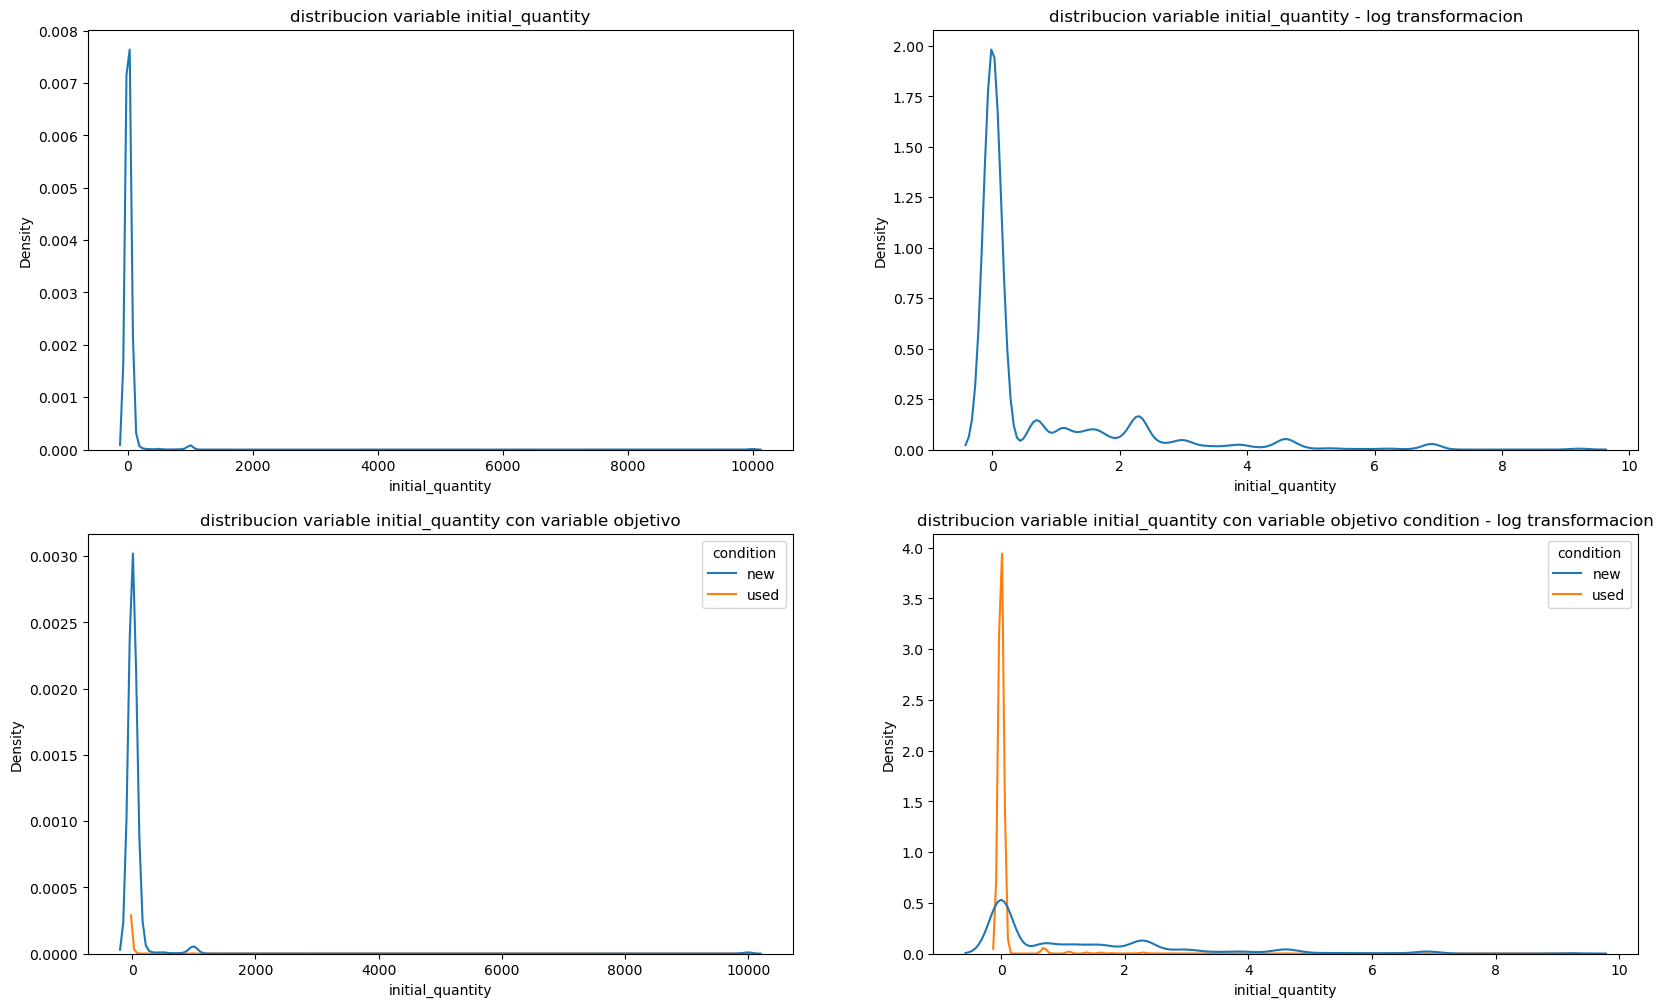

In [288]:
desc_continuous(df_EDA,"initial_quantity","condition")

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

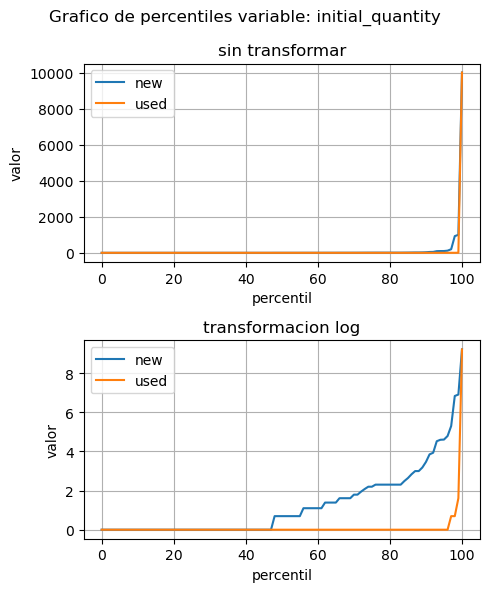

In [289]:
quantile_plot(df_EDA,"initial_quantity")

##### sold_quantity
Esta variable indica la cantidad de productos vendidos.

- existen outliers ya que las graficas tienen una cola larga a la derecha
- con la transformacion log, se evidencia que los productos nuevos suelen tener mas cantidad de productos vendidos mayor que los productos usados

cantidad_nulos  porcentaje_del_total
0               0                   0.0

count      mean        std  min  25%  50%  75%     max
sold_quantity  90000.0  2.328044  33.839328  0.0  0.0  0.0  0.0  6065.0

sold_quantity                                                 
                  count      mean        std  min  25%  50%  75%     max
condition                                                               
new             48352.0  4.249318  45.848825  0.0  0.0  0.0  1.0  6065.0
used            41648.0  0.097508   4.979905  0.0  0.0  0.0  0.0   982.0

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.u

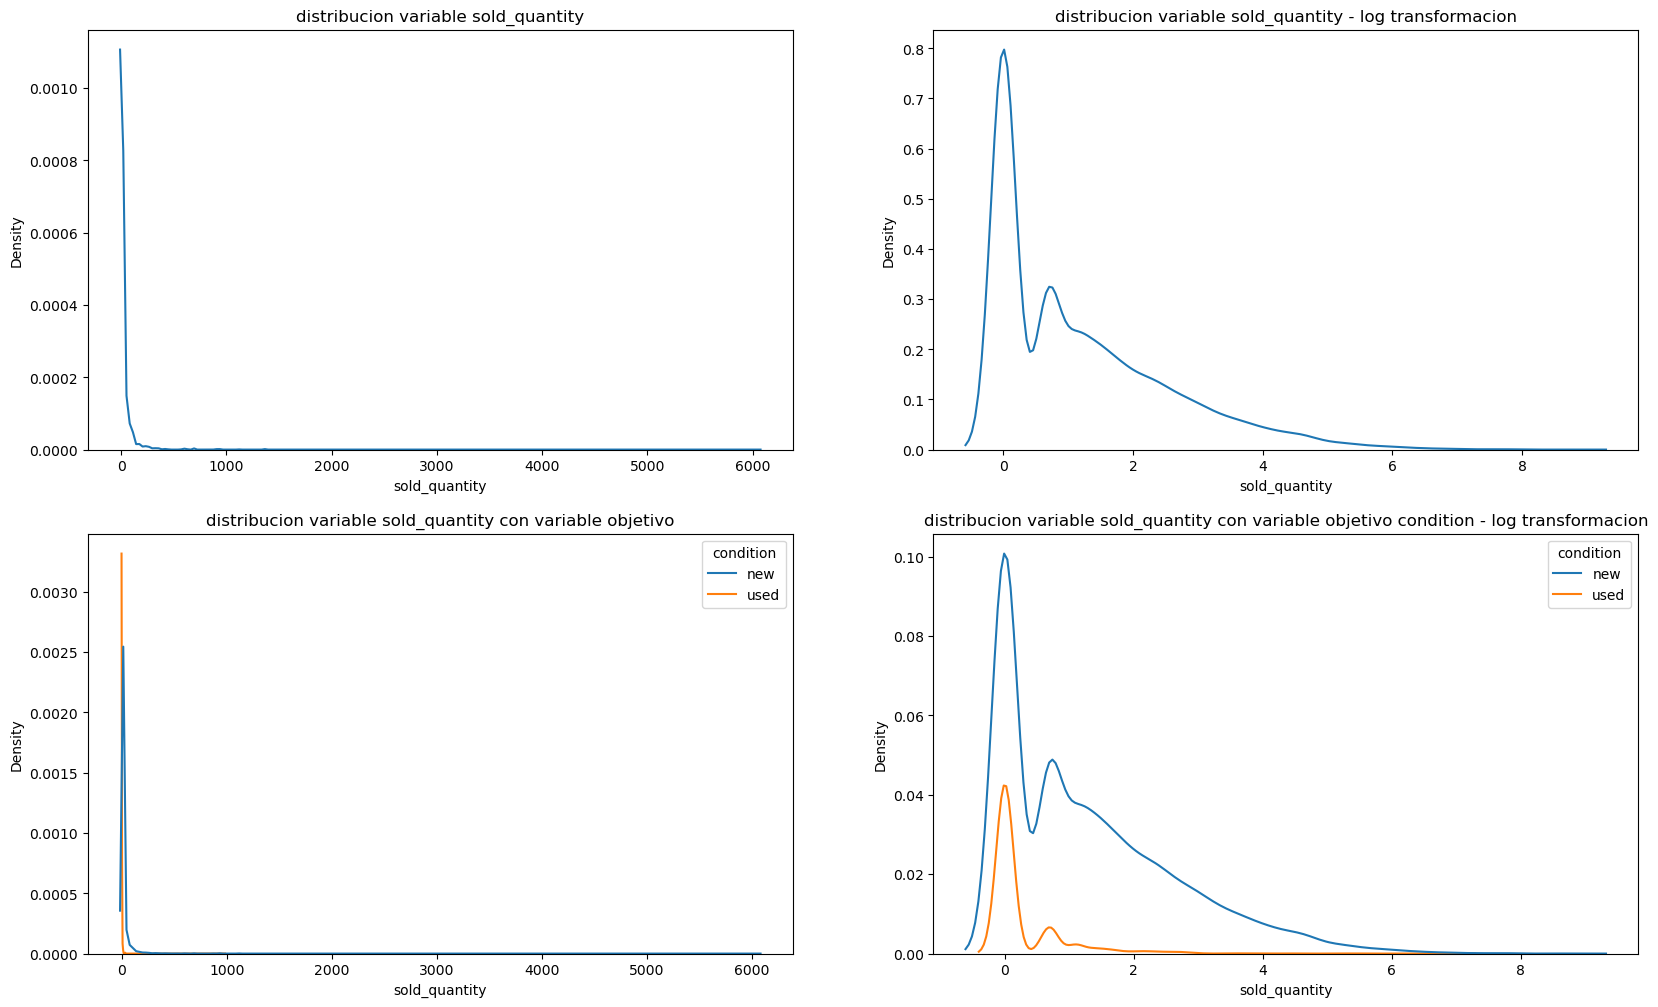

In [290]:
desc_continuous(df_EDA,"sold_quantity","condition")

##### num_variations
Esta variable indica la cantidad de variaciones listadas en el producto ofertado.

- existen outliers ya que las graficas tienen una cola larga a la derecha
- con la transformacion log, se evidencia que los productos nuevos suelen tener mas cantidad de variaciones listadas.

cantidad_nulos  porcentaje_del_total
0               0                   0.0

count      mean      std  min  25%  50%  75%   max
num_variations  90000.0  0.188033  1.08379  0.0  0.0  0.0  0.0  50.0

num_variations                                              
                   count      mean       std  min  25%  50%  75%   max
condition                                                             
new              48352.0  0.282346  1.446983  0.0  0.0  0.0  0.0  50.0
used             41648.0  0.078539  0.291881  0.0  0.0  0.0  0.0  10.0

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.u

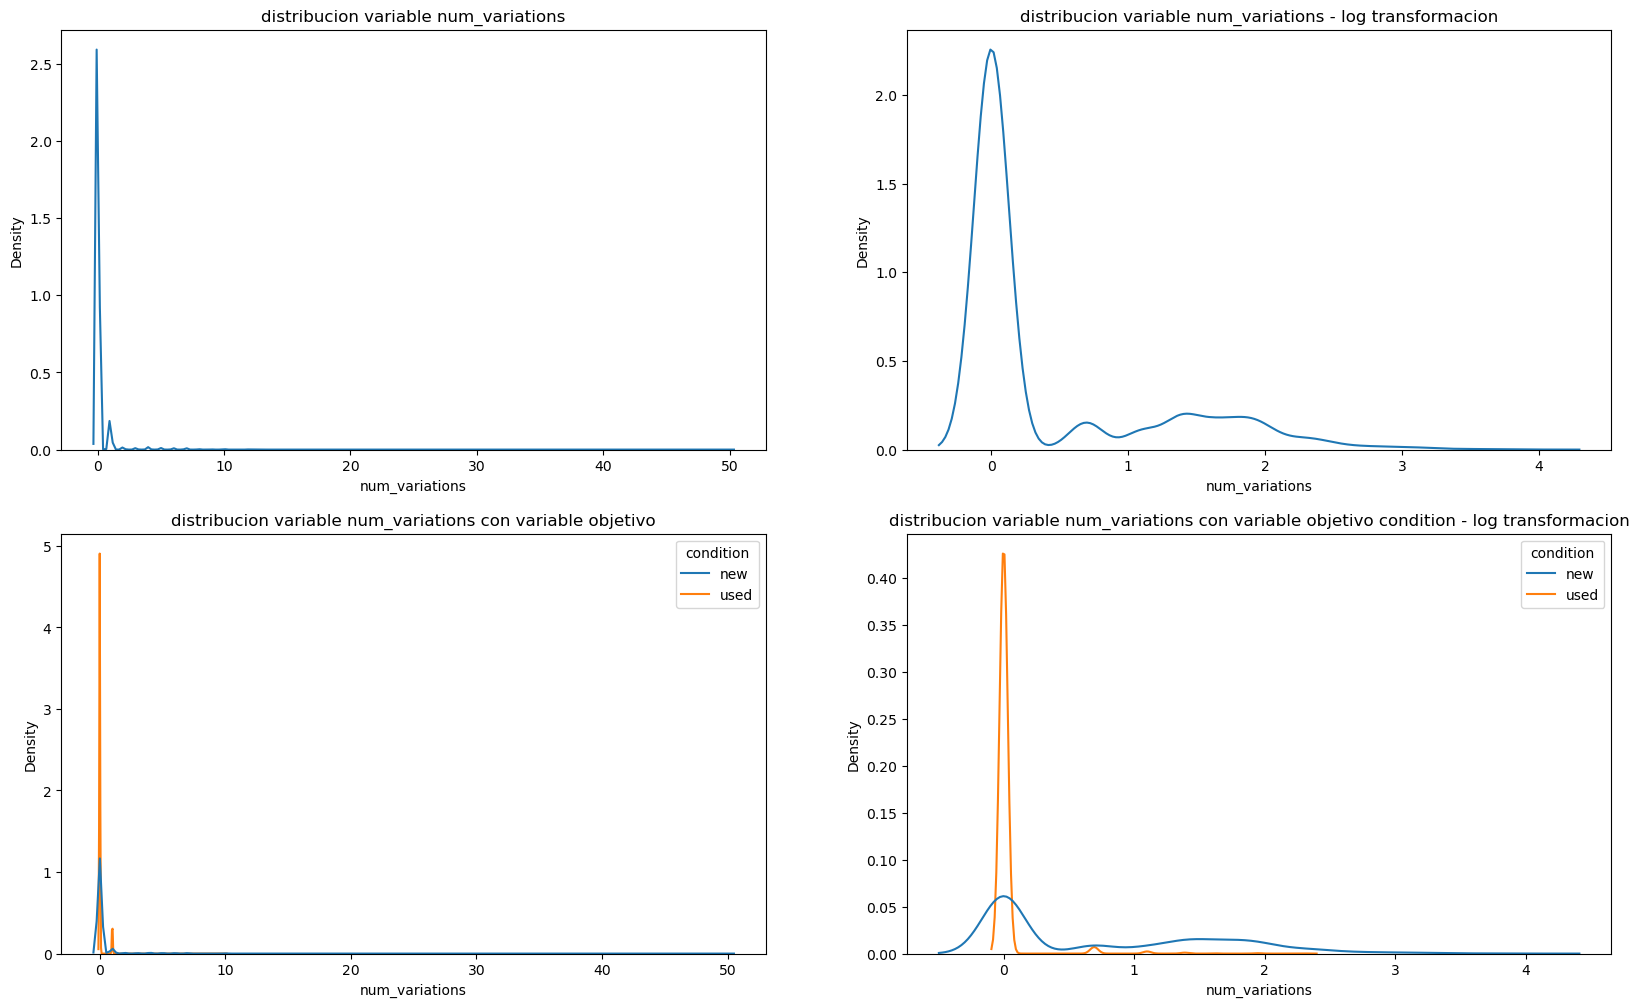

In [291]:
desc_continuous(df_EDA,"num_variations","condition")

##### num_attributes
Esta variable indica la cantidad de atributos del producto listados en la publicacion.

- la mayoria de registros no tiene atributos listados
- con la transformacion log, se evidencia que los productos usados suelen tener mas atributos listados.

cantidad_nulos  porcentaje_del_total
0               0                   0.0

count      mean       std  min  25%  50%  75%   max
num_attributes  90000.0  1.176833  7.502051  0.0  0.0  0.0  0.0  81.0

num_attributes                                               
                   count      mean        std  min  25%  50%  75%   max
condition                                                              
new              48352.0  0.576295   4.082545  0.0  0.0  0.0  0.0  81.0
used             41648.0  1.874040  10.068146  0.0  0.0  0.0  0.0  81.0

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.u

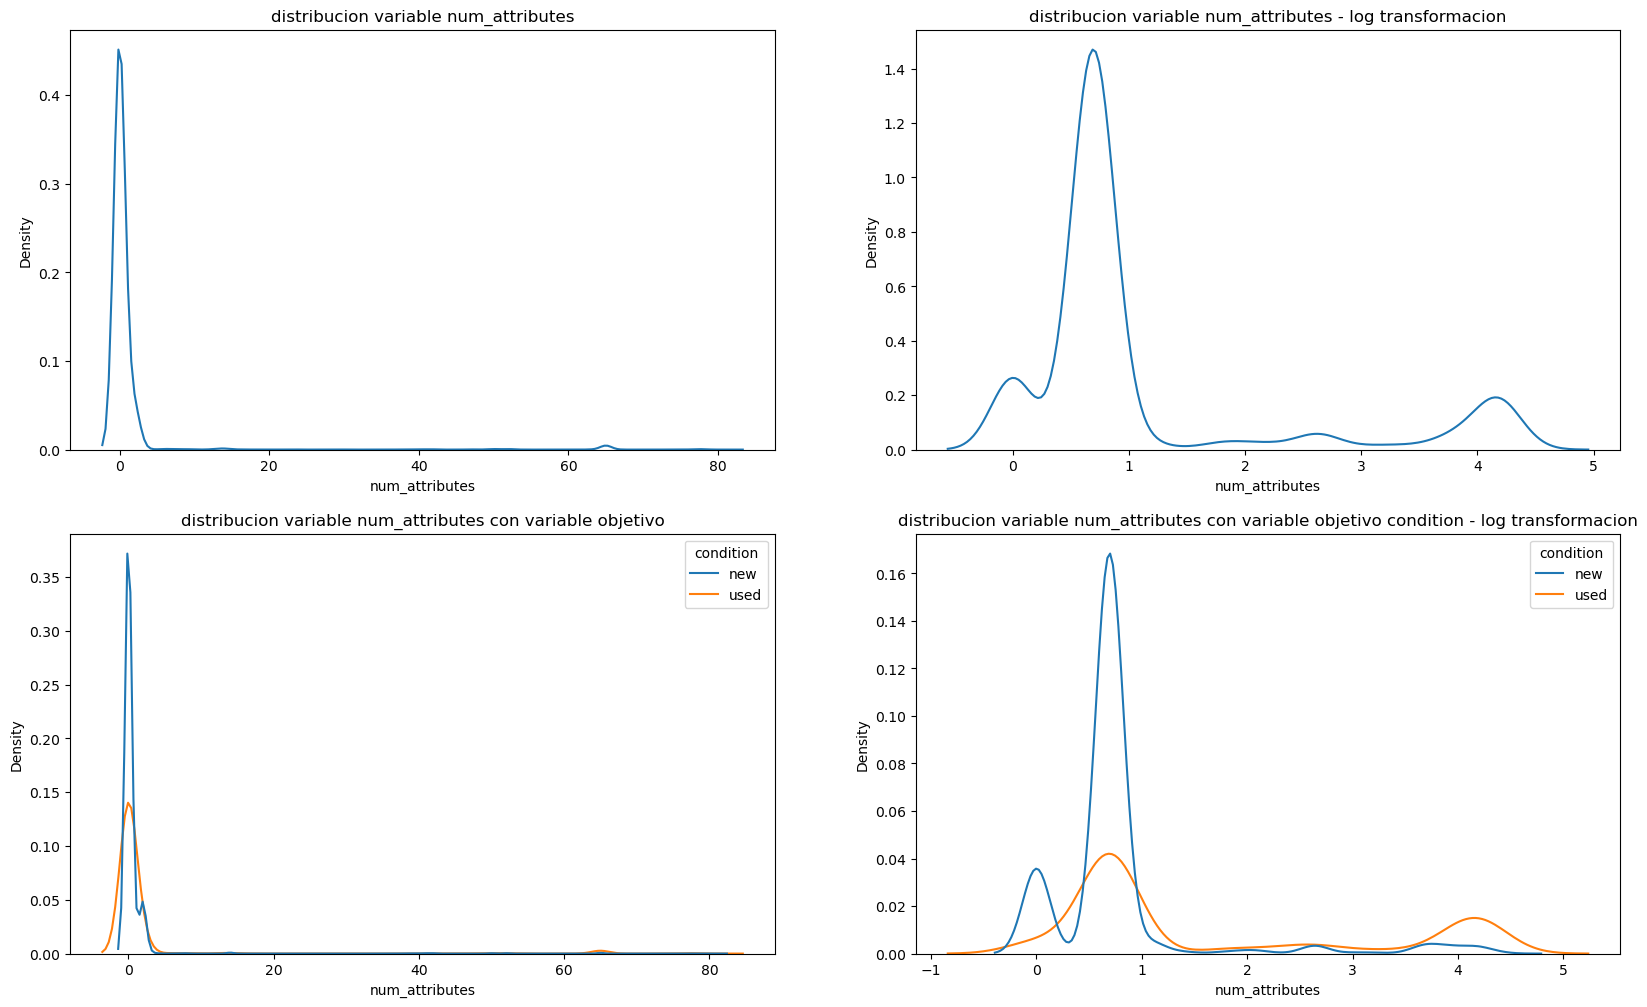

In [292]:
desc_continuous(df_EDA,"num_attributes","condition")

##### num_tags
Esta variable indica la cantidad de tags asociados al producto en la publicacion.

- la mayoria de registros tiene al menos un tag
- la distribucion es similar para ambas categorias nuevos y usados

cantidad_nulos  porcentaje_del_total
0               0                   0.0

count    mean       std  min  25%  50%  75%  max
num_tags  90000.0  0.7672  0.459403  0.0  1.0  1.0  1.0  2.0

num_tags                                             
             count      mean       std  min  25%  50%  75%  max
condition                                                      
new        48352.0  0.770227  0.472030  0.0  0.0  1.0  1.0  2.0
used       41648.0  0.763686  0.444272  0.0  1.0  1.0  1.0  2.0

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.u

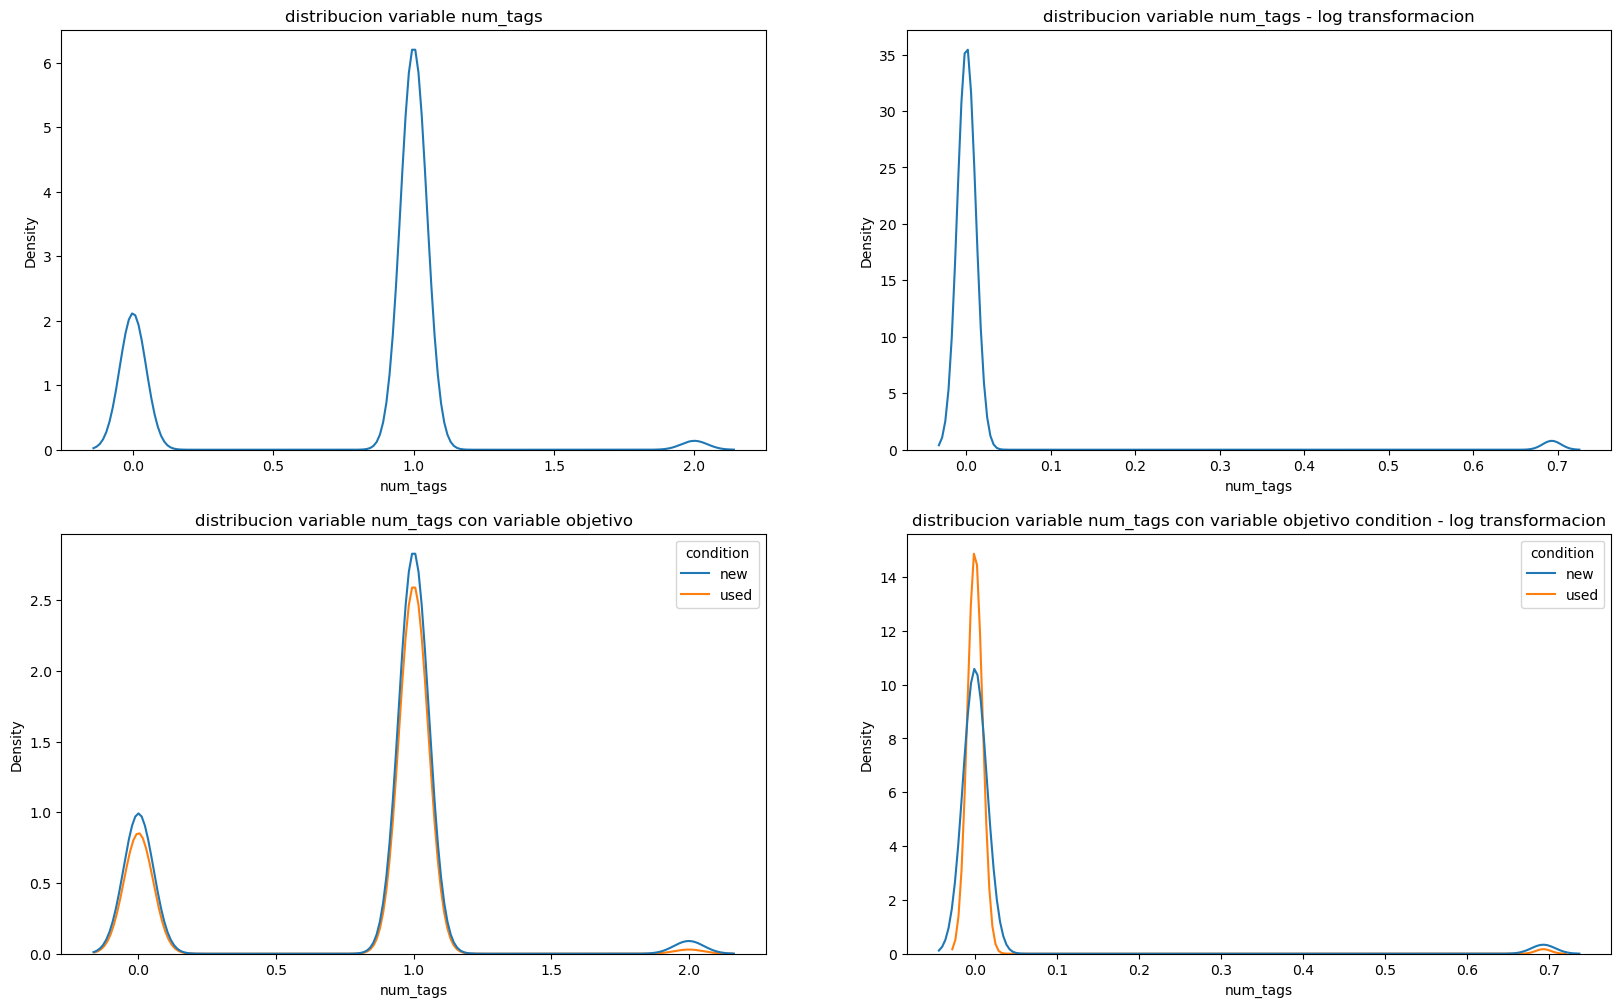

In [293]:
desc_continuous(df_EDA,"num_tags","condition")

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: Futur

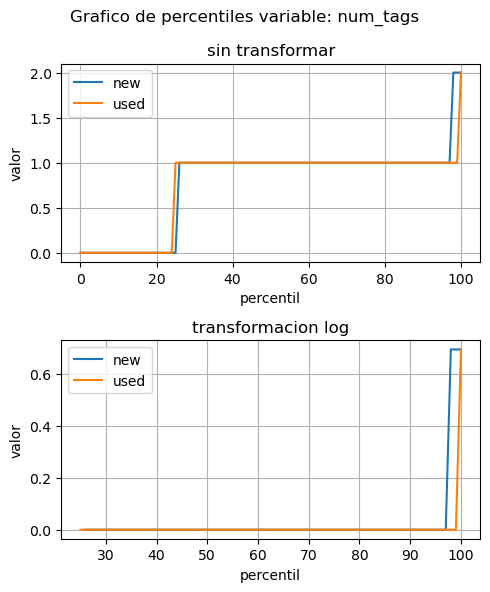

In [294]:
quantile_plot(df_EDA,"num_tags")

##### num_pictures
Esta variable indica la cantidad de fotos disponibles en la publicacion.

- la mayoria de registros tiene al menos una foto
- la distribucion es similar para ambas categorias nuevos y usados, sin embargo parece que los productos nuevos tienen mas fotos

cantidad_nulos  porcentaje_del_total
0               0                   0.0

count      mean      std  min  25%  50%  75%   max
num_pictures  90000.0  2.930322  2.10423  0.0  1.0  2.0  4.0  36.0

num_pictures                                              
                 count      mean       std  min  25%  50%  75%   max
condition                                                           
new            48352.0  3.023143  2.079480  0.0  1.0  3.0  4.0  36.0
used           41648.0  2.822561  2.127555  0.0  1.0  2.0  4.0  18.0

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.u

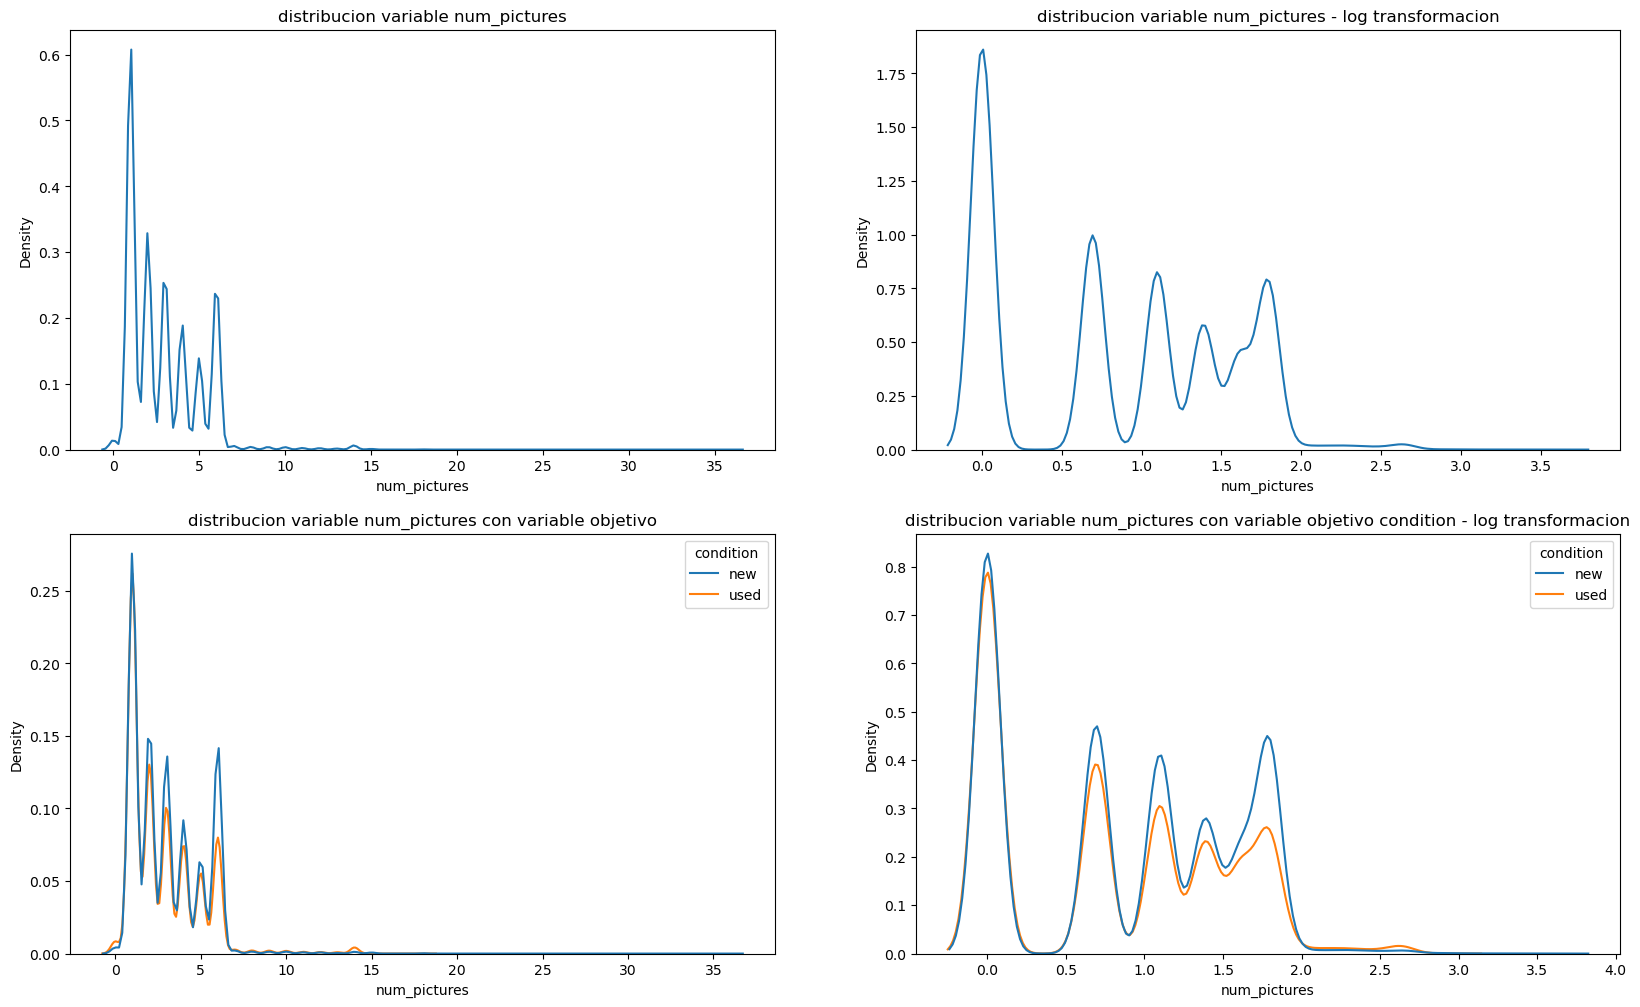

In [295]:
desc_continuous(df_EDA,"num_pictures","condition")

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: Futur

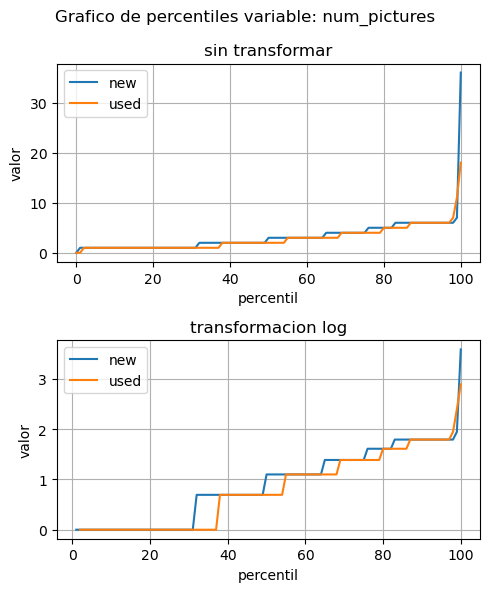

In [296]:
quantile_plot(df_EDA,"num_pictures")

##### num_payment_methods
Esta variable indica la cantidad de metodos de pago aceptados en la publicacion.

- la mayoria de registros tiene al menos una foto
- la distribucion es similar para ambas categorias nuevos y usados, sin embargo parece que los productos nuevos tienden a aceptar mas medios de pago

cantidad_nulos  porcentaje_del_total
0               0                   0.0

count    mean       std  min  25%  50%  75%   max
num_payment_methods  90000.0  1.5815  1.408656  0.0  0.0  2.0  3.0  12.0

num_payment_methods                                              
                        count      mean       std  min  25%  50%  75%   max
condition                                                                  
new                   48352.0  1.731697  1.382850  0.0  0.0  2.0  3.0  12.0
used                  41648.0  1.407126  1.418238  0.0  0.0  1.0  2.0  12.0

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.u

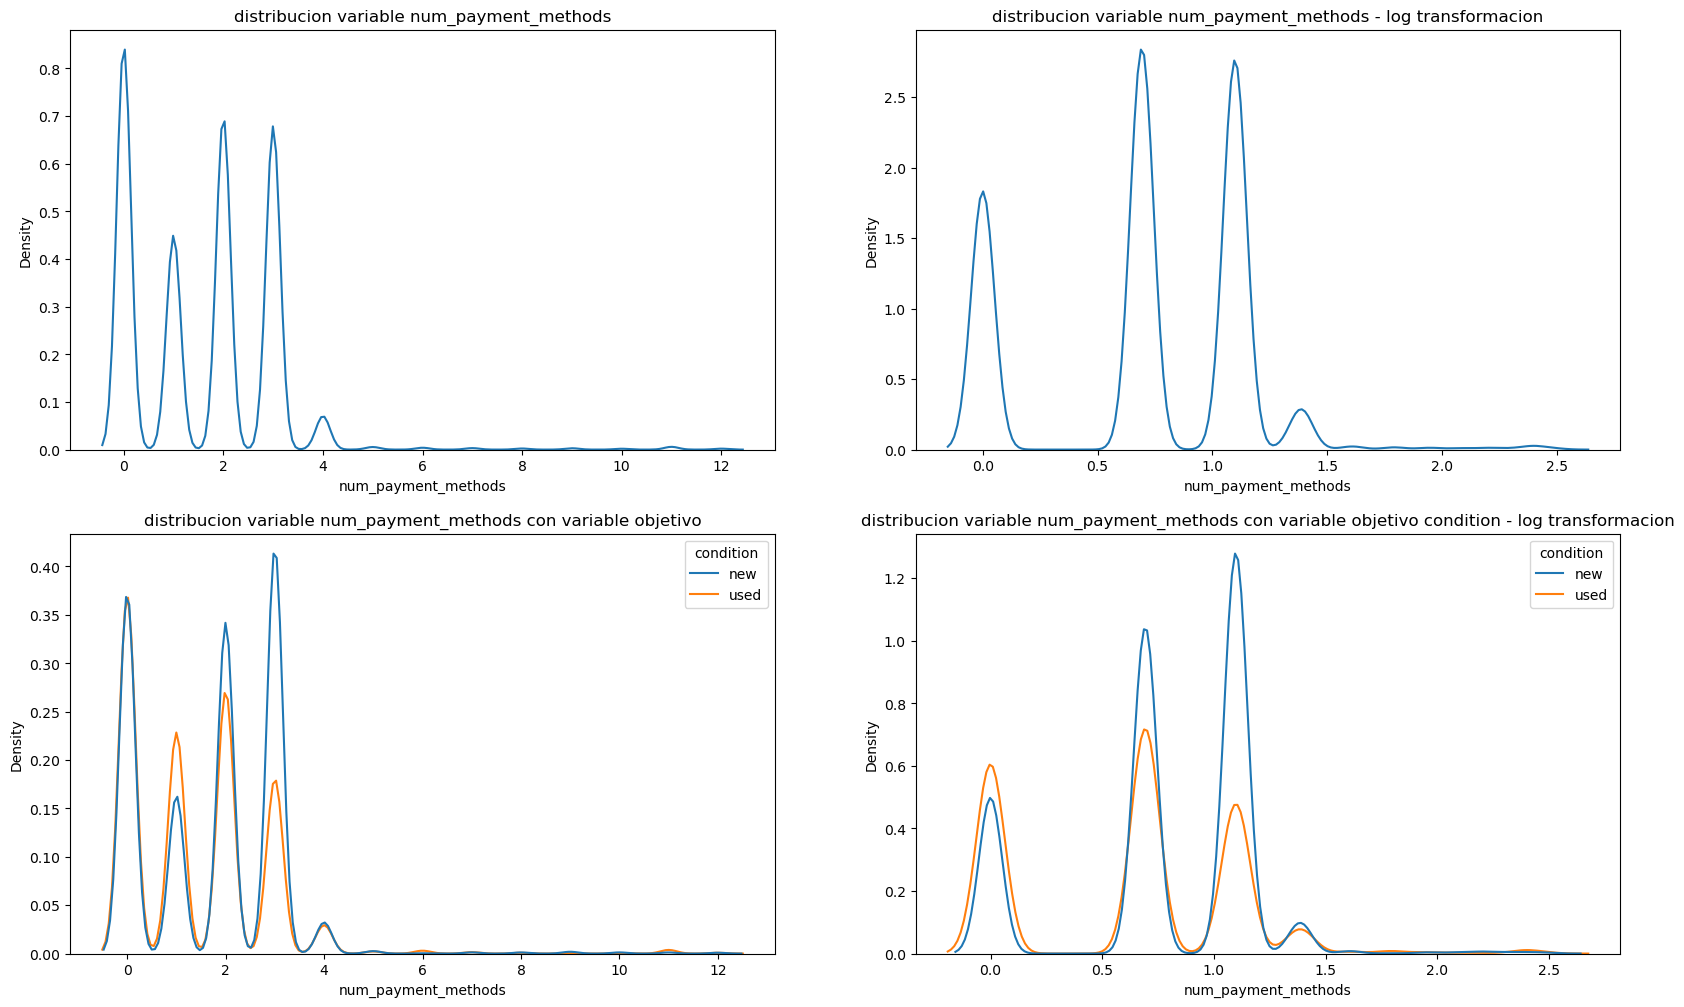

In [297]:
desc_continuous(df_EDA,"num_payment_methods","condition")

##### score_seller
Esta variable indica la proporcion de productos usados vendidos por un cliente, respecto a la totalidad de productos que vende.

- se evidencia que hay usuarios dedicados a la venta de productos usados

cantidad_nulos  porcentaje_del_total
0               0                   0.0

count      mean       std  min  25%       50%  75%  max
score_seller  90000.0  0.462756  0.468218  0.0  0.0  0.315789  1.0  1.0

score_seller                                                        
                 count      mean       std       min   25%  50%  75%       max
condition                                                                     
new            48352.0  0.054700  0.171951  0.000000  0.00  0.0  0.0  0.995098
used           41648.0  0.936495  0.147219  0.014706  0.96  1.0  1.0  1.000000

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.u

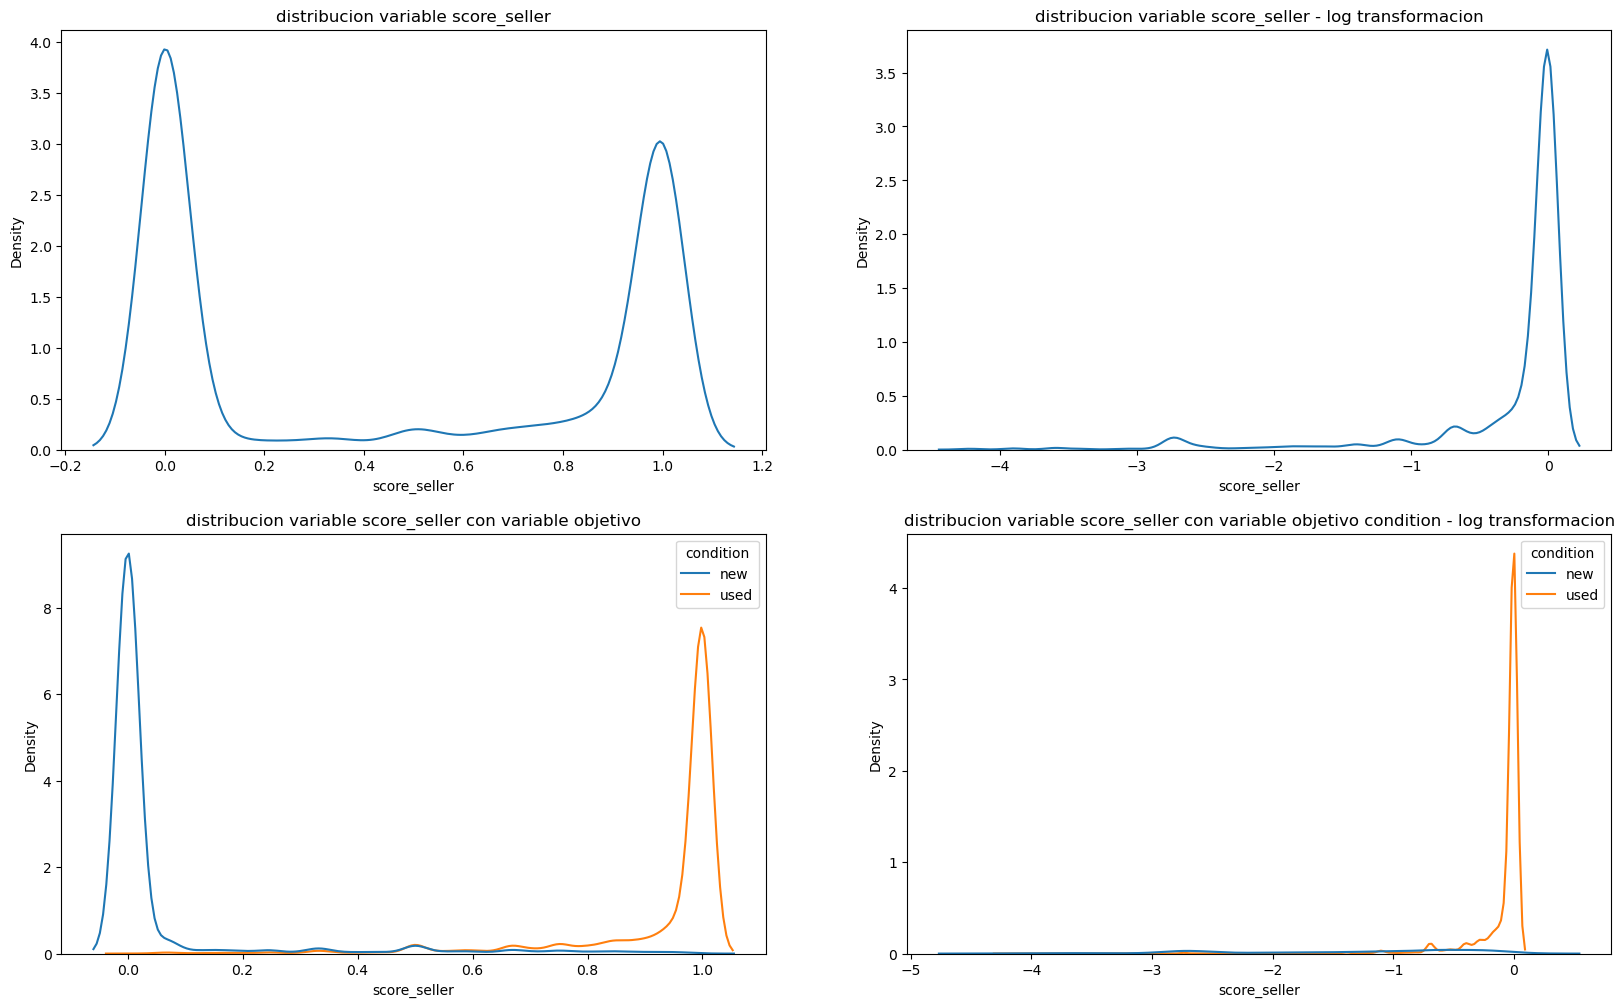

In [298]:
desc_continuous(df_EDA,"score_seller","condition")

##### score_category_id
Esta variable indica la proporcion de productos usados vendidos en una categoria, respecto a la totalidad de productos que existen en esa categoria.

- se evidencia que hay categorias exclusivas de productos usados

cantidad_nulos  porcentaje_del_total
0               0                   0.0

count      mean       std  min       25%  50%  75%  max
score_category_id  90000.0  0.462756  0.354132  0.0  0.090909  0.5  0.8  1.0

score_category_id                                                \
                      count      mean       std       min       25%   50%   
condition                                                                   
new                 48352.0  0.229327  0.257695  0.000000  0.000000  0.12   
used                41648.0  0.733759  0.239181  0.007353  0.555556  0.80   

                               
                75%       max  
condition                      
new        0.400000  0.989011  
used       0.935294  1.000000

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.u

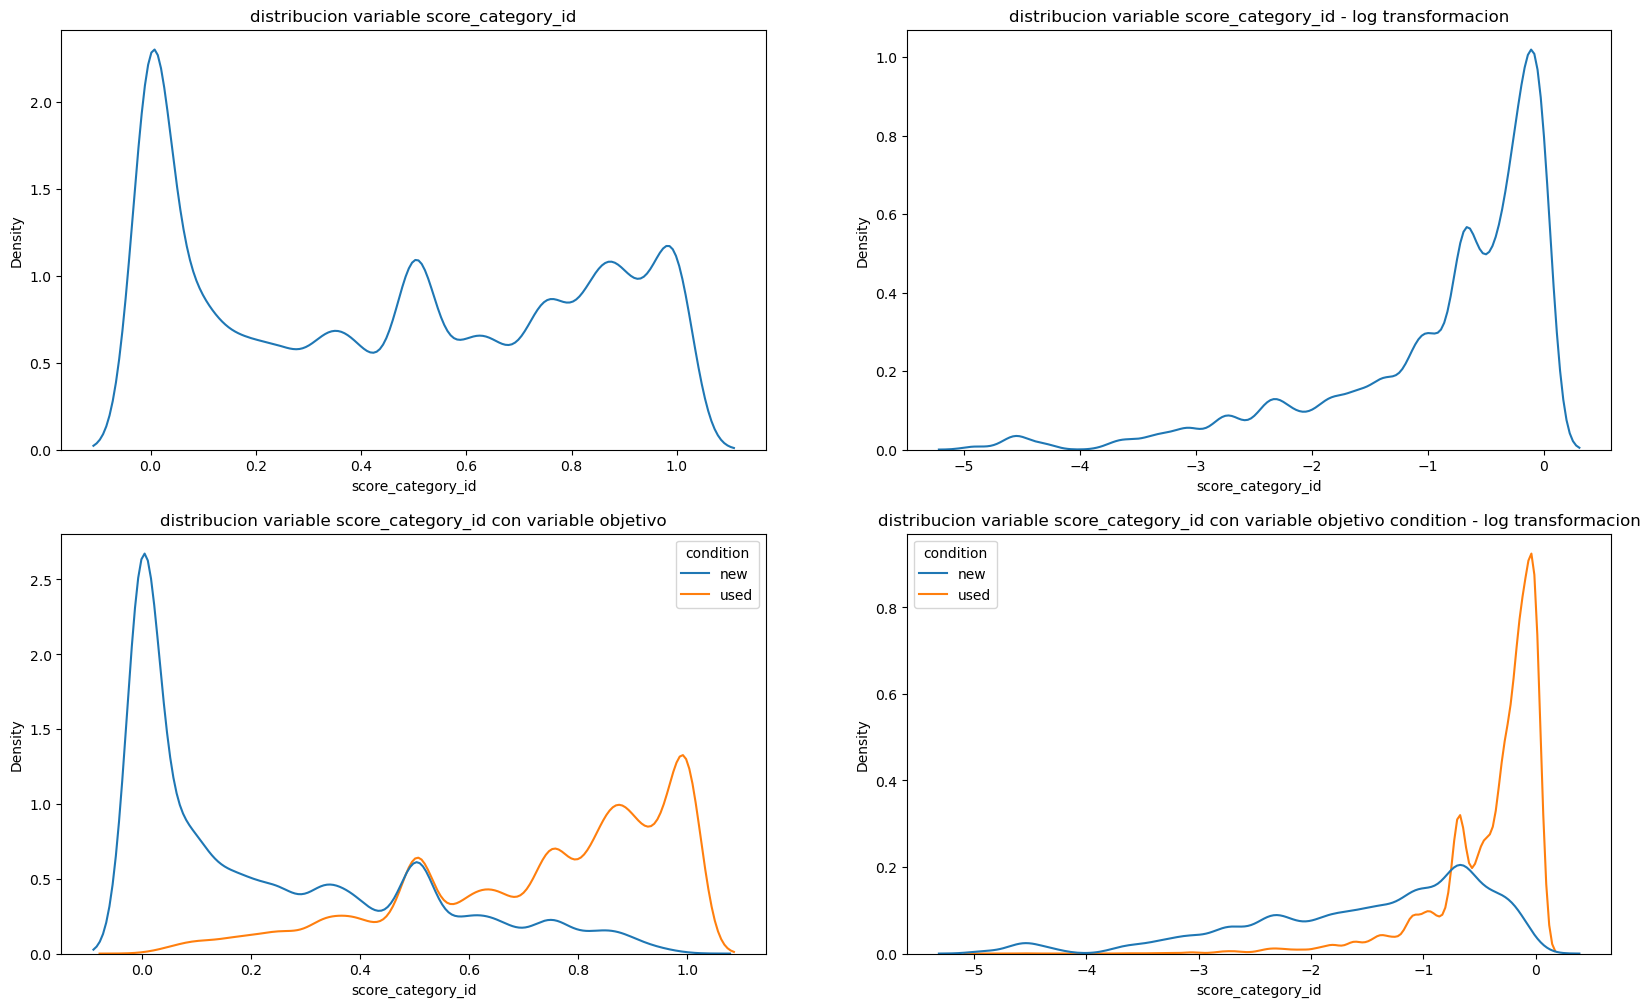

In [299]:
desc_continuous(df_EDA,"score_category_id","condition")

##### score_popularity_category
Esta variable indica la popularidad de una categoria, basada en la cantidad de productos de la categoria $i$ vs la cantidad de productos en la categoria mas popular.

- se evidencia en la distribucion con la transformacion logaritmica, que existe una preferencia por productos usados en las categorias mas populares

cantidad_nulos  porcentaje_del_total
0               0                   0.0

count      mean      std       min       25%  \
score_popularity_category  90000.0  0.073976  0.21352  0.000242  0.002174   

                                50%       75%  max  
score_popularity_category  0.007248  0.030925  1.0

score_popularity_category                                          \
                              count      mean       std       min       25%   
condition                                                                     
new                         48352.0  0.061048  0.202535  0.000242  0.001691   
used                        41648.0  0.088984  0.224675  0.000242  0.002899   

                                    
                50%       75%  max  
condition                           
new        0.005557  0.020295  1.0  
used       0.012322  0.045663  1.0

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a lengt

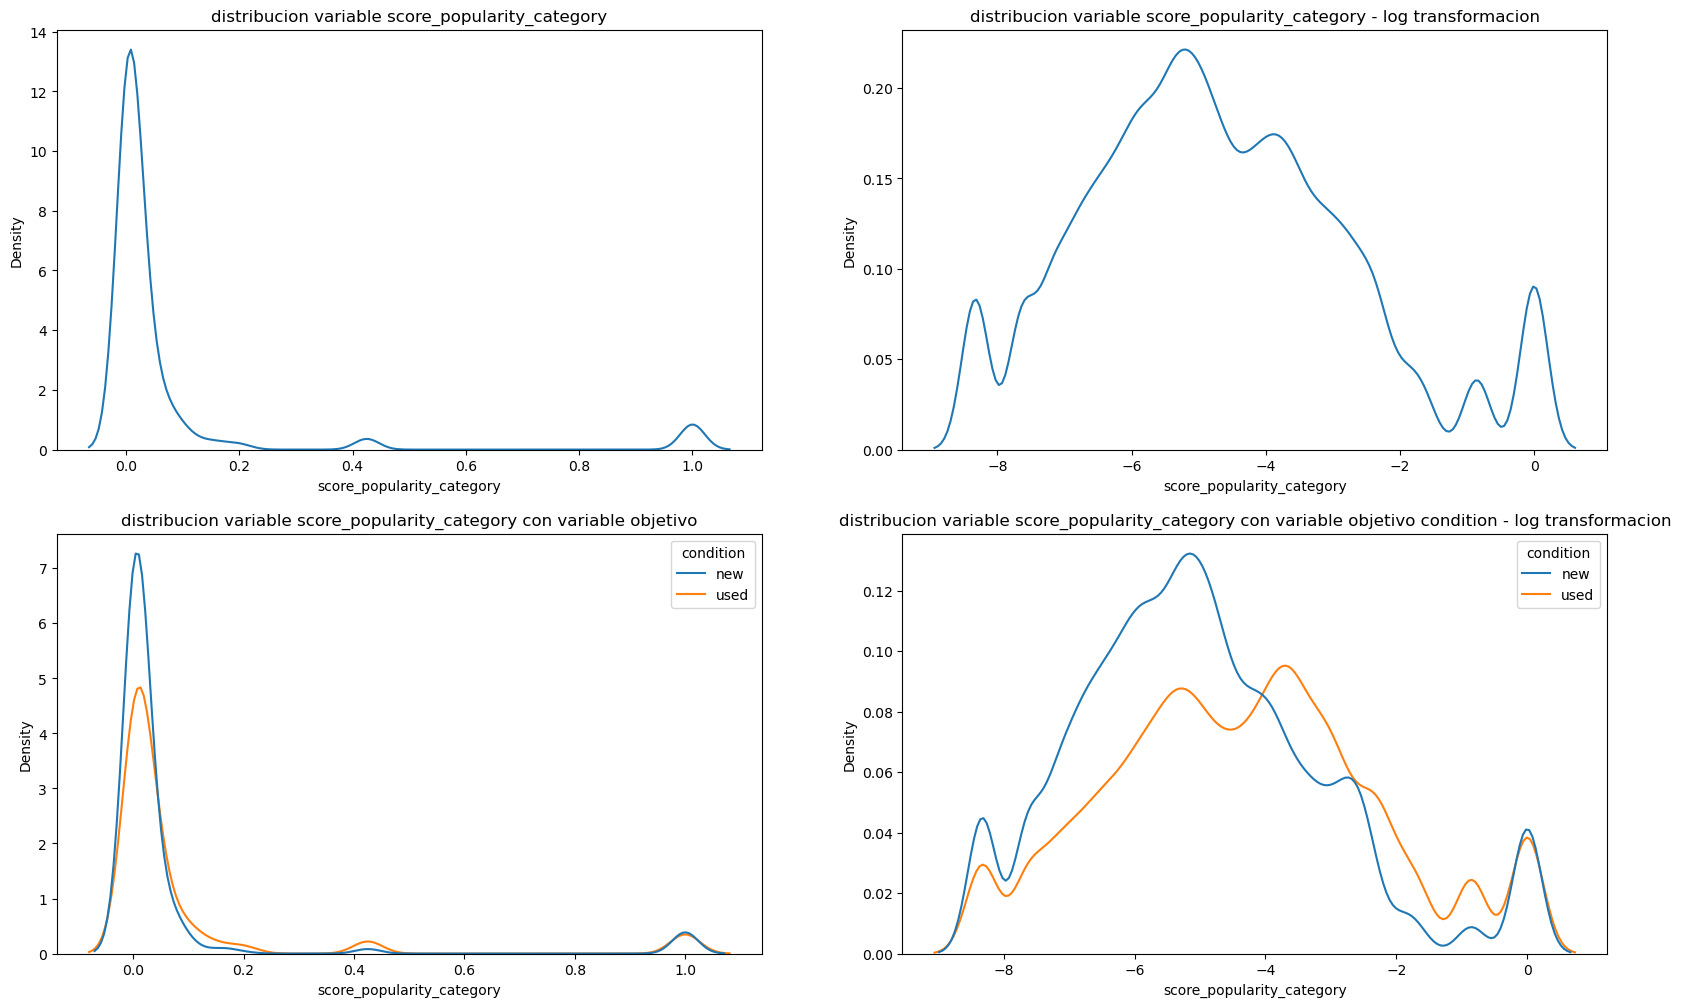

In [300]:
desc_continuous(df_EDA,"score_popularity_category","condition")

**Nueva columna Outliers**

A partir del analisis de las variables continuas se propone una nueva variable, una que identifica si el dato es un outlier o no. Para identificar un outlier en la distribucion se utilizara el rango intercuartil. Los datos que esten por fuera de este rango seran catalogados como outliers

# Conclusiones

### Respecto a la limpieza de datos
- Gran cantidad de variables fueron descartadas al analizar su composicion, ya sea por que tienen una gran cantidad de valores nulos, son redundantes con otras ya que tienen la misma informacion o informacion similar.

- Otro grupo de variables si bien pueden dar valor al modelo, no son utilizadas para esta version, ya que tratar y procesar estas variables puede acarrear mas tiempo, emplear estas variables se puede hacer en una segunda iteracion del modelo, este es el caso de las variables:
    - Varaible Geografica (lat,lon)
    - Variable titulo, aprovechable con NLP

- Otro grupo de variables son descartadas por criterio experto, ya sea por que no se considera que tengan relacion con la variable que se busca predecir, como variables de tiempo. o por que luego de procesarlas se ve que son hegemonicas, o su implementacion aumentaria la dimensionalidad de las variables.

- La transformacion de variables permite smplificar la interpretacion de las variables y obtener nuevos *insights* sobre el comportamiento de las variables. Algunas de las transformaciones mas improtantes son:
    - binarizacion
    - creacion de scores, que permiten conocer un estado actual del sistema que se busca predecir


### Respecto al EDA
- este es un problema de clasificacion balanceado, ya que la distribucion de las variables es ~54% de productos nuevos y ~46% de productos usados.

- la variable listings_category tiene una clara difernecia entre nuevos y usados siendo estos ultimos lo que menor categoria tienen, esto puede estar impulsado por que las personas que venden un usado puede ser venta ocacional y no ven lucrativo acceder a un nivel mayor

- cuando el vendedeor tiene un tag de tienda oficial es mas probable que venda elementos nuevos, sin embargo son pocos vendedores los que tienen este tag

- existe una mayor proporcion de vendedores de productos usados que aceptan mercadopago, esto se debe a que puede ser una opcion rápida para obtener el dinero solicitado, esta preferencia puede ser una <span style="color: green;">oportunidad para mercadopago</span> sin embargo hay que tener especial atencion para mitigar con los casos de fraude y/o devoluciones de producto.

- la variable automatic_relist tiene una mayor proporcion cuando los productos son nuevos, desde el entendimiento incial que tengo de la variable esto se debe a que relist sucede usualmente cuando vuelve a haber inventario de un producto, fenomeno que es maoritario en tiendas que venden productos nuevos.

- las publicaciones de productos nuevos tienden a tener video mientras que los usados no, esto por que la venta de un producto usado es ocacional y el vendedor hace un esfuerzo menor en la "produccion" de su punlicacion que un vendedor de un producto nuevo.

- cuado el producto tiene asociado *free shipping* es mas probable que sea nuevo, esto puede deberse nuevamente a que el vendedor de un producto usado es un vendedor ocacional y no tiene una vinculacion con un transportista o mercado libre para el envio de productos y posiblemente este buscando conciliar con el comprador los costos de envio. Aca puede existir una <span style="color: green;">oportunidad para que mercado libre</span> analice el por que los vendedores de usados no estan utilizando esto. Quizas mejorando las condiciones de free shipping para los vendedores ocacionales, con centros de recoleccion de productos, los vendedores pueden ofrecer envio gratuito y hacer mas atractivo el producto. ([ref free shipping](https://www.mercadolibre.com.co/ayuda/Costos-de-envios-gratis_3703))

- la gran mayoria de productos son venta y no subastas u otra metodologia, si embargo las que son distintas de venta suelen ser de productos usados

- la variable *flg_ship_not_specified*  dice si el vendedor ha elegido un tipo de envio particular (valor=0) o si el tipo de envio no esta especificado (valor=1), hay una probablidad mayor de que el elemento sea nuevo si se ha elegido un metodo de envio particular.

- las variable *variation_original_price* y  variable *variation_base_price* es hegemonica ya que la mayoria de productos no tiene una variacion en el precio listado y los otros precios.

- variables de tipos de medios de pago:
    - la variable *mercadopago* se contradice con la variable *accepts_mercadopago* esta discrepanca puede darse por que si la opcion de accept esta mercado pago el vendedor no vea necesario indicar nuevamente que acepta mercadopago

    - auqellos que aceptan cheque como medio de pago son mas propensos a vender usados, sin embargo son una poca cantidad de vendedores

    - si el cliente acepta efectivo y tambien un acuerdo es mas probable que este vendiendo un usado.

    - si el cliente acepta giro postal es mas probable que este vendiendo un usado

    - entre mas franquicias de tarjetas acepte el vendedor mas probable es que sea un producto nuevo, esto puede deberse a que los vendedores de productos nuevos son vendedores al por mayor y por lo tanto tendran mas facilidad para aceptar distintas franquicias de tdc.

    - si el cliente acepta transferencia bancaria es mas probable que el cliente venda un producto nuevo, la baja aceptacion por parte de los vendedores de usado por las transferencias bancarias puede ser por que no estan vinculados al sistema financiero o tienen baja confianza en el mismo, esta puede ser una <span style="color: green;">oportunidad para mercadopago para profundizar estos clientes</span>

- es mas probable que sea un producto usado. si el producto no tiene diferencia entre la cantidad de productos inciales y la cantidad de vendidos, esta variable es útil para un modelo que analiza productos que ya llevan un tiempo publicados, si el modelo es para determinar productos que entran al marketplace no daria valor ya que la diferencia de entre estos dos numeros siempre debe ser 0

- Las variables continuas en general tiene una distribucion sesgada a la izquierda ya que muchas veces existen outliers en los valores altos. para poder ver mejor la distribucion se aplica una transformacion de logaritmo.

- para las variables de precio se ve una diferencia en las distribuciones donde se puede ver que los productos usados suelen tener menor precio que los nuevos. con una pequeña <span style="color: orange;">anomalia en los valores altos quizas representen articulos de lujo o antiguedades </span>

- los productos usados suelen concentrarse mas en cantidades iniciales bajas de producto, asi como la cantidad vendida de lo mismo, esto por que el vendedor de usado puede ser mas un vendedor ocacional que un vendedor al pormayor que tenfra un stock mas grande del producto ofertado

- para los elementos que describen la cantidad de variaciones, atributos o tags que tiene la publicacion del producto se ve una tendencia a que los productos nuevos tengan una mayor cantidad de estos, posiblemente por que el vendedor del producto nuevo es mas especializado y pone mas cuidado a la creacion de su publicacion, si luego de un analisis se determina que los productos nuevos con mas de estas propiedades tienen mas ventas o vistas, hay una <span style="color: green;"> oportunidad para mercado libre</span> para que los vendedores de usados llenen estos campos o por medio de algun modelo automaticamente llenar estos campos para mejorar sus vistas y ventas.

- la distribucion de cantidad de fotos es bastante similar en ambos casos sin embargo hay una mayor presencia de productos nuevos con mas fotos. aunque esto puede ser por la misma distribucion de los datos

- no hay diferencia en las distribuciones de cantidad de medios de pago aceptados.

- para las variables *score_seller* y *score_category_id* se ve una clara diferencia entre productos nuevos y usados, esta variable puede ser problematica ya que se basa en el comportamiento pasado, del cliente o categoria del producto.si el modelo es para catalogar nuevos vendedores o recibe una nueva categoria de producto, la variable pierde poder predictivo. adicionalmente estaria sesgada para ciertos clienteso categorias, sin embargo se mantiene para ver su comportamiento en el modelo

- la variable *score_popularity_category*, muestra una diferencia en la distribucion para los productos nuevos y usados, esto nos mostraria que la popularidad de una categoria en el marketplace determina la cantidad de productos usados o nuevos que se ofertan. 


<span style="color: green;">
